In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 15.9 MB/s eta 0:00:00


In [ ]:
!pip install "ray[tune]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 12.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score
import random
import os
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
import ray
from ray import train, tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
import tempfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
plt.rcParams['figure.figsize'] = (12, 6)

dadosTreinoBrutos = pd.read_csv("/content/drive/MyDrive/ECG_Heartbeat/mitbih_train.csv", header=None)
dadosTesteBruto = pd.read_csv("/content/drive/MyDrive/ECG_Heartbeat/mitbih_test.csv", header=None)
dadosTreinoBruto = dadosTreinoBrutos.copy()

Checks for GPU (CUDA) availability and sets the execution device. The model will be trained on the GPU, if available, to speed up the process.

In [ ]:
dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {dispositivo}")

Usando o dispositivo: cuda



# EDA




We will begin the Exploratory Data Analysis (EDA) to extract insights and apply preprocessing steps, if necessary.

Initial Dataset Overview

In [ ]:
dadosTreinoBrutos

0         1         2         3         4         5         6    \
0      0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1      0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2      1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3      0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4      0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   
...         ...       ...       ...       ...       ...       ...       ...   
87549  0.807018  0.494737  0.536842  0.529825  0.491228  0.484211  0.456140   
87550  0.718333  0.605000  0.486667  0.361667  0.231667  0.120000  0.051667   
87551  0.906122  0.624490  0.595918  0.575510  0.530612  0.481633  0.444898   
87552  0.858228  0.645570  0.845570  0.248101  0.167089  0.131646  0.121519   
87553  0.901506  0.845886  0.800695  0.748552  0.687138  0.599073  0.512167   

            7         8         9    ...  178  179  180  181  182  183  184  \
0      0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
87549  0.396491  0.284211  0.136842  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87550  0.001667  0.000000  0.013333  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87551  0.387755  0.322449  0.191837  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87552  0.121519  0.118987  0.103797  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
87553  0.427578  0.395133  0.402086  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       185  186  187  
0      0.0  0.0  0.0  
1      0.0  0.0  0.0  
2      0.0  0.0  0.0  
3      0.0  0.0  0.0  
4      0.0  0.0  0.0  
...    ...  ...  ...  
87549  0.0  0.0  4.0  
87550  0.0  0.0  4.0  
87551  0.0  0.0  4.0  
87552  0.0  0.0  4.0  
87553  0.0  0.0  4.0  

[87554 rows x 188 columns]

Checking for non-numeric columns. If any are found, we will transform them into a suitable format for the model

In [ ]:
colunasNaoNumerica = dadosTreinoBrutos.select_dtypes(exclude=np.number).columns

if len(colunasNaoNumerica) == 0:
    print("Todas as colunas são numéricas")
else:
    print(f"As seguintes colunas não são numéricas: {list(colunasNaoNumerica)}")

Todas as colunas são numéricas


Checks for null (NaN) values in the training dataset. This is an important step to ensure data quality and integrity.

In [ ]:
dadosTreinoBrutos.isnull().sum().any()

np.False_

In [ ]:
dadosTreinoBrutos.rename(columns={187: 'categoria'}, inplace=True)
dadosTreinoBrutos['categoria'] = dadosTreinoBrutos['categoria'].astype(int)
print(f"Formato do Dataset: {dadosTreinoBrutos.shape[0]} amostras e {dadosTreinoBrutos.shape[1]} colunas")

Formato do Dataset: 87554 amostras e 188 colunas
Informações sobre os tipos de dados:


Mapping class labels to their names for better readability during the exploration phase

In [ ]:
mapeamentoCategorias = {
    0: 'N: Normal',
    1: 'S: Supraventricular',
    2: 'V: Ventricular',
    3: 'F: Fusion',
    4: 'Q: Unknown'
}

Preparing the data to plot and visualize the class distribution

In [ ]:
contagemClasses = dadosTreinoBrutos['categoria'].value_counts()
rotulosClasses = contagemClasses.index.map(mapeamentoCategorias)

The class distribution is highly imbalanced, dominated by the 'Normal' class. This can mislead the model's training process, as it may neglect the minority classes to minimize the overall loss. Therefore, handling this imbalance is crucial for building a robust classifier

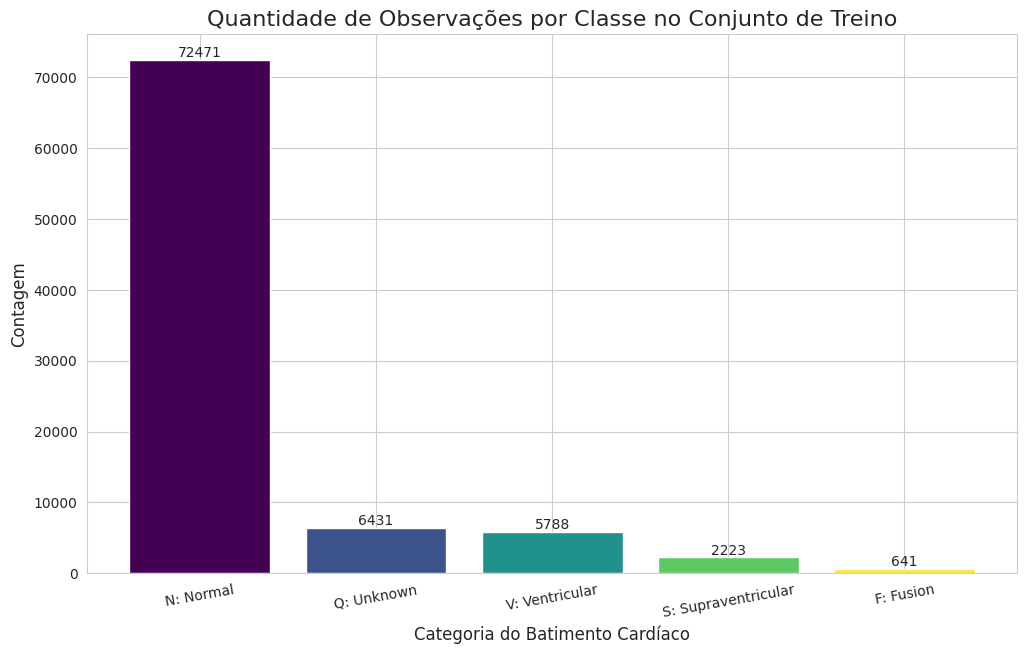

In [ ]:
figura, eixo = plt.subplots(figsize=(12, 7))
barras = eixo.bar(
    rotulosClasses,
    contagemClasses.values,
    color=plt.cm.viridis(np.linspace(0, 1, len(rotulosClasses)))
)
eixo.set_title('Quantidade de Observações por Classe no Conjunto de Treino', fontsize=16)
eixo.set_xlabel('Categoria do Batimento Cardíaco', fontsize=12)
eixo.set_ylabel('Contagem', fontsize=12)
eixo.tick_params(axis='x', rotation=10)
for barra in barras:
    altura = barra.get_height()
    eixo.text(barra.get_x() + barra.get_width() / 2.0, altura, f'{altura}', ha='center', va='bottom', fontsize=10)

plt.show()

This code plots the time series for each of the 187 features, separating the signals into the five distinct classes. These plots reveal a crucial insight: after approximately the 140th time step, the signals tend to converge or flatline, suggesting they contain less discriminative information beyond this point. This observation is particularly important for RNNs, which struggle with long sequences. This difficulty stems from the vanishing gradient problem during training and a more general challenge of maintaining relevant information (or 'memory') over extended time steps during inference. By truncating the sequences, we can mitigate these issues and also significantly speed up the training process. This efficiency is vital during hyperparameter tuning, as it allows for faster experimentation and iteration

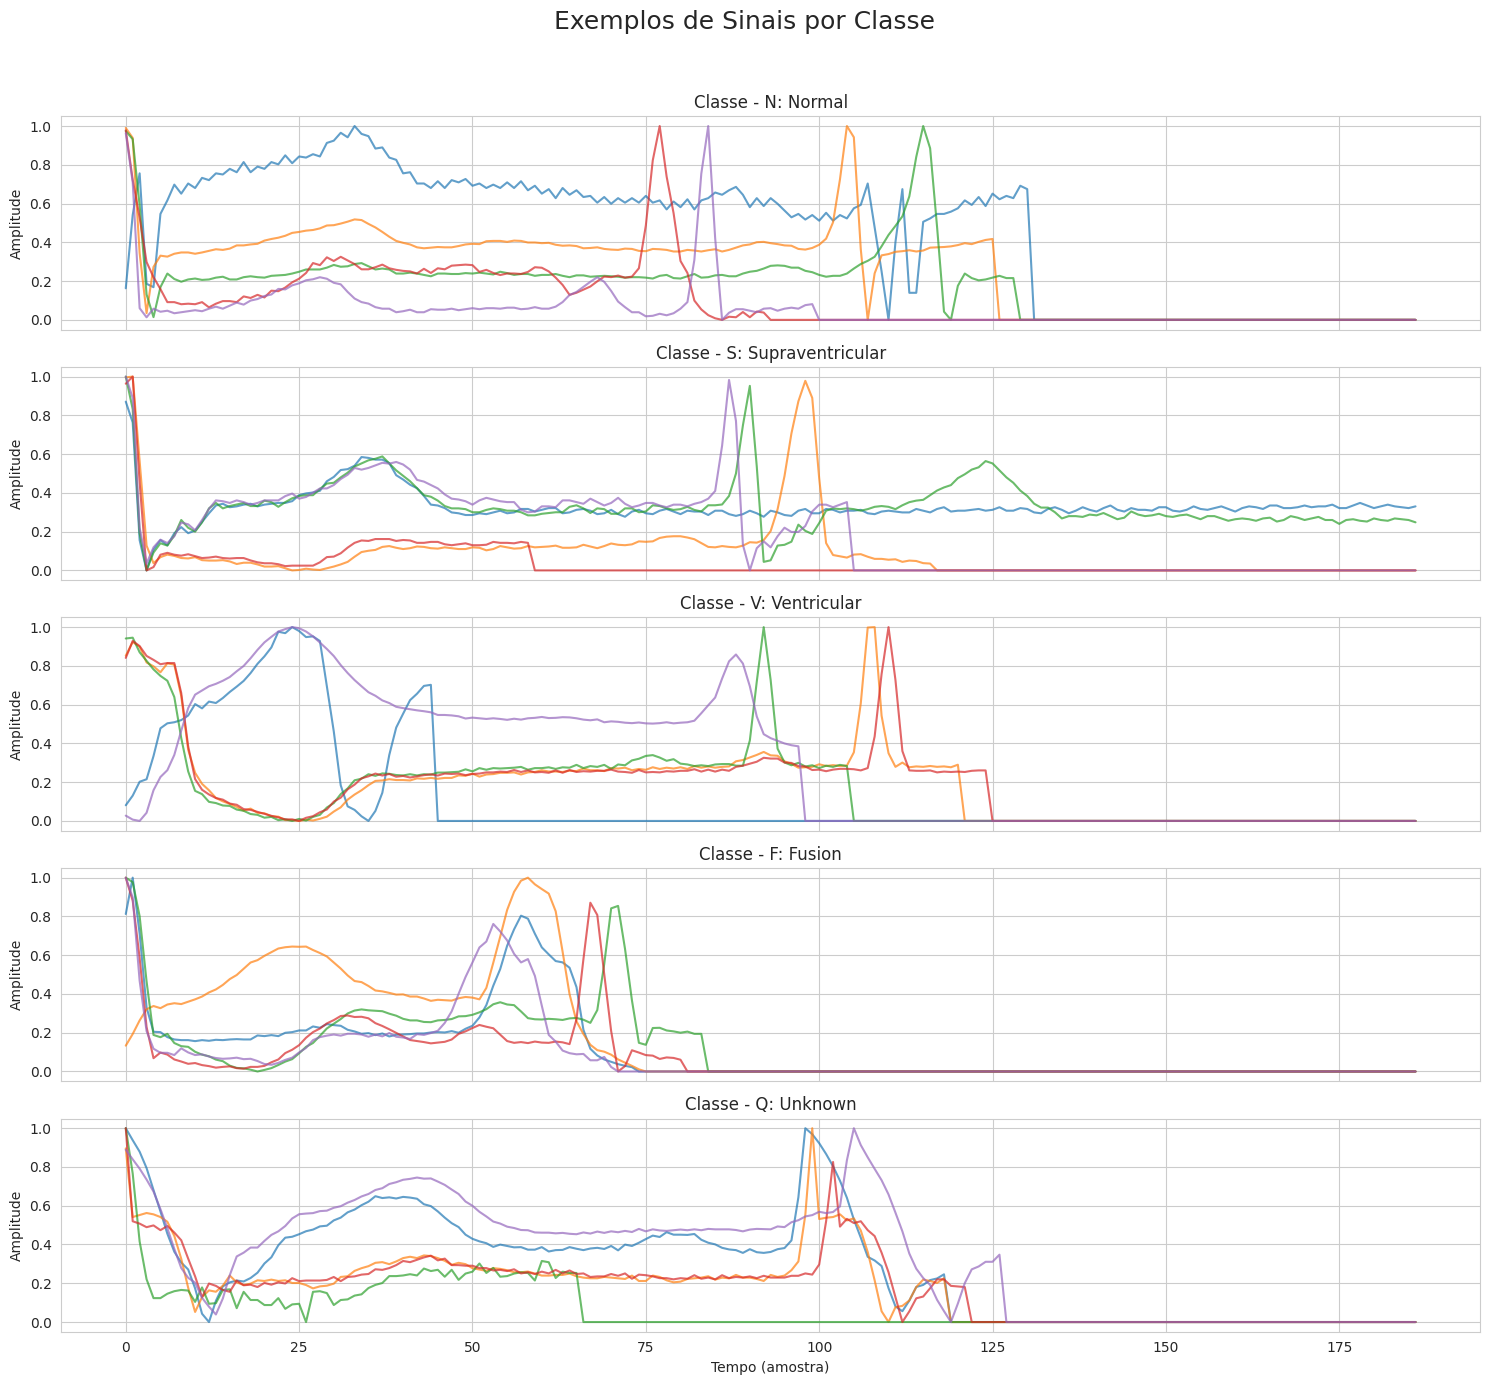

In [ ]:
figura, eixos = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
figura.suptitle('Exemplos de Sinais por Classe', fontsize=18, y=0.92)

for indice, (codigoClasse, nomeClasse) in enumerate(mapeamentoCategorias.items()):
    amostrasDaClasse = dadosTreinoBrutos[dadosTreinoBrutos['categoria'] == codigoClasse].sample(5, random_state=42)

    eixoAtual = eixos[indice]
    for _, linha in amostrasDaClasse.iterrows():
        eixoAtual.plot(linha.iloc[:187], alpha=0.7)

    eixoAtual.set_title(f'Classe - {nomeClasse}')
    eixoAtual.set_ylabel("Amplitude")

eixos[-1].set_xlabel("Tempo (amostra)")
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [ ]:
treinoMetrica = pd.DataFrame()

treinoMetrica['media'] = dadosTreinoBrutos.iloc[:, :187].mean(axis=1)
treinoMetrica['desvioPadrao'] = dadosTreinoBrutos.iloc[:, :187].std(axis=1)
treinoMetrica['valorMaximo'] = dadosTreinoBrutos.iloc[:, :187].max(axis=1)
treinoMetrica['valorMinimo'] = dadosTreinoBrutos.iloc[:, :187].min(axis=1)
treinoMetrica['categoria'] = dadosTreinoBrutos.iloc[:, 187]

In [ ]:
treinoMetrica

media  desvioPadrao  valorMaximo  valorMinimo  categoria
0      0.098419      0.176545          1.0          0.0          0
1      0.090010      0.160151          1.0          0.0          0
2      0.062104      0.139142          1.0          0.0          0
3      0.084084      0.161252          1.0          0.0          0
4      0.116567      0.186651          1.0          0.0          0
...         ...           ...          ...          ...        ...
87549  0.158364      0.169925          1.0          0.0          4
87550  0.325508      0.293708          1.0          0.0          4
87551  0.316665      0.275855          1.0          0.0          4
87552  0.101807      0.161769          1.0          0.0          4
87553  0.346237      0.299571          1.0          0.0          4

[87554 rows x 5 columns]

/tmp/ipython-input-445577150.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  eixoAtual.boxplot(dadosParaBoxplot, labels=rotulosClasses, patch_artist=True,
/tmp/ipython-input-445577150.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  eixoAtual.boxplot(dadosParaBoxplot, labels=rotulosClasses, patch_artist=True,
/tmp/ipython-input-445577150.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  eixoAtual.boxplot(dadosParaBoxplot, labels=rotulosClasses, patch_artist=True,
/tmp/ipython-input-445577150.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplo

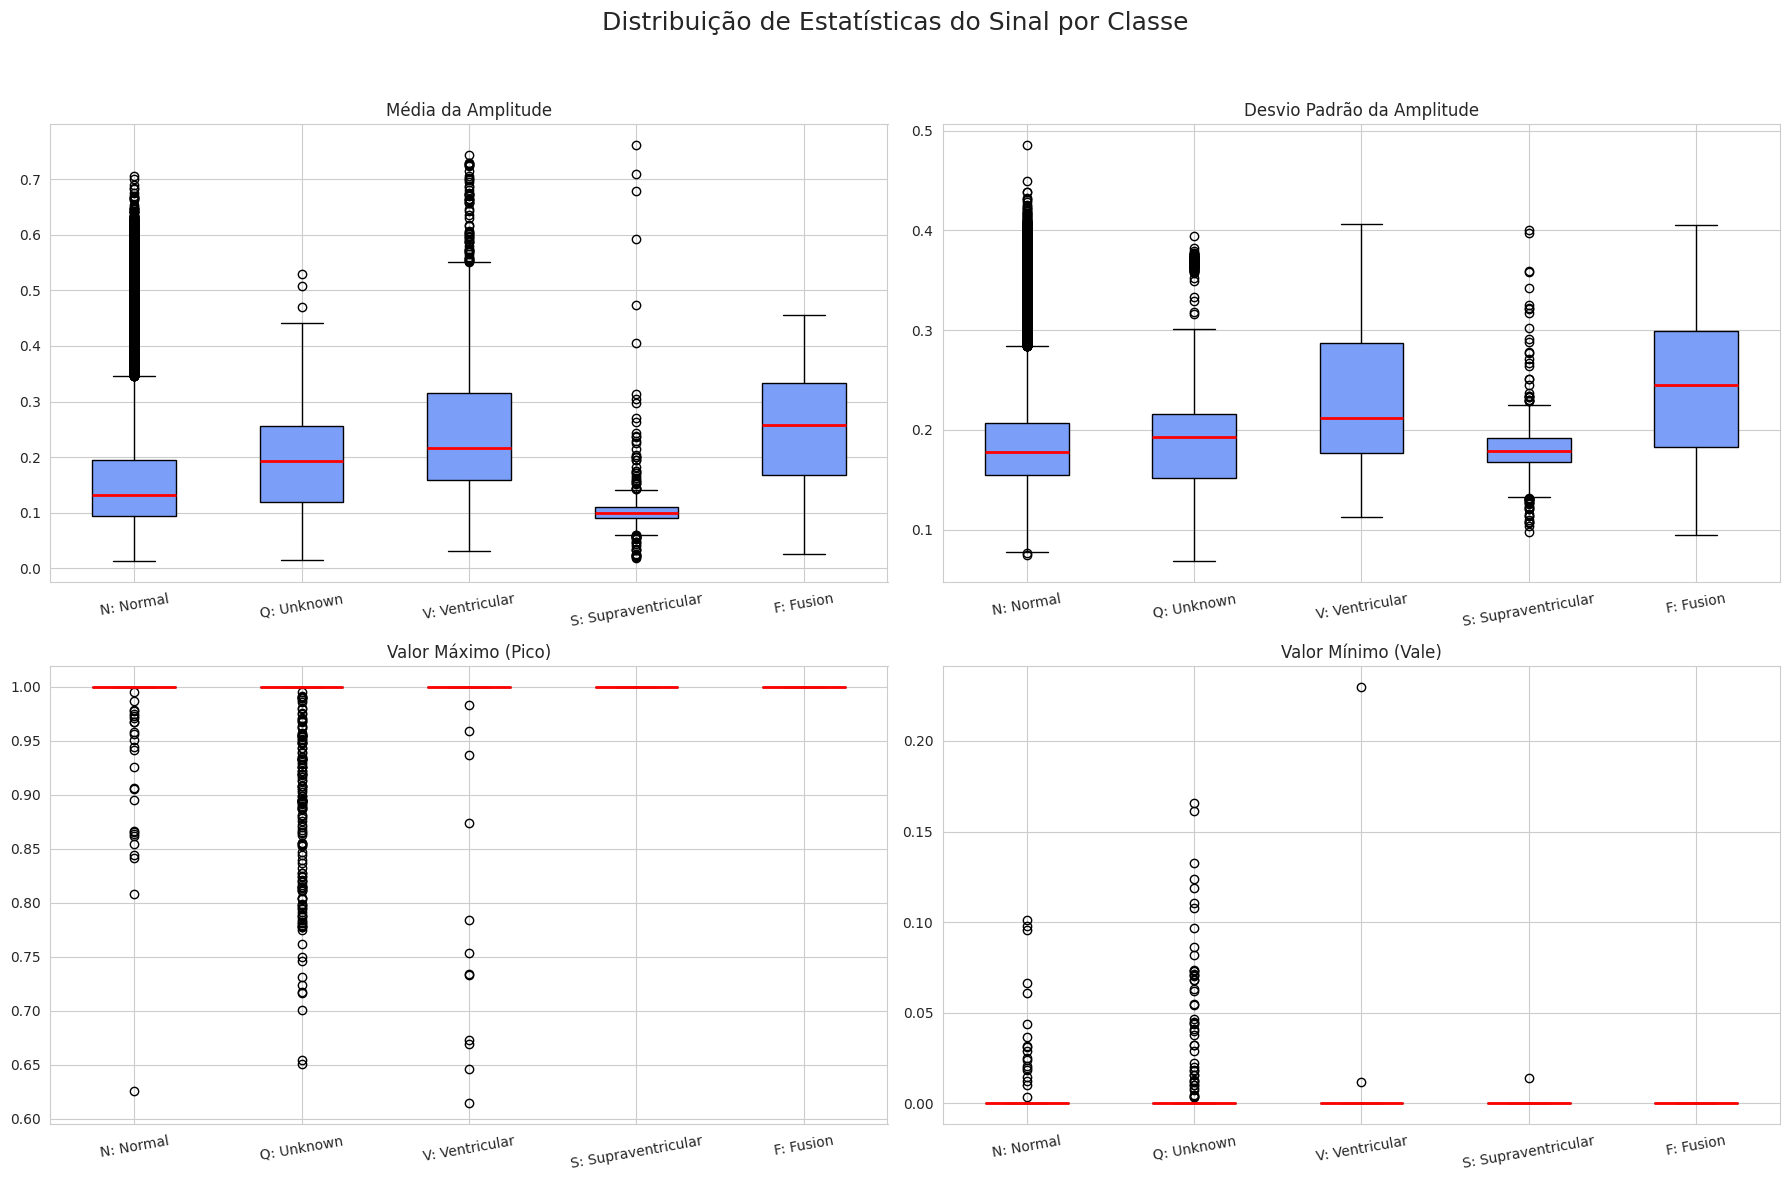

In [ ]:
estatisticas = ['media', 'desvioPadrao', 'valorMaximo', 'valorMinimo']
titulos = ['Média da Amplitude', 'Desvio Padrão da Amplitude', 'Valor Máximo (Pico)', 'Valor Mínimo (Vale)']

figura, eixos = plt.subplots(2, 2, figsize=(18, 12))
figura.suptitle('Distribuição de Estatísticas do Sinal por Classe', fontsize=18)
eixos = eixos.flatten()

for indice, (estatistica, titulo) in enumerate(zip(estatisticas, titulos)):
    dadosParaBoxplot = [treinoMetrica[treinoMetrica['categoria'] == i][estatistica] for i in range(len(mapeamentoCategorias))]

    eixoAtual = eixos[indice]
    eixoAtual.boxplot(dadosParaBoxplot, labels=rotulosClasses, patch_artist=True,
                      boxprops=dict(facecolor=plt.cm.coolwarm(0.2), color="black"),
                      medianprops=dict(color="red", linewidth=2))
    eixoAtual.set_title(titulo)
    eixoAtual.tick_params(axis='x', rotation=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

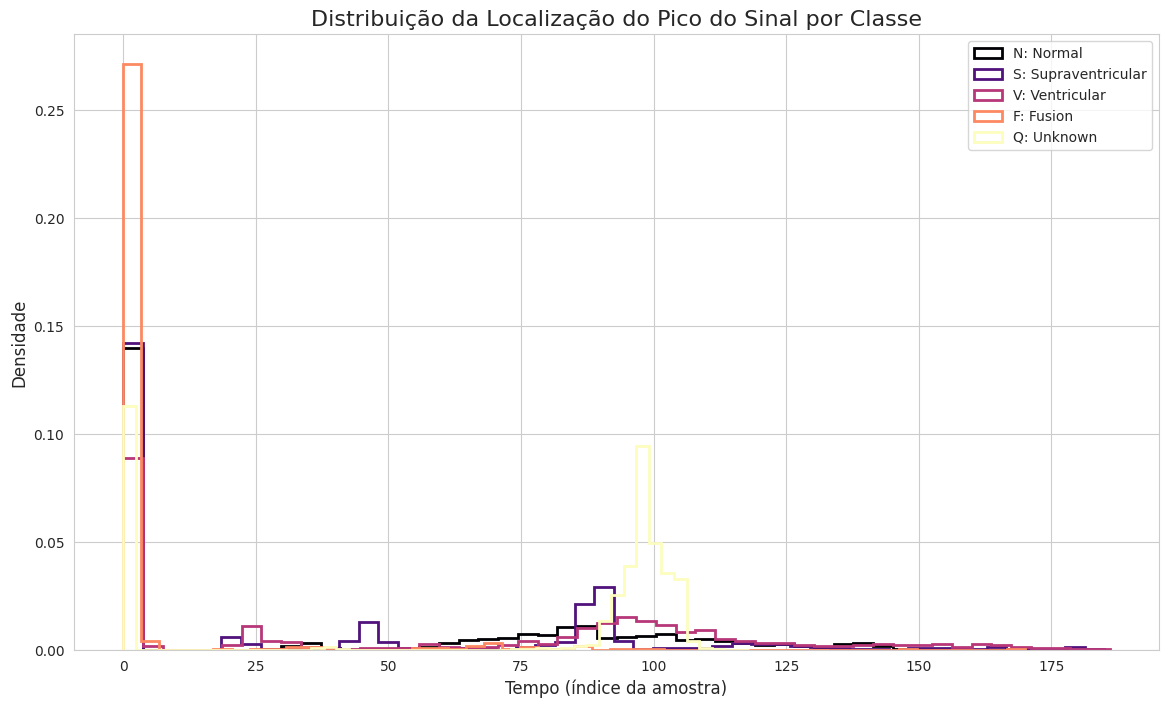

In [ ]:
dadosTreinoBrutos['localizacaoPico'] = dadosTreinoBrutos.iloc[:, :187].apply(np.argmax, axis=1)

figura, eixo = plt.subplots(figsize=(14, 8))
cores = plt.cm.magma(np.linspace(0, 1, len(mapeamentoCategorias)))

for indice, (codigoClasse, nomeClasse) in enumerate(mapeamentoCategorias.items()):
    dadosPico = dadosTreinoBrutos[dadosTreinoBrutos['categoria'] == codigoClasse]['localizacaoPico']

    eixo.hist(dadosPico, bins=50, label=nomeClasse, histtype='step', linewidth=2, density=True, color=cores[indice])

eixo.set_title('Distribuição da Localização do Pico do Sinal por Classe', fontsize=16)
eixo.set_xlabel('Tempo (índice da amostra)', fontsize=12)
eixo.set_ylabel('Densidade', fontsize=12)
eixo.legend()
plt.show()

# Preprocessing

Splitting the data into training and validation sets. It's crucial to maintain three distinct datasets: a training set to fit various models, a validation set to tune hyperparameters and select the best model, and a final test set. The test set provides an unbiased estimate of the model's real-world performance. We cannot use the validation set for this final evaluation because, after testing multiple models, we might inadvertently 'overfit' to it, choosing a model that performs well on that specific data just by chance

In [ ]:
dadosParaTreino, dadosParaValidacao = train_test_split(
    dadosTreinoBruto,
    test_size=0.2,
    random_state=42,
    stratify=dadosTreinoBruto[187]
)

Balancing the dataset via resampling. To address the class imbalance, we'll perform both under-sampling on the majority class and over-sampling on the minority classes. Each class will be adjusted to contain exactly 15,000 samples

In [ ]:
def balancearDados(dataframe, numeroDeAmostras=15000):
    dfClasse0 = dataframe[dataframe[187] == 0]
    dfClasse1 = dataframe[dataframe[187] == 1]
    dfClasse2 = dataframe[dataframe[187] == 2]
    dfClasse3 = dataframe[dataframe[187] == 3]
    dfClasse4 = dataframe[dataframe[187] == 4]

    dfClasse0_bal = dfClasse0.sample(n=numeroDeAmostras, random_state=42)
    dfClasse1_bal = resample(dfClasse1, replace=True, n_samples=numeroDeAmostras, random_state=123)
    dfClasse2_bal = resample(dfClasse2, replace=True, n_samples=numeroDeAmostras, random_state=124)
    dfClasse3_bal = resample(dfClasse3, replace=True, n_samples=numeroDeAmostras, random_state=125)
    dfClasse4_bal = resample(dfClasse4, replace=True, n_samples=numeroDeAmostras, random_state=126)

    return pd.concat([dfClasse0_bal, dfClasse1_bal, dfClasse2_bal, dfClasse3_bal, dfClasse4_bal])

A note on our balancing strategy: While the ideal approach would be to retain all data from the majority class and only over-sample the minority classes, this would create an exceptionally large dataset. Such a dataset would make the subsequent hyperparameter tuning phase computationally infeasible with the available resources. Therefore, we are making a pragmatic trade-off. We will proceed by both under-sampling the majority class and over-sampling the minority classes to a more manageable size. This allows for an efficient and extensive hyperparameter search while still effectively mitigating the class imbalance

In [ ]:
dadosTreinoBalanceados = balancearDados(dadosParaTreino)
xTreino = dadosTreinoBalanceados.drop(187, axis=1).values
yTreino = dadosTreinoBalanceados[187].values

print(f"Conjunto de treino criado com {len(xTreino)} amostras (balanceado).")
print("Distribuição de classes no treino balanceado:")
print(pd.Series(yTreino).value_counts().sort_index())

Conjunto de treino criado com 75000 amostras (balanceado).
Distribuição de classes no treino balanceado:
0.0    15000
1.0    15000
2.0    15000
3.0    15000
4.0    15000
Name: count, dtype: int64


Crucially, the validation set is not balanced. Its data distribution must remain untouched to serve as a realistic proxy for the test set and, ultimately, for real-world data

In [ ]:
xValidacao = dadosParaValidacao.drop(187, axis=1).values
yValidacao = dadosParaValidacao[187].values

print(f"Conjunto de validação criado com {len(xValidacao)} amostras (desbalanceado/realista).")
print("Distribuição de classes na validação:")
print(pd.Series(yValidacao).value_counts().sort_index())

Conjunto de validação criado com 17511 amostras (desbalanceado/realista).
Distribuição de classes na validação:
0.0    14494
1.0      445
2.0     1158
3.0      128
4.0     1286
Name: count, dtype: int64


In [ ]:
xTeste = dadosTesteBruto.drop(187, axis=1).values
yTeste = dadosTesteBruto[187].values

Defines a custom Dataset class to wrap our ECG samples and labels, making them compatible with PyTorch's DataLoader

In [ ]:
class MeuConjuntoDeDadosECG(Dataset):
    def __init__(self, amostras, rotulos):
        self.amostras = torch.tensor(amostras, dtype=torch.float32).unsqueeze(2)
        self.rotulos = torch.tensor(rotulos, dtype=torch.long)
    def __len__(self):
        return len(self.amostras)
    def __getitem__(self, idx):
        return self.amostras[idx], self.rotulos[idx]

In [ ]:
conjuntoDeTreino = MeuConjuntoDeDadosECG(xTreino, yTreino)
conjuntoDeValidacao = MeuConjuntoDeDadosECG(xValidacao, yValidacao)

Defining the neural network class. This flexible LSTM architecture allows for dynamic creation of layers, dropout rates, and bidirectional options for hyperparameter tuning

In [ ]:
class RedeLSTMFlexivel(nn.Module):
    def __init__(self, tamanhoDaEntrada, numeroDeClasses, tamanhosDasCamadasOcultas, valoresDeDropout, bidirecional):
        super().__init__()
        self.bidirecional = bidirecional

        self.camadasLstm = nn.ModuleList()
        self.camadasDeDropout = nn.ModuleList()

        tamanhoAtualDaEntrada = tamanhoDaEntrada
        numeroDeDirecoes = 2 if bidirecional else 1

        for i, tamanhoDaCamadaOculta in enumerate(tamanhosDasCamadasOcultas):
            self.camadasLstm.append(
                nn.LSTM(
                    input_size=tamanhoAtualDaEntrada,
                    hidden_size=tamanhoDaCamadaOculta,
                    num_layers=1,
                    batch_first=True,
                    bidirectional=bidirecional
                )
            )
            self.camadasDeDropout.append(nn.Dropout(p=valoresDeDropout[i]))
            tamanhoAtualDaEntrada = tamanhoDaCamadaOculta * numeroDeDirecoes

        self.camadaDeClassificacao = nn.Linear(tamanhoAtualDaEntrada, numeroDeClasses)

    def forward(self, dadosDeEntrada):
        saidaIntermediaria = dadosDeEntrada
        estadoOcultoFinalDaUltimaCamada = None

        for i in range(len(self.camadasLstm)):
            camadaLstm = self.camadasLstm[i]
            camadaDropout = self.camadasDeDropout[i]
            saidaIntermediaria, estadoOcultoFinalDaUltimaCamada = camadaLstm(saidaIntermediaria)
            saidaIntermediaria = camadaDropout(saidaIntermediaria)

        h_n_final = estadoOcultoFinalDaUltimaCamada[0]

        if self.bidirecional:
            resumoDaSequencia = torch.cat((h_n_final[0], h_n_final[1]), dim=1)
        else:
            resumoDaSequencia = h_n_final.squeeze(0)

        logits = self.camadaDeClassificacao(resumoDaSequencia)
        return logits

Adding a custom learning rate scheduler with a warm-up phase. This allows the learning rate to change dynamically, a strategy we'll explore during hyperparameter tuning to potentially improve the final results

In [ ]:
LR_INICIAL      = 0.00001
LR_MAXIMA       = 0.00005 * (torch.cuda.device_count() if torch.cuda.is_available() else 1)
LR_MINIMA       = 0.00001
LR_AQUECIMENTO  = 5
LR_SUSTENTACAO  = 2
LR_DECAIMENTO   = 0.9

In [ ]:
def agendadorTaxaAprendizado(epoca, lrInicial=1e-3):
    if epoca < LR_AQUECIMENTO:
        lr = (LR_MAXIMA - lrInicial) / LR_AQUECIMENTO * epoca + lrInicial
    elif epoca < LR_AQUECIMENTO + LR_SUSTENTACAO:
        lr = LR_MAXIMA
    else:
        lr = (LR_MAXIMA - LR_MINIMA) * LR_DECAIMENTO**(epoca - LR_AQUECIMENTO - LR_SUSTENTACAO) + LR_MINIMA
    return lr

This function handles the complete training and validation loop for a single model instance. We'll use it for manual training runs or final model training after hyperparameter tuning

In [ ]:
def treinarModelo(modelo, loaderTreino, loaderValidacao, funcaoPerda, otimizador, epochs, dispositivo, paciencia, caminhoCheckpoint, agendarTaxaAprendizado, lrInicial):
    historico = {'ErroTreino': [], 'AcuraciaTreino': [], 'ErroValidacao': [], 'AcuraciaValidacao': [], 'F1Validacao': []}
    melhorAcuraciaValidacao = 0.0
    epocasSemMelhora = 0
    for epoch in range(epochs):

        if agendarTaxaAprendizado:
            lr_atual = agendadorTaxaAprendizado(epoch, lrInicial=0.001)
            for grupo_param in otimizador.param_groups:
                grupo_param['lr'] = lr_atual

        modelo.train()
        treinoErro, treinoCorreto, treinoTotal = 0.0, 0, 0
        loopTreino = tqdm(loaderTreino, desc=f"Época {epoch+1}/{epochs} [Treino]", leave=False)
        for entradas, rotulos in loopTreino:
            entradas, rotulos = entradas.to(dispositivo), rotulos.to(dispositivo)
            otimizador.zero_grad(); saidas = modelo(entradas); erro = funcaoPerda(saidas, rotulos)
            erro.backward(); otimizador.step()
            treinoErro += erro.item(); _, previstos = torch.max(saidas.data, 1)
            treinoTotal += rotulos.size(0); treinoCorreto += (previstos == rotulos).sum().item()
        modelo.eval()
        validacaoErro, todosRotulosVal, todosPrevistosVal = 0.0, [], []
        with torch.no_grad():
            for entradas, rotulos in loaderValidacao:
                entradas, rotulos = entradas.to(dispositivo), rotulos.to(dispositivo)
                saidas = modelo(entradas); erro = funcaoPerda(saidas, rotulos)
                validacaoErro += erro.item(); _, previstos = torch.max(saidas.data, 1)
                todosRotulosVal.extend(rotulos.cpu().numpy()); todosPrevistosVal.extend(previstos.cpu().numpy())
        epochTreinoAcc = treinoCorreto / treinoTotal
        epochValidacaoAcc = accuracy_score(todosRotulosVal, todosPrevistosVal)
        epochTreinoErro = treinoErro / len(loaderTreino)
        epochValidacaoErro = validacaoErro / len(loaderValidacao)
        epochF1Validacao = f1_score(todosRotulosVal, todosPrevistosVal, average='macro')
        historico['AcuraciaTreino'].append(epochTreinoAcc); historico['ErroTreino'].append(epochTreinoErro)
        historico['AcuraciaValidacao'].append(epochValidacaoAcc); historico['ErroValidacao'].append(epochValidacaoErro)
        historico['F1Validacao'].append(epochF1Validacao)
        print(f"Época {epoch+1}: Acc Treino: {epochTreinoAcc:.4f} | Acc Val: {epochValidacaoAcc:.4f} | F1 Val: {epochF1Validacao:.4f}")
        if epochF1Validacao > melhorAcuraciaValidacao:
            print(f"F1 de validação melhorou ({melhorAcuraciaValidacao:.4f} -> {epochF1Validacao:.4f}).")
            melhorAcuraciaValidacao = epochF1Validacao; torch.save(modelo.state_dict(), caminhoCheckpoint); epocasSemMelhora = 0
        else:
            epocasSemMelhora += 1
        if epocasSemMelhora >= paciencia:
            print(f"Parada antecipada!")
            break
    if os.path.exists(caminhoCheckpoint):
        print(f"Carregando melhor modelo de '{caminhoCheckpoint}'")
        modelo.load_state_dict(torch.load(caminhoCheckpoint))
    return historico

This function wraps our training process and serves as the objective function for the Bayesian hyperparameter optimization. It takes a set of hyperparameters, trains a model, and returns the validation metric (e.g., F1-score) for the tuner to evaluate

In [ ]:
def funcaoObjetivoTreino(configuracaoDaTentativa):
    dispositivoDaTentativa = "cuda:0" if torch.cuda.is_available() else "cpu"
    carregadorDeTreino = DataLoader(conjuntoDeTreino, batch_size=configuracaoDaTentativa["tamanhoBatch"], shuffle=True, num_workers=2)
    carregadorDeValidacao = DataLoader(conjuntoDeValidacao, batch_size=configuracaoDaTentativa["tamanhoBatch"], num_workers=2)
    modelo = RedeLSTMFlexivel(
        tamanhoDaEntrada=1, numeroDeClasses=5,
        tamanhosDasCamadasOcultas=configuracaoDaTentativa["camadasLSTM"],
        valoresDeDropout=configuracaoDaTentativa["dropOut"],
        bidirecional=configuracaoDaTentativa["bidirecional"]
    ).to(dispositivoDaTentativa)
    funcaoDePerda = nn.CrossEntropyLoss()
    otimizador = torch.optim.Adam(modelo.parameters(), lr=configuracaoDaTentativa["razaoAprendizado"])
    melhorF1DaTentativa = 0.0
    for epoca in range(15):
        if configuracaoDaTentativa["usarAgendadorLR"]:
            lr_atual = agendadorTaxaAprendizado(epoca, lrInicial=configuracaoDaTentativa["razaoAprendizado"])
            for grupo_param in otimizador.param_groups:
                grupo_param['lr'] = lr_atual
        modelo.train()
        for entradas, rotulos in carregadorDeTreino:
            entradas, rotulos = entradas.to(dispositivoDaTentativa), rotulos.to(dispositivoDaTentativa)
            otimizador.zero_grad(); saidas = modelo(entradas); erro = funcaoDePerda(saidas, rotulos)
            erro.backward(); otimizador.step()
        modelo.eval()
        listaRotulosVal, listaPrevistosVal = [], []
        with torch.no_grad():
            for entradas, rotulos in carregadorDeValidacao:
                saidas = modelo(entradas.to(dispositivoDaTentativa)); _, previstos = torch.max(saidas.data, 1)
                listaRotulosVal.extend(rotulos.cpu().numpy()); listaPrevistosVal.extend(previstos.cpu().numpy())
        f1DaValidacao = f1_score(listaRotulosVal, listaPrevistosVal, average='macro')
        acuraciaDaValidacao = accuracy_score(listaRotulosVal, listaPrevistosVal)

        metricas = {
            "f1_validacao": f1DaValidacao,
            "acuracia_validacao": acuraciaDaValidacao
        }

        if f1DaValidacao > melhorF1DaTentativa:
            melhorF1DaTentativa = f1DaValidacao
            with tempfile.TemporaryDirectory() as diretorio_checkpoint_temp:
                caminho_do_arquivo = os.path.join(diretorio_checkpoint_temp, "checkpoint.pt")
                torch.save(modelo.state_dict(), caminho_do_arquivo)
                checkpoint = train.Checkpoint.from_directory(diretorio_checkpoint_temp)

                train.report(metricas, checkpoint=checkpoint)
        else:
            train.report(metricas, checkpoint=None)

# Hyperparameter Optimization and Final Model Training
## This section covers the core of our experiment: running the Bayesian hyperparameter search to find the best model configurations, followed by re-training the top candidates to select our final champion model

This dictionary defines the search space for our hyperparameter optimization. For each hyperparameter, we specify a range or a set of possible values that the tuning algorithm will explore

In [ ]:
opcoesDeNeuronios = [16, 32, 64, 128, 256]
opcoesDeDropout = [0.1, 0.2, 0.3, 0.4, 0.5]
espacoDeBusca = {
    "tamanhoBatch": tune.choice([64, 128]),
    "razaoAprendizado": tune.loguniform(1e-4, 1e-2),
    "bidirecional": tune.choice([True, False]),
    "num_camadas": tune.randint(1, 5),
    "camadasLSTM": tune.sample_from(lambda spec: [random.choice(opcoesDeNeuronios) for _ in range(spec.config.num_camadas)]),
    "dropOut": tune.sample_from(lambda spec: [random.choice(opcoesDeDropout) for _ in range(spec.config.num_camadas)]),
    "usarAgendadorLR": tune.choice([True, False])
}
algoritmoDeBusca = OptunaSearch(metric="f1_validacao", mode="max")
agendador = ASHAScheduler(metric="f1_validacao", mode="max", max_t=15, grace_period=10, reduction_factor=2)
relator = CLIReporter(metric_columns=["f1_validacao", "acuracia_validacao", "training_iteration"])
if ray.is_initialized(): ray.shutdown()
ray.init(ignore_reinit_error=True)

2025-08-27 21:37:11,187	INFO worker.py:1951 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.12.11', ray_version='2.49.0', ray_commit='66438d8bd27f8c604ee5a0cd2cfc5649053285ed')

Running the Bayesian Hyperparameter Optimization. Unlike random or grid search, this intelligent approach builds a probabilistic model of the objective function. It uses the results from past trials to make informed decisions about which new set of hyperparameters to test next. While this can sometimes risk overfitting the search process to the validation set, we are confident that our robust data splitting and sufficient sample size will mitigate this issue. The hyperparameter search was configured to run for a total of 100 trials. However, due to computational and time constraints, the process was stopped early, resulting in a smaller but still insightful number of completed evaluations

In [ ]:
analise = tune.run(
    funcaoObjetivoTreino,
    config=espacoDeBusca,
    num_samples=100,
    search_alg=algoritmoDeBusca,
    scheduler=agendador,
    progress_reporter=relator,
    name="otimizacao_avancada_ecg",
    resources_per_trial={"cpu": 2, "gpu": 1 if torch.cuda.is_available() else 0},
    keep_checkpoints_num=1,
    checkpoint_score_attr="f1_validacao"
)

[I 2025-08-27 21:37:13,592] A new study created in memory with name: optuna
2025-08-27 21:37:13,594	WARNING tune.py:902 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+------------------------------------------------------------+
| Configuration for experiment     otimizacao_avancada_ecg   |
+------------------------------------------------------------+
| Search algorithm                 SearchGenerator           |
| Scheduler                        AsyncHyperBandScheduler   |
| Number of trials                 100                       |
+------------------------------------------------------------+

View detailed results here: /root/ray_results/otimizacao_avancada_ecg
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-08-27_21-37-09_625841_387/artifacts/2025-08-27_21-37-13/otimizacao_avancada_ecg/driver_artifacts`


2025-08-27 21:37:13,859	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 21:37:13,860	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 1 PENDING
Current time: 2025-08-27 21:37:15. Total running time: 1s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR   |
+-------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_77668362   PENDING                64          0.000267201   False                        3   False             |
+-------------------------------------------------------------------------------------------------------------------------------------+
(raylet) Warning: The actor ImplicitFunc is very large (66 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: 

2025-08-27 21:37:22,545	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 21:37:22,547	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:37:45. Total running time: 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR   |
+-------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_77668362   RUNNING                64          0.000267201   False                        3   False             |
| funcaoObjetivoTreino_c1066ff8   PENDING                64          0.000106495   True                         2   True              |
+-------------------------------------------------------------------------------------------------------------------------------------+


2025-08-27 21:37:48,836	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_77668362 finished iteration 1 at 2025-08-27 21:37:48. Total running time: 35s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_77668362 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        26.60836 |
| time_total_s                                            26.60836 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.38496 |
| f1_validacao                                             0.25357 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_77668362 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dr

(funcaoObjetivoTreino pid=2511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_21-37-14/checkpoint_000000)



Trial funcaoObjetivoTreino_77668362 finished iteration 2 at 2025-08-27 21:38:08. Total running time: 55s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_77668362 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               19.9761 |
| time_total_s                                   46.5844 |
| training_iteration                                   2 |
| acuracia_validacao                             0.32757 |
| f1_validacao                                   0.23396 |
+--------------------------------------------------------+

Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:38:15. Total running time: 1min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------------------------------------

2025-08-27 21:38:29,281	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_77668362 finished iteration 3 at 2025-08-27 21:38:29. Total running time: 1min 15s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_77668362 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        20.45089 |
| time_total_s                                             67.0353 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.40352 |
| f1_validacao                                             0.25678 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_77668362 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=2511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_21-37-14/checkpoint_000001)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:38:45. Total running time: 1min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_77668362   RUNNING                64          0.000267201   False                        3   False                    3            67.0353         0.256777               0.403518 |
| func

2025-08-27 21:39:51,753	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_77668362 finished iteration 7 at 2025-08-27 21:39:51. Total running time: 2min 38s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_77668362 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        21.58443 |
| time_total_s                                           149.48385 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.48535 |
| f1_validacao                                             0.30014 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_77668362 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=2511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_21-37-14/checkpoint_000002)
2025-08-27 21:40:12,489	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_77668362 finished iteration 8 at 2025-08-27 21:40:12. Total running time: 2min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_77668362 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        20.72577 |
| time_total_s                                           170.20962 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.52036 |
| f1_validacao                                             0.34465 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_77668362 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=2511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_21-37-14/checkpoint_000003)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:40:15. Total running time: 3min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_77668362   RUNNING                64          0.000267201   False                        3   False                    8             170.21         0.344645               0.520359 |
| funca

2025-08-27 21:40:32,729	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_77668362 finished iteration 9 at 2025-08-27 21:40:32. Total running time: 3min 19s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_77668362 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        20.22957 |
| time_total_s                                           190.43919 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.55434 |
| f1_validacao                                              0.3796 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_77668362 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=2511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_21-37-14/checkpoint_000004)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:40:45. Total running time: 3min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_77668362   RUNNING                64          0.000267201   False                        3   False                    9            190.439         0.379597               0.554337 |
| func

(funcaoObjetivoTreino pid=2511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_21-37-14/checkpoint_000005)
2025-08-27 21:40:53,034	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_77668362 finished iteration 10 at 2025-08-27 21:40:53. Total running time: 3min 39s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_77668362 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        20.29273 |
| time_total_s                                           210.73192 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.52556 |
| f1_validacao                                             0.39786 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_77668362 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b5

2025-08-27 21:41:13,339	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_77668362 finished iteration 11 at 2025-08-27 21:41:13. Total running time: 3min 59s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_77668362 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        20.28846 |
| time_total_s                                           231.02037 |
| training_iteration                                            11 |
| acuracia_validacao                                       0.69008 |
| f1_validacao                                             0.48602 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_77668362 saved a checkpoint for iteration 11 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=2511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_21-37-14/checkpoint_000006)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:41:15. Total running time: 4min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_77668362   RUNNING                64          0.000267201   False                        3   False                   11             231.02         0.486018               0.690081 |
| funca

(funcaoObjetivoTreino pid=2511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_21-37-14/checkpoint_000007)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:41:45. Total running time: 4min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_77668362   RUNNING                64          0.000267201   False                        3   False                   12            251.024         0.501974               0.712067 |
| func

2025-08-27 21:42:13,933	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_77668362 finished iteration 14 at 2025-08-27 21:42:13. Total running time: 5min 0s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_77668362 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                        19.98883 |
| time_total_s                                           291.59414 |
| training_iteration                                            14 |
| acuracia_validacao                                       0.80235 |
| f1_validacao                                               0.582 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_77668362 saved a checkpoint for iteration 14 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=2511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_21-37-14/checkpoint_000008)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:42:15. Total running time: 5min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_77668362   RUNNING                64          0.000267201   False                        3   False                   14            291.594         0.582004               0.802353 |
| funca

2025-08-27 21:42:34,401	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_77668362 finished iteration 15 at 2025-08-27 21:42:34. Total running time: 5min 20s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_77668362 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000009 |
| time_this_iter_s                                        20.45686 |
| time_total_s                                             312.051 |
| training_iteration                                            15 |
| acuracia_validacao                                       0.83702 |
| f1_validacao                                             0.62083 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_77668362 saved a checkpoint for iteration 15 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=2511) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_77668362_1_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_21-37-14/checkpoint_000009)



Trial funcaoObjetivoTreino_c1066ff8 started with configuration:
+-----------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 config                |
+-----------------------------------------------------------+
| bidirecional                                         True |
| camadasLSTM                                     [16, 128] |
| dropOut                                        [0.2, 0.5] |
| num_camadas                                             2 |
| razaoAprendizado                                  0.00011 |
| tamanhoBatch                                           64 |
| usarAgendadorLR                                      True |
+-----------------------------------------------------------+


2025-08-27 21:42:40,923	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 21:42:40,924	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:42:45. Total running time: 5min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c1066ff8   RUNNING                  64          0.000106495   True                         2   True                                                                   

2025-08-27 21:42:57,262	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c1066ff8 finished iteration 1 at 2025-08-27 21:42:57. Total running time: 5min 43s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        16.64789 |
| time_total_s                                            16.64789 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.24739 |
| f1_validacao                                             0.22063 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c1066ff8 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000000)
2025-08-27 21:43:10,967	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c1066ff8 finished iteration 2 at 2025-08-27 21:43:10. Total running time: 5min 57s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        13.69526 |
| time_total_s                                            30.34315 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.54332 |
| f1_validacao                                             0.39076 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c1066ff8 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000001)



Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:43:15. Total running time: 6min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c1066ff8   RUNNING                  64          0.000106495   True                         2   True                     2            30.3431         0.390761          

2025-08-27 21:43:24,678	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c1066ff8 finished iteration 3 at 2025-08-27 21:43:24. Total running time: 6min 11s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        13.70407 |
| time_total_s                                            44.04721 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.55976 |
| f1_validacao                                             0.40812 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c1066ff8 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000002)
2025-08-27 21:43:38,281	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c1066ff8 finished iteration 4 at 2025-08-27 21:43:38. Total running time: 6min 24s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        13.59571 |
| time_total_s                                            57.64293 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.60065 |
| f1_validacao                                             0.45728 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c1066ff8 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000003)



Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:43:45. Total running time: 6min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c1066ff8   RUNNING                  64          0.000106495   True                         2   True                     4            57.6429         0.457275         

2025-08-27 21:44:18,675	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c1066ff8 finished iteration 7 at 2025-08-27 21:44:18. Total running time: 7min 5s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         13.4653 |
| time_total_s                                            98.01745 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.67084 |
| f1_validacao                                             0.46751 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c1066ff8 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d

(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000004)
(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000005)
2025-08-27 21:44:32,453	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConf


Trial funcaoObjetivoTreino_c1066ff8 finished iteration 8 at 2025-08-27 21:44:32. Total running time: 7min 18s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        13.76892 |
| time_total_s                                           111.78637 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.68797 |
| f1_validacao                                             0.48564 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c1066ff8 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

2025-08-27 21:44:46,119	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c1066ff8 finished iteration 9 at 2025-08-27 21:44:46. Total running time: 7min 32s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        13.66215 |
| time_total_s                                           125.44852 |
| training_iteration                                             9 |
| acuracia_validacao                                         0.726 |
| f1_validacao                                             0.51086 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c1066ff8 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000006)



Trial funcaoObjetivoTreino_c1066ff8 finished iteration 10 at 2025-08-27 21:44:59. Total running time: 7min 46s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               13.7364 |
| time_total_s                                   139.185 |
| training_iteration                                  10 |
| acuracia_validacao                             0.70207 |
| f1_validacao                                   0.49313 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_c1066ff8 finished iteration 11 at 2025-08-27 21:45:13. Total running time: 7min 59s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result                       |
+-----------------------------------------------

(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000007)



Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:45:15. Total running time: 8min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c1066ff8   RUNNING                  64          0.000106495   True                         2   True                    11            152.773         0.519348          

(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000008)



Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:45:45. Total running time: 8min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c1066ff8   RUNNING                  64          0.000106495   True                         2   True                    13            180.069         0.53569          

2025-08-27 21:45:54,795	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c1066ff8 finished iteration 14 at 2025-08-27 21:45:54. Total running time: 8min 41s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000009 |
| time_this_iter_s                                        13.74424 |
| time_total_s                                           193.81292 |
| training_iteration                                            14 |
| acuracia_validacao                                       0.77163 |
| f1_validacao                                             0.54527 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c1066ff8 saved a checkpoint for iteration 14 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000009)
2025-08-27 21:46:08,686	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c1066ff8 finished iteration 15 at 2025-08-27 21:46:08. Total running time: 8min 55s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c1066ff8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000010 |
| time_this_iter_s                                        13.87496 |
| time_total_s                                           207.68789 |
| training_iteration                                            15 |
| acuracia_validacao                                       0.77231 |
| f1_validacao                                             0.54882 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c1066ff8 saved a checkpoint for iteration 15 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=4187) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c1066ff8_2_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_21-37-23/checkpoint_000010)



Trial funcaoObjetivoTreino_10343f3c started with configuration:
+---------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10343f3c config                          |
+---------------------------------------------------------------------+
| bidirecional                                                   True |
| camadasLSTM                                     [256, 32, 128, 128] |
| dropOut                                        [0.5, 0.3, 0.5, 0.3] |
| num_camadas                                                       4 |
| razaoAprendizado                                             0.0031 |
| tamanhoBatch                                                    128 |
| usarAgendadorLR                                               False |
+---------------------------------------------------------------------+


2025-08-27 21:46:16,149	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 21:46:16,150	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:46:17. Total running time: 9min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10343f3c   RUNNING                 128          0.00309524    True                         4   False                                                                   

(funcaoObjetivoTreino pid=5408) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10343f3c_3_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizado_2025-08-27_21-42-41/checkpoint_000000)
2025-08-27 21:47:19,271	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10343f3c finished iteration 1 at 2025-08-27 21:47:19. Total running time: 10min 5s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10343f3c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        63.41996 |
| time_total_s                                            63.41996 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.02541 |
| f1_validacao                                             0.00991 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10343f3c saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10343f3c_3_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=5408) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10343f3c_3_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizado_2025-08-27_21-42-41/checkpoint_000001)



Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:48:47. Total running time: 11min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10343f3c   RUNNING                 128          0.00309524    True                         4   False                    2            123.492        0.0697186        

(funcaoObjetivoTreino pid=5408) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10343f3c_3_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizado_2025-08-27_21-42-41/checkpoint_000002)
2025-08-27 21:49:19,923	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10343f3c finished iteration 3 at 2025-08-27 21:49:19. Total running time: 12min 6s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10343f3c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        60.55382 |
| time_total_s                                           184.04552 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.83999 |
| f1_validacao                                             0.24642 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10343f3c saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10343f3c_3_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

2025-08-27 21:53:22,852	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10343f3c finished iteration 7 at 2025-08-27 21:53:22. Total running time: 16min 9s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10343f3c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        60.94014 |
| time_total_s                                           426.94642 |
| training_iteration                                             7 |
| acuracia_validacao                                        0.4146 |
| f1_validacao                                             0.33947 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10343f3c saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10343f3c_3_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=5408) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10343f3c_3_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizado_2025-08-27_21-42-41/checkpoint_000003)



Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:53:48. Total running time: 16min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10343f3c   RUNNING                 128          0.00309524    True                         4   False                    7            426.946         0.339471        

2025-08-27 21:55:25,151	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10343f3c finished iteration 9 at 2025-08-27 21:55:25. Total running time: 18min 11s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10343f3c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        61.21401 |
| time_total_s                                            549.2314 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.57455 |
| f1_validacao                                              0.4812 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10343f3c saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10343f3c_3_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=5408) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10343f3c_3_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizado_2025-08-27_21-42-41/checkpoint_000004)



Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:55:48. Total running time: 18min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10343f3c   RUNNING                 128          0.00309524    True                         4   False                    9            549.231         0.481201        

2025-08-27 21:56:34,224	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 21:56:34,227	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:56:48. Total running time: 19min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2f52b036   RUNNING                  64          0.000214497   False                        4   False                                                                 

2025-08-27 21:56:58,982	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_2f52b036 finished iteration 1 at 2025-08-27 21:56:58. Total running time: 19min 45s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2f52b036 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        25.15229 |
| time_total_s                                            25.15229 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.34316 |
| f1_validacao                                              0.2301 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2f52b036 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=8241) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_21-46-16/checkpoint_000000)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:57:18. Total running time: 20min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2f52b036   RUNNING                  64          0.000214497   False                        4   False                    1            25.1523         0.230096         

2025-08-27 21:57:22,211	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_2f52b036 finished iteration 2 at 2025-08-27 21:57:22. Total running time: 20min 8s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2f52b036 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        23.21432 |
| time_total_s                                            48.36661 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.40889 |
| f1_validacao                                             0.26295 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2f52b036 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=8241) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_21-46-16/checkpoint_000001)



Trial funcaoObjetivoTreino_2f52b036 finished iteration 3 at 2025-08-27 21:57:45. Total running time: 20min 31s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_2f52b036 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               22.9186 |
| time_total_s                                   71.2852 |
| training_iteration                                   3 |
| acuracia_validacao                             0.39221 |
| f1_validacao                                   0.25442 |
+--------------------------------------------------------+

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:57:48. Total running time: 20min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=8241) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_21-46-16/checkpoint_000002)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:58:48. Total running time: 21min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2f52b036   RUNNING                  64          0.000214497   False                        4   False                    5            116.696         0.273422        

2025-08-27 21:58:54,188	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_2f52b036 finished iteration 6 at 2025-08-27 21:58:54. Total running time: 21min 40s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2f52b036 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         23.6178 |
| time_total_s                                           140.31404 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.53715 |
| f1_validacao                                             0.36207 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2f52b036 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=8241) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_21-46-16/checkpoint_000003)
2025-08-27 21:59:17,049	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_2f52b036 finished iteration 7 at 2025-08-27 21:59:17. Total running time: 22min 3s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2f52b036 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        22.84766 |
| time_total_s                                            163.1617 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.61493 |
| f1_validacao                                             0.41859 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2f52b036 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=8241) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_21-46-16/checkpoint_000004)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:59:18. Total running time: 22min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2f52b036   RUNNING                  64          0.000214497   False                        4   False                    7            163.162         0.418594         

2025-08-27 21:59:40,178	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_2f52b036 finished iteration 8 at 2025-08-27 21:59:40. Total running time: 22min 26s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2f52b036 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         23.1154 |
| time_total_s                                            186.2771 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.64222 |
| f1_validacao                                             0.43734 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2f52b036 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=8241) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_21-46-16/checkpoint_000005)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 21:59:49. Total running time: 22min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2f52b036   RUNNING                  64          0.000214497   False                        4   False                    8            186.277         0.437338        

(funcaoObjetivoTreino pid=8241) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_21-46-16/checkpoint_000006)
2025-08-27 22:00:48,487	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_2f52b036 finished iteration 11 at 2025-08-27 22:00:48. Total running time: 23min 34s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2f52b036 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        22.86165 |
| time_total_s                                           254.56003 |
| training_iteration                                            11 |
| acuracia_validacao                                       0.73057 |
| f1_validacao                                             0.50527 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2f52b036 saved a checkpoint for iteration 11 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b

(funcaoObjetivoTreino pid=8241) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_21-46-16/checkpoint_000007)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:00:49. Total running time: 23min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2f52b036   RUNNING                  64          0.000214497   False                        4   False                   11            254.56          0.505269        

(funcaoObjetivoTreino pid=8241) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_21-46-16/checkpoint_000008)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:01:49. Total running time: 24min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2f52b036   RUNNING                  64          0.000214497   False                        4   False                   13            300.235         0.524662        

(funcaoObjetivoTreino pid=8241) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2f52b036_4_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_21-46-16/checkpoint_000009)



Trial funcaoObjetivoTreino_c73d8655 started with configuration:
+----------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c73d8655 config                     |
+----------------------------------------------------------------+
| bidirecional                                              True |
| camadasLSTM                                      [64, 128, 64] |
| dropOut                                        [0.1, 0.5, 0.3] |
| num_camadas                                                  3 |
| razaoAprendizado                                       0.00104 |
| tamanhoBatch                                               128 |
| usarAgendadorLR                                          False |
+----------------------------------------------------------------+


2025-08-27 22:02:28,053	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:02:28,054	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:02:49. Total running time: 25min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c73d8655   RUNNING                 128          0.00103709    True                         3   False                                                                 

2025-08-27 22:02:53,297	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c73d8655 finished iteration 1 at 2025-08-27 22:02:53. Total running time: 25min 39s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c73d8655 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        25.64483 |
| time_total_s                                            25.64483 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.77089 |
| f1_validacao                                             0.56487 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c73d8655 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=10052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-08-27_21-56-34/checkpoint_000000)
2025-08-27 22:03:15,878	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c73d8655 finished iteration 2 at 2025-08-27 22:03:15. Total running time: 26min 2s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c73d8655 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        22.57372 |
| time_total_s                                            48.21856 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.82343 |
| f1_validacao                                             0.62172 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c73d8655 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=10052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-08-27_21-56-34/checkpoint_000001)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:03:19. Total running time: 26min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c73d8655   RUNNING                 128          0.00103709    True                         3   False                    2            48.2186         0.621721         

2025-08-27 22:03:37,877	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c73d8655 finished iteration 3 at 2025-08-27 22:03:37. Total running time: 26min 24s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c73d8655 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        21.98762 |
| time_total_s                                            70.20618 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.87682 |
| f1_validacao                                             0.67894 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c73d8655 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=10052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-08-27_21-56-34/checkpoint_000002)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:03:49. Total running time: 26min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c73d8655   RUNNING                 128          0.00103709    True                         3   False                    3            70.2062         0.678937        

2025-08-27 22:03:59,728	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c73d8655 finished iteration 4 at 2025-08-27 22:03:59. Total running time: 26min 46s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c73d8655 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        21.84787 |
| time_total_s                                            92.05405 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.90509 |
| f1_validacao                                             0.71493 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c73d8655 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=10052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-08-27_21-56-34/checkpoint_000003)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:04:19. Total running time: 27min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c73d8655   RUNNING                 128          0.00103709    True                         3   False                    4            92.0541         0.714927         

(funcaoObjetivoTreino pid=10052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-08-27_21-56-34/checkpoint_000004)
2025-08-27 22:04:21,718	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c73d8655 finished iteration 5 at 2025-08-27 22:04:21. Total running time: 27min 8s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c73d8655 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        21.98299 |
| time_total_s                                           114.03704 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.91908 |
| f1_validacao                                             0.73463 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c73d8655 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=10052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-08-27_21-56-34/checkpoint_000005)
2025-08-27 22:05:06,005	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c73d8655 finished iteration 7 at 2025-08-27 22:05:05. Total running time: 27min 52s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c73d8655 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        22.14399 |
| time_total_s                                           158.30515 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.91148 |
| f1_validacao                                              0.7357 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c73d8655 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c

2025-08-27 22:05:49,995	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c73d8655 finished iteration 9 at 2025-08-27 22:05:49. Total running time: 28min 36s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c73d8655 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                             22. |
| time_total_s                                           202.28034 |
| training_iteration                                             9 |
| acuracia_validacao                                        0.9281 |
| f1_validacao                                              0.7544 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c73d8655 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=10052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-08-27_21-56-34/checkpoint_000006)
2025-08-27 22:06:11,989	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c73d8655 finished iteration 10 at 2025-08-27 22:06:11. Total running time: 28min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c73d8655 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        21.98277 |
| time_total_s                                            224.2631 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.94672 |
| f1_validacao                                             0.79512 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c73d8655 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=10052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-08-27_21-56-34/checkpoint_000007)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:06:19. Total running time: 29min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c73d8655   RUNNING                 128          0.00103709    True                         3   False                   10            224.263         0.795117         

(funcaoObjetivoTreino pid=10052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-08-27_21-56-34/checkpoint_000008)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:07:19. Total running time: 30min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c73d8655   RUNNING                 128          0.00103709    True                         3   False                   13            290.667         0.805077         

2025-08-27 22:07:40,498	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c73d8655 finished iteration 14 at 2025-08-27 22:07:40. Total running time: 30min 26s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c73d8655 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000009 |
| time_this_iter_s                                        22.08053 |
| time_total_s                                           312.74709 |
| training_iteration                                            14 |
| acuracia_validacao                                        0.9566 |
| f1_validacao                                             0.83207 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c73d8655 saved a checkpoint for iteration 14 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=10052) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c73d8655_5_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-08-27_21-56-34/checkpoint_000009)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:07:49. Total running time: 30min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c73d8655   RUNNING                 128          0.00103709    True                         3   False                   14            312.747         0.832069        

2025-08-27 22:08:09,409	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:08:09,410	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_14ac1066 finished iteration 1 at 2025-08-27 22:08:17. Total running time: 31min 4s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         8.54573 |
| time_total_s                                             8.54573 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.73337 |
| f1_validacao                                             0.52585 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_14ac1066 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=11807) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-02-28/checkpoint_000000)



Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:08:19. Total running time: 31min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_14ac1066   RUNNING                 128          0.0034731     True                         2   True                     1            8.54573         0.525853         

2025-08-27 22:08:22,623	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_14ac1066 finished iteration 2 at 2025-08-27 22:08:22. Total running time: 31min 9s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                          4.9849 |
| time_total_s                                            13.53063 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.77831 |
| f1_validacao                                              0.5828 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_14ac1066 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=11807) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-02-28/checkpoint_000001)



Trial funcaoObjetivoTreino_14ac1066 finished iteration 3 at 2025-08-27 22:08:28. Total running time: 31min 14s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               5.48917 |
| time_total_s                                   19.0198 |
| training_iteration                                   3 |
| acuracia_validacao                             0.74131 |
| f1_validacao                                   0.56718 |
+--------------------------------------------------------+


2025-08-27 22:08:33,780	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_14ac1066 finished iteration 4 at 2025-08-27 22:08:33. Total running time: 31min 20s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                          5.6546 |
| time_total_s                                            24.67441 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.82588 |
| f1_validacao                                             0.62732 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_14ac1066 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=11807) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-02-28/checkpoint_000002)
2025-08-27 22:08:38,475	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_14ac1066 finished iteration 5 at 2025-08-27 22:08:38. Total running time: 31min 24s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         4.68824 |
| time_total_s                                            29.36265 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.85478 |
| f1_validacao                                             0.65619 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_14ac1066 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=11807) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-02-28/checkpoint_000003)



Trial funcaoObjetivoTreino_14ac1066 finished iteration 6 at 2025-08-27 22:08:44. Total running time: 31min 30s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         5.89835 |
| time_total_s                                              35.261 |
| training_iteration                                             6 |
| acuracia_validacao                                        0.8642 |
| f1_validacao                                              0.6653 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_14ac1066 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=11807) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-02-28/checkpoint_000004)



Trial funcaoObjetivoTreino_14ac1066 finished iteration 7 at 2025-08-27 22:08:49. Total running time: 31min 35s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               4.92171 |
| time_total_s                                   40.1827 |
| training_iteration                                   7 |
| acuracia_validacao                             0.85575 |
| f1_validacao                                   0.65837 |
+--------------------------------------------------------+

Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:08:50. Total running time: 31min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=11807) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-02-28/checkpoint_000005)



Trial funcaoObjetivoTreino_14ac1066 finished iteration 9 at 2025-08-27 22:09:00. Total running time: 31min 46s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                                6.0098 |
| time_total_s                                   51.0133 |
| training_iteration                                   9 |
| acuracia_validacao                             0.85678 |
| f1_validacao                                   0.65763 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_14ac1066 finished iteration 10 at 2025-08-27 22:09:04. Total running time: 31min 51s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result             |
+--------------------------------------------------------+
| checkp

(funcaoObjetivoTreino pid=11807) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-02-28/checkpoint_000006)



Trial funcaoObjetivoTreino_14ac1066 finished iteration 12 at 2025-08-27 22:09:15. Total running time: 32min 2s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               6.02971 |
| time_total_s                                   66.5502 |
| training_iteration                                  12 |
| acuracia_validacao                             0.86837 |
| f1_validacao                                   0.66968 |
+--------------------------------------------------------+

Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:09:20. Total running time: 32min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------

2025-08-27 22:09:31,284	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_14ac1066 finished iteration 15 at 2025-08-27 22:09:31. Total running time: 32min 17s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_14ac1066 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         5.21546 |
| time_total_s                                            82.09509 |
| training_iteration                                            15 |
| acuracia_validacao                                       0.86877 |
| f1_validacao                                             0.67086 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_14ac1066 saved a checkpoint for iteration 15 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=11807) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_14ac1066_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-02-28/checkpoint_000007)



Trial funcaoObjetivoTreino_ae84a9cd started with configuration:
+-----------------------------------------------------------+
| Trial funcaoObjetivoTreino_ae84a9cd config                |
+-----------------------------------------------------------+
| bidirecional                                         True |
| camadasLSTM                                     [128, 32] |
| dropOut                                        [0.1, 0.2] |
| num_camadas                                             2 |
| razaoAprendizado                                  0.00034 |
| tamanhoBatch                                           64 |
| usarAgendadorLR                                     False |
+-----------------------------------------------------------+


2025-08-27 22:09:38,670	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:09:38,675	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:09:50. Total running time: 32min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ae84a9cd   RUNNING                  64          0.000340694   True                         2   False                                                                 

(funcaoObjetivoTreino pid=12502) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-08-10/checkpoint_000000)



Trial funcaoObjetivoTreino_ae84a9cd finished iteration 2 at 2025-08-27 22:10:12. Total running time: 32min 59s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ae84a9cd result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        15.30816 |
| time_total_s                                             34.2926 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.71812 |
| f1_validacao                                             0.52277 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ae84a9cd saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=12502) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-08-10/checkpoint_000001)



Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:10:20. Total running time: 33min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ae84a9cd   RUNNING                  64          0.000340694   True                         2   False                    2            34.2926         0.522774         

(funcaoObjetivoTreino pid=12502) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-08-10/checkpoint_000002)



Trial funcaoObjetivoTreino_ae84a9cd finished iteration 4 at 2025-08-27 22:10:43. Total running time: 33min 29s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ae84a9cd result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               14.9697 |
| time_total_s                                   64.6799 |
| training_iteration                                   4 |
| acuracia_validacao                             0.69453 |
| f1_validacao                                    0.5201 |
+--------------------------------------------------------+

Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:10:50. Total running time: 33min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=12502) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-08-10/checkpoint_000003)
2025-08-27 22:11:12,830	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ae84a9cd finished iteration 6 at 2025-08-27 22:11:12. Total running time: 33min 59s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ae84a9cd result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        14.91902 |
| time_total_s                                            94.42432 |
| training_iteration                                             6 |
| acuracia_validacao                                        0.8208 |
| f1_validacao                                             0.61399 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ae84a9cd saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=12502) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-08-10/checkpoint_000004)



Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:11:20. Total running time: 34min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ae84a9cd   RUNNING                  64          0.000340694   True                         2   False                    6            94.4243         0.613993         

2025-08-27 22:11:27,702	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ae84a9cd finished iteration 7 at 2025-08-27 22:11:27. Total running time: 34min 14s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ae84a9cd result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        14.86468 |
| time_total_s                                             109.289 |
| training_iteration                                             7 |
| acuracia_validacao                                        0.8706 |
| f1_validacao                                             0.67608 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ae84a9cd saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=12502) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-08-10/checkpoint_000005)



Trial funcaoObjetivoTreino_ae84a9cd finished iteration 8 at 2025-08-27 22:11:42. Total running time: 34min 29s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ae84a9cd result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               14.9694 |
| time_total_s                                   124.258 |
| training_iteration                                   8 |
| acuracia_validacao                             0.85603 |
| f1_validacao                                    0.6468 |
+--------------------------------------------------------+

Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:11:50. Total running time: 34min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------

2025-08-27 22:12:12,578	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ae84a9cd finished iteration 10 at 2025-08-27 22:12:12. Total running time: 34min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ae84a9cd result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                         14.8865 |
| time_total_s                                           154.13839 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.88482 |
| f1_validacao                                             0.67982 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ae84a9cd saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=12502) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-08-10/checkpoint_000006)



Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:12:20. Total running time: 35min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ae84a9cd   RUNNING                  64          0.000340694   True                         2   False                   10           154.138          0.679825         

2025-08-27 22:12:27,514	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ae84a9cd finished iteration 11 at 2025-08-27 22:12:27. Total running time: 35min 13s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ae84a9cd result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        14.92411 |
| time_total_s                                            169.0625 |
| training_iteration                                            11 |
| acuracia_validacao                                       0.88921 |
| f1_validacao                                             0.69754 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ae84a9cd saved a checkpoint for iteration 11 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=12502) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-08-10/checkpoint_000007)



Trial funcaoObjetivoTreino_ae84a9cd finished iteration 12 at 2025-08-27 22:12:42. Total running time: 35min 28s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ae84a9cd result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               14.8229 |
| time_total_s                                   183.885 |
| training_iteration                                  12 |
| acuracia_validacao                              0.8485 |
| f1_validacao                                   0.66882 |
+--------------------------------------------------------+

Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:12:50. Total running time: 35min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=12502) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ae84a9cd_7_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-08-10/checkpoint_000008)



Trial funcaoObjetivoTreino_af3c9805 started with configuration:
+----------------------------------------------------------------+
| Trial funcaoObjetivoTreino_af3c9805 config                     |
+----------------------------------------------------------------+
| bidirecional                                             False |
| camadasLSTM                                       [16, 64, 32] |
| dropOut                                        [0.2, 0.4, 0.3] |
| num_camadas                                                  3 |
| razaoAprendizado                                        0.0035 |
| tamanhoBatch                                                64 |
| usarAgendadorLR                                          False |
+----------------------------------------------------------------+


2025-08-27 22:13:34,627	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:13:34,635	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_af3c9805 finished iteration 1 at 2025-08-27 22:13:46. Total running time: 36min 32s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_af3c9805 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         11.9883 |
| time_total_s                                             11.9883 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.45126 |
| f1_validacao                                             0.27704 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_af3c9805 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-09-39/checkpoint_000000)



Trial status: 7 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:13:50. Total running time: 36min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_af3c9805   RUNNING                  64          0.00350339    False                        3   False                    1            11.9883         0.27704         

(funcaoObjetivoTreino pid=13814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-09-39/checkpoint_000001)
(funcaoObjetivoTreino pid=13814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-09-39/checkpoint_000002)
2025-08-27 22:14:05,203	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointCo


Trial funcaoObjetivoTreino_af3c9805 finished iteration 3 at 2025-08-27 22:14:05. Total running time: 36min 51s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_af3c9805 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        10.43326 |
| time_total_s                                            30.88168 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.35475 |
| f1_validacao                                             0.37025 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_af3c9805 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-09-39/checkpoint_000003)



Trial status: 7 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:14:20. Total running time: 37min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_af3c9805   RUNNING                  64          0.00350339    False                        3   False                    4            40.8649         0.412046         

(funcaoObjetivoTreino pid=13814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-09-39/checkpoint_000004)



Trial funcaoObjetivoTreino_af3c9805 finished iteration 6 at 2025-08-27 22:14:33. Total running time: 37min 19s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_af3c9805 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                          9.0649 |
| time_total_s                                            58.98946 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.83947 |
| f1_validacao                                             0.61778 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_af3c9805 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-09-39/checkpoint_000005)



Trial funcaoObjetivoTreino_af3c9805 finished iteration 7 at 2025-08-27 22:14:42. Total running time: 37min 29s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_af3c9805 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               9.57451 |
| time_total_s                                    68.564 |
| training_iteration                                   7 |
| acuracia_validacao                             0.78545 |
| f1_validacao                                   0.56967 |
+--------------------------------------------------------+

Trial status: 7 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:14:50. Total running time: 37min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=13814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-09-39/checkpoint_000006)



Trial funcaoObjetivoTreino_af3c9805 finished iteration 9 at 2025-08-27 22:15:01. Total running time: 37min 47s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_af3c9805 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         9.36674 |
| time_total_s                                            86.80452 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.89258 |
| f1_validacao                                             0.68334 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_af3c9805 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-09-39/checkpoint_000007)



Trial funcaoObjetivoTreino_af3c9805 finished iteration 10 at 2025-08-27 22:15:10. Total running time: 37min 57s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_af3c9805 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                         9.59316 |
| time_total_s                                            96.39767 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.89835 |
| f1_validacao                                             0.69223 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_af3c9805 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b

(funcaoObjetivoTreino pid=13814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-09-39/checkpoint_000008)



Trial funcaoObjetivoTreino_af3c9805 finished iteration 11 at 2025-08-27 22:15:19. Total running time: 38min 5s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_af3c9805 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               8.26831 |
| time_total_s                                   104.666 |
| training_iteration                                  11 |
| acuracia_validacao                             0.80875 |
| f1_validacao                                   0.63619 |
+--------------------------------------------------------+

Trial status: 7 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:15:20. Total running time: 38min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=13814) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_af3c9805_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-09-39/checkpoint_000009)



Trial status: 7 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:15:50. Total running time: 38min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_af3c9805   RUNNING                  64          0.00350339    False                        3   False                   14           132.348          0.692343        

2025-08-27 22:16:03,385	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:16:03,386	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:16:20. Total running time: 39min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                                                                   

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000000)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:17:51. Total running time: 40min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                     1            93.5202         0.616735        

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000001)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:19:21. Total running time: 42min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                     2           182.436          0.675315         

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000002)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:20:51. Total running time: 43min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                     3           271.959          0.788847        

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000003)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:22:21. Total running time: 45min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                     4           361.355          0.7983           

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000004)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:23:51. Total running time: 46min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                     5           450.518          0.821614        

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000005)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:25:21. Total running time: 48min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                     6           539.8            0.835093         

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000006)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:28:22. Total running time: 51min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                     8           718.759          0.83727          

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000007)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:29:52. Total running time: 52min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                     9           808.472          0.848551        

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000008)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:31:22. Total running time: 54min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                    10           898.054          0.850757         

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000009)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:32:52. Total running time: 55min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                    11           987.675          0.851186        

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000010)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:34:22. Total running time: 57min 9s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                    12          1077.21           0.852779         

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000011)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:35:52. Total running time: 58min 39s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_754d8ae0   RUNNING                  64          0.00294874    True                         2   True                    13          1166.97           0.855267        

(funcaoObjetivoTreino pid=14758) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_754d8ae0_9_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-08-27_22-13-35/checkpoint_000012)



Trial funcaoObjetivoTreino_c4cf61ca started with configuration:
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_c4cf61ca config             |
+--------------------------------------------------------+
| bidirecional                                      True |
| camadasLSTM                                       [32] |
| dropOut                                          [0.3] |
| num_camadas                                          1 |
| razaoAprendizado                               0.00062 |
| tamanhoBatch                                        64 |
| usarAgendadorLR                                   True |
+--------------------------------------------------------+


2025-08-27 22:38:37,887	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:38:37,888	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_c4cf61ca finished iteration 1 at 2025-08-27 22:38:47. Total running time: 1hr 1min 34s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c4cf61ca result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        10.40785 |
| time_total_s                                            10.40785 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.46091 |
| f1_validacao                                             0.37477 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c4cf61ca saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c4cf61ca_10_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=20846) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c4cf61ca_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-08-27_22-16-04/checkpoint_000000)



Trial status: 9 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:38:53. Total running time: 1hr 1min 39s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c4cf61ca   RUNNING                  64          0.00062483    True                         1   True                     1            10.4079         0.374767     

2025-08-27 22:39:02,331	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c4cf61ca finished iteration 3 at 2025-08-27 22:39:02. Total running time: 1hr 1min 48s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c4cf61ca result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         7.85524 |
| time_total_s                                            24.74866 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.72075 |
| f1_validacao                                              0.5052 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c4cf61ca saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c4cf61ca_10_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=20846) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c4cf61ca_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-08-27_22-16-04/checkpoint_000001)



Trial funcaoObjetivoTreino_c4cf61ca finished iteration 4 at 2025-08-27 22:39:08. Total running time: 1hr 1min 55s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_c4cf61ca result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               6.44177 |
| time_total_s                                   31.1904 |
| training_iteration                                   4 |
| acuracia_validacao                              0.6754 |
| f1_validacao                                   0.49217 |
+--------------------------------------------------------+


2025-08-27 22:39:16,745	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c4cf61ca finished iteration 5 at 2025-08-27 22:39:16. Total running time: 1hr 2min 3s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c4cf61ca result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         7.96069 |
| time_total_s                                            39.15112 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.73046 |
| f1_validacao                                              0.5148 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c4cf61ca saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c4cf61ca_10_bidirecional=True,camadasLSTM=fn_ph_e6b

(funcaoObjetivoTreino pid=20846) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c4cf61ca_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-08-27_22-16-04/checkpoint_000002)



Trial funcaoObjetivoTreino_c4cf61ca finished iteration 6 at 2025-08-27 22:39:23. Total running time: 1hr 2min 9s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_c4cf61ca result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               6.43368 |
| time_total_s                                   45.5848 |
| training_iteration                                   6 |
| acuracia_validacao                             0.70196 |
| f1_validacao                                   0.49949 |
+--------------------------------------------------------+

Trial status: 9 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:39:23. Total running time: 1hr 2min 9s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------

2025-08-27 22:40:00,379	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:40:00,380	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:40:08,705	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely supp


Trial funcaoObjetivoTreino_a93d39a1 finished iteration 1 at 2025-08-27 22:40:08. Total running time: 1hr 2min 55s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a93d39a1 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         8.64224 |
| time_total_s                                             8.64224 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.06642 |
| f1_validacao                                             0.05879 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a93d39a1 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a93d39a1_11_bidirecional=False,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=21447) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a93d39a1_11_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-38-38/checkpoint_000000)



Trial funcaoObjetivoTreino_a93d39a1 finished iteration 2 at 2025-08-27 22:40:15. Total running time: 1hr 3min 1s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a93d39a1 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         6.66989 |
| time_total_s                                            15.31213 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.22757 |
| f1_validacao                                              0.1529 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a93d39a1 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a93d39a1_11_bidirecional=False,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=21447) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a93d39a1_11_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-38-38/checkpoint_000001)



Trial funcaoObjetivoTreino_a93d39a1 finished iteration 3 at 2025-08-27 22:40:21. Total running time: 1hr 3min 7s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a93d39a1 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         5.61296 |
| time_total_s                                            20.92509 |
| training_iteration                                             3 |
| acuracia_validacao                                        0.3624 |
| f1_validacao                                             0.22141 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a93d39a1 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a93d39a1_11_bidirecional=False,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=21447) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a93d39a1_11_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-38-38/checkpoint_000002)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:40:23. Total running time: 1hr 3min 9s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a93d39a1   RUNNING                  64          0.000542376   False                        1   False                    3            20.9251         0.221411     

(funcaoObjetivoTreino pid=21447) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a93d39a1_11_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-38-38/checkpoint_000003)



Trial funcaoObjetivoTreino_a93d39a1 finished iteration 5 at 2025-08-27 22:40:33. Total running time: 1hr 3min 20s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_a93d39a1 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               5.61502 |
| time_total_s                                   33.6019 |
| training_iteration                                   5 |
| acuracia_validacao                             0.01639 |
| f1_validacao                                   0.05819 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_a93d39a1 finished iteration 6 at 2025-08-27 22:40:40. Total running time: 1hr 3min 27s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_a93d39a1 result             |
+--------------------------------------------------------+
| c

2025-08-27 22:41:13,087	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:41:13,088	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_6feee14a finished iteration 1 at 2025-08-27 22:41:18. Total running time: 1hr 4min 4s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6feee14a result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         5.39726 |
| time_total_s                                             5.39726 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.14008 |
| f1_validacao                                             0.14584 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6feee14a saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=22008) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-40-01/checkpoint_000000)
(funcaoObjetivoTreino pid=22008) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-40-01/checkpoint_000001)
2025-08-27 22:41:22,791	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointCo


Trial funcaoObjetivoTreino_6feee14a finished iteration 2 at 2025-08-27 22:41:22. Total running time: 1hr 4min 9s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6feee14a result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         4.59633 |
| time_total_s                                             9.99359 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.31078 |
| f1_validacao                                             0.23193 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6feee14a saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e6

2025-08-27 22:41:26,621	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6feee14a finished iteration 3 at 2025-08-27 22:41:26. Total running time: 1hr 4min 13s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6feee14a result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                          3.8096 |
| time_total_s                                            13.80319 |
| training_iteration                                             3 |
| acuracia_validacao                                         0.495 |
| f1_validacao                                             0.30953 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6feee14a saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=22008) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-40-01/checkpoint_000002)
2025-08-27 22:41:30,957	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6feee14a finished iteration 4 at 2025-08-27 22:41:30. Total running time: 1hr 4min 17s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6feee14a result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         4.31422 |
| time_total_s                                            18.11741 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.58101 |
| f1_validacao                                             0.37283 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6feee14a saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=22008) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-40-01/checkpoint_000003)
2025-08-27 22:41:34,697	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6feee14a finished iteration 5 at 2025-08-27 22:41:34. Total running time: 1hr 4min 21s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6feee14a result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                          3.7278 |
| time_total_s                                            21.84521 |
| training_iteration                                             5 |
| acuracia_validacao                                        0.5697 |
| f1_validacao                                              0.3734 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6feee14a saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=22008) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-40-01/checkpoint_000004)
(funcaoObjetivoTreino pid=22008) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-40-01/checkpoint_000005)
2025-08-27 22:41:38,938	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointCo


Trial funcaoObjetivoTreino_6feee14a finished iteration 6 at 2025-08-27 22:41:38. Total running time: 1hr 4min 25s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6feee14a result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         4.22754 |
| time_total_s                                            26.07274 |
| training_iteration                                             6 |
| acuracia_validacao                                        0.5729 |
| f1_validacao                                             0.37626 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6feee14a saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e

2025-08-27 22:41:42,094	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6feee14a finished iteration 7 at 2025-08-27 22:41:42. Total running time: 1hr 4min 28s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6feee14a result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                         3.14989 |
| time_total_s                                            29.22263 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.57461 |
| f1_validacao                                             0.37691 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6feee14a saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=22008) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6feee14a_12_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendiza_2025-08-27_22-40-01/checkpoint_000006)



Trial funcaoObjetivoTreino_6feee14a finished iteration 8 at 2025-08-27 22:41:45. Total running time: 1hr 4min 31s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_6feee14a result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               3.42633 |
| time_total_s                                    32.649 |
| training_iteration                                   8 |
| acuracia_validacao                              0.5697 |
| f1_validacao                                   0.37688 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_6feee14a finished iteration 9 at 2025-08-27 22:41:49. Total running time: 1hr 4min 35s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_6feee14a result             |
+--------------------------------------------------------+
| c

2025-08-27 22:41:59,867	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:41:59,868	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_2635f589 finished iteration 1 at 2025-08-27 22:42:18. Total running time: 1hr 5min 5s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2635f589 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        19.30698 |
| time_total_s                                            19.30698 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.75558 |
| f1_validacao                                             0.56406 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2635f589 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6b

(funcaoObjetivoTreino pid=22455) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-41-13/checkpoint_000000)



Trial status: 12 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:42:23. Total running time: 1hr 5min 9s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2635f589   RUNNING                 128          0.00139897    True                         3   True                     1            19.307          0.564058     

2025-08-27 22:42:51,956	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_2635f589 finished iteration 3 at 2025-08-27 22:42:51. Total running time: 1hr 5min 38s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2635f589 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        16.24159 |
| time_total_s                                            52.38349 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.86186 |
| f1_validacao                                             0.66375 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2635f589 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=22455) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-41-13/checkpoint_000001)



Trial status: 12 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:42:53. Total running time: 1hr 5min 39s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2635f589   RUNNING                 128          0.00139897    True                         3   True                     3            52.3835         0.663753    

(funcaoObjetivoTreino pid=22455) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-41-13/checkpoint_000002)



Trial status: 12 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:43:23. Total running time: 1hr 6min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2635f589   RUNNING                 128          0.00139897    True                         3   True                     4            68.4526         0.665783    

(funcaoObjetivoTreino pid=22455) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-41-13/checkpoint_000003)



Trial funcaoObjetivoTreino_2635f589 finished iteration 6 at 2025-08-27 22:43:40. Total running time: 1hr 6min 26s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_2635f589 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               16.3346 |
| time_total_s                                   100.956 |
| training_iteration                                   6 |
| acuracia_validacao                             0.88539 |
| f1_validacao                                   0.69031 |
+--------------------------------------------------------+

Trial status: 12 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:43:53. Total running time: 1hr 6min 40s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------

2025-08-27 22:43:57,091	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_2635f589 finished iteration 7 at 2025-08-27 22:43:57. Total running time: 1hr 6min 43s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2635f589 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        16.53161 |
| time_total_s                                           117.48779 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.88544 |
| f1_validacao                                              0.6945 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2635f589 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=22455) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-41-13/checkpoint_000004)



Trial funcaoObjetivoTreino_2635f589 finished iteration 8 at 2025-08-27 22:44:13. Total running time: 1hr 7min 0s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2635f589 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        16.57725 |
| time_total_s                                           134.06504 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.89024 |
| f1_validacao                                             0.70276 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2635f589 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6b

(funcaoObjetivoTreino pid=22455) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-41-13/checkpoint_000005)



Trial status: 12 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:44:23. Total running time: 1hr 7min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2635f589   RUNNING                 128          0.00139897    True                         3   True                     8           134.065          0.702764    

(funcaoObjetivoTreino pid=22455) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-41-13/checkpoint_000006)



Trial funcaoObjetivoTreino_2635f589 finished iteration 12 at 2025-08-27 22:45:19. Total running time: 1hr 8min 5s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_2635f589 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        16.35328 |
| time_total_s                                           199.93641 |
| training_iteration                                            12 |
| acuracia_validacao                                       0.89898 |
| f1_validacao                                             0.71211 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_2635f589 saved a checkpoint for iteration 12 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=22455) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_2635f589_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-41-13/checkpoint_000007)



Trial status: 12 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:45:23. Total running time: 1hr 8min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_2635f589   RUNNING                 128          0.00139897    True                         3   True                    12           199.936          0.712108    

2025-08-27 22:46:16,023	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:46:16,024	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:46:23. Total running time: 1hr 9min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffbdf915   RUNNING                 128          0.00151394    True                         3   True                                                              

(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000000)



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:46:54. Total running time: 1hr 9min 40s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffbdf915   RUNNING                 128          0.00151394    True                         3   True                     1            23.4659         0.554376    

2025-08-27 22:47:00,429	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ffbdf915 finished iteration 2 at 2025-08-27 22:47:00. Total running time: 1hr 9min 46s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffbdf915 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        21.25133 |
| time_total_s                                            44.71724 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.78625 |
| f1_validacao                                             0.61689 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffbdf915 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000001)
(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000002)
2025-08-27 22:47:21,409	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointCo


Trial funcaoObjetivoTreino_ffbdf915 finished iteration 3 at 2025-08-27 22:47:21. Total running time: 1hr 10min 7s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffbdf915 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        20.96305 |
| time_total_s                                            65.68029 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.88424 |
| f1_validacao                                              0.6821 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffbdf915 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6

2025-08-27 22:47:42,151	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ffbdf915 finished iteration 4 at 2025-08-27 22:47:42. Total running time: 1hr 10min 28s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffbdf915 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        20.73159 |
| time_total_s                                            86.41188 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.90132 |
| f1_validacao                                             0.71732 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffbdf915 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000003)



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:47:54. Total running time: 1hr 10min 40s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffbdf915   RUNNING                 128          0.00151394    True                         3   True                     4            86.4119         0.717325   

(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000004)
2025-08-27 22:48:03,148	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ffbdf915 finished iteration 5 at 2025-08-27 22:48:03. Total running time: 1hr 10min 49s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffbdf915 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        20.97377 |
| time_total_s                                           107.38565 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.91799 |
| f1_validacao                                             0.73319 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffbdf915 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e

2025-08-27 22:48:24,142	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:48:24. Total running time: 1hr 11min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffbdf915   RUNNING                 128          0.00151394    True                         3   True                     5           107.386          0.733192   

(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000005)
(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000006)
2025-08-27 22:48:45,251	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointCo


Trial funcaoObjetivoTreino_ffbdf915 finished iteration 7 at 2025-08-27 22:48:45. Total running time: 1hr 11min 31s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffbdf915 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        21.09771 |
| time_total_s                                           149.47224 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.92999 |
| f1_validacao                                             0.76421 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffbdf915 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e

2025-08-27 22:49:06,156	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ffbdf915 finished iteration 8 at 2025-08-27 22:49:06. Total running time: 1hr 11min 52s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffbdf915 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         20.8853 |
| time_total_s                                           170.35754 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.93387 |
| f1_validacao                                             0.77204 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffbdf915 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000007)



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:49:24. Total running time: 1hr 12min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffbdf915   RUNNING                 128          0.00151394    True                         3   True                     8           170.358          0.772041   

2025-08-27 22:49:48,070	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ffbdf915 finished iteration 10 at 2025-08-27 22:49:48. Total running time: 1hr 12min 34s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffbdf915 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                        20.90688 |
| time_total_s                                           212.25726 |
| training_iteration                                            10 |
| acuracia_validacao                                        0.9325 |
| f1_validacao                                             0.77614 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffbdf915 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000008)



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:49:54. Total running time: 1hr 12min 40s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffbdf915   RUNNING                 128          0.00151394    True                         3   True                    10           212.257          0.776136   

2025-08-27 22:50:09,128	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ffbdf915 finished iteration 11 at 2025-08-27 22:50:09. Total running time: 1hr 12min 55s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffbdf915 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000009 |
| time_this_iter_s                                        21.04715 |
| time_total_s                                           233.30441 |
| training_iteration                                            11 |
| acuracia_validacao                                       0.93604 |
| f1_validacao                                             0.77631 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffbdf915 saved a checkpoint for iteration 11 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000009)



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:50:24. Total running time: 1hr 13min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffbdf915   RUNNING                 128          0.00151394    True                         3   True                    11           233.304          0.776311   

2025-08-27 22:51:12,066	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ffbdf915 finished iteration 14 at 2025-08-27 22:51:12. Total running time: 1hr 13min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffbdf915 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000010 |
| time_this_iter_s                                        20.92451 |
| time_total_s                                           296.21892 |
| training_iteration                                            14 |
| acuracia_validacao                                       0.93792 |
| f1_validacao                                             0.78385 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffbdf915 saved a checkpoint for iteration 14 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=23897) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffbdf915_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-42-00/checkpoint_000010)



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:51:24. Total running time: 1hr 14min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffbdf915   RUNNING                 128          0.00151394    True                         3   True                    14           296.219          0.783853   

2025-08-27 22:51:40,769	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:51:40,770	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_135e8a23 finished iteration 1 at 2025-08-27 22:51:52. Total running time: 1hr 14min 38s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_135e8a23 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        11.69197 |
| time_total_s                                            11.69197 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.73925 |
| f1_validacao                                             0.54906 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_135e8a23 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=25635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-46-16/checkpoint_000000)



Trial status: 14 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:51:54. Total running time: 1hr 14min 41s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_135e8a23   RUNNING                 128          0.00151849    True                         3   True                     1            11.692          0.549058   

(funcaoObjetivoTreino pid=25635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-46-16/checkpoint_000001)



Trial funcaoObjetivoTreino_135e8a23 finished iteration 3 at 2025-08-27 22:52:11. Total running time: 1hr 14min 57s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_135e8a23 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         9.67086 |
| time_total_s                                            30.64429 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.90954 |
| f1_validacao                                             0.71765 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_135e8a23 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=25635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-46-16/checkpoint_000002)



Trial funcaoObjetivoTreino_135e8a23 finished iteration 4 at 2025-08-27 22:52:20. Total running time: 1hr 15min 7s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_135e8a23 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               9.73425 |
| time_total_s                                   40.3785 |
| training_iteration                                   4 |
| acuracia_validacao                             0.89961 |
| f1_validacao                                   0.70966 |
+--------------------------------------------------------+

Trial status: 14 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:52:24. Total running time: 1hr 15min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=25635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-46-16/checkpoint_000003)
(funcaoObjetivoTreino pid=25635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-46-16/checkpoint_000004)



Trial funcaoObjetivoTreino_135e8a23 finished iteration 6 at 2025-08-27 22:52:39. Total running time: 1hr 15min 26s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_135e8a23 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         9.48716 |
| time_total_s                                            59.28544 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.92439 |
| f1_validacao                                             0.74578 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_135e8a23 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=25635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-46-16/checkpoint_000005)
2025-08-27 22:53:18,036	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_135e8a23 finished iteration 10 at 2025-08-27 22:53:18. Total running time: 1hr 16min 4s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_135e8a23 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        10.21565 |
| time_total_s                                            97.52868 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.93101 |
| f1_validacao                                             0.75776 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_135e8a23 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_

(funcaoObjetivoTreino pid=25635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_135e8a23_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-08-27_22-46-16/checkpoint_000006)



Trial status: 14 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:53:24. Total running time: 1hr 16min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_135e8a23   RUNNING                 128          0.00151849    True                         3   True                    10            97.5287         0.757758   

2025-08-27 22:54:11,640	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 22:54:11,641	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:54:24. Total running time: 1hr 17min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_05849ef5   RUNNING                 128          0.00701196    True                         2   False                                                            

2025-08-27 22:54:52,309	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_05849ef5 finished iteration 1 at 2025-08-27 22:54:52. Total running time: 1hr 17min 38s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_05849ef5 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        41.03048 |
| time_total_s                                            41.03048 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.27548 |
| f1_validacao                                             0.30627 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_05849ef5 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_05849ef5_16_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=26620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_05849ef5_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-51-41/checkpoint_000000)



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:54:55. Total running time: 1hr 17min 41s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_05849ef5   RUNNING                 128          0.00701196    True                         2   False                    1            41.0305         0.306267   

(funcaoObjetivoTreino pid=26620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_05849ef5_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-51-41/checkpoint_000001)



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:55:55. Total running time: 1hr 18min 41s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_05849ef5   RUNNING                 128          0.00701196    True                         2   False                    2            78.7576         0.47196    

(funcaoObjetivoTreino pid=26620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_05849ef5_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-51-41/checkpoint_000002)



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:56:25. Total running time: 1hr 19min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_05849ef5   RUNNING                 128          0.00701196    True                         2   False                    3           116.404          0.565017   

(funcaoObjetivoTreino pid=26620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_05849ef5_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-51-41/checkpoint_000003)



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:56:55. Total running time: 1hr 19min 41s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_05849ef5   RUNNING                 128          0.00701196    True                         2   False                    4           154.703          0.58408    

(funcaoObjetivoTreino pid=26620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_05849ef5_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-51-41/checkpoint_000004)



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 22:57:25. Total running time: 1hr 20min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_05849ef5   RUNNING                 128          0.00701196    True                         2   False                    5           193.008          0.713829   

2025-08-27 23:00:39,243	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 23:00:39,248	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:00:55. Total running time: 1hr 23min 42s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_96ef678d   RUNNING                 128          0.0077341     True                         2   False                                                            

(funcaoObjetivoTreino pid=28545) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-54-12/checkpoint_000000)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:01:25. Total running time: 1hr 24min 12s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_96ef678d   RUNNING                 128          0.0077341     True                         2   False                    1            34.905          0.29227    

(funcaoObjetivoTreino pid=28545) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-54-12/checkpoint_000001)
2025-08-27 23:01:44,970	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_96ef678d finished iteration 2 at 2025-08-27 23:01:44. Total running time: 1hr 24min 31s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_96ef678d result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        31.12671 |
| time_total_s                                            66.03176 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.40123 |
| f1_validacao                                             0.31068 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_96ef678d saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e

2025-08-27 23:02:15,759	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_96ef678d finished iteration 3 at 2025-08-27 23:02:15. Total running time: 1hr 25min 2s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_96ef678d result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        30.78054 |
| time_total_s                                             96.8123 |
| training_iteration                                             3 |
| acuracia_validacao                                        0.4825 |
| f1_validacao                                             0.41149 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_96ef678d saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=28545) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-54-12/checkpoint_000002)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:02:25. Total running time: 1hr 25min 12s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_96ef678d   RUNNING                 128          0.0077341     True                         2   False                    3            96.8123         0.411495   

2025-08-27 23:02:46,891	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_96ef678d finished iteration 4 at 2025-08-27 23:02:46. Total running time: 1hr 25min 33s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_96ef678d result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        31.11859 |
| time_total_s                                           127.93088 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.56753 |
| f1_validacao                                             0.45712 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_96ef678d saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=28545) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-54-12/checkpoint_000003)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:02:55. Total running time: 1hr 25min 42s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_96ef678d   RUNNING                 128          0.0077341     True                         2   False                    4           127.931          0.457116   

2025-08-27 23:03:18,269	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_96ef678d finished iteration 5 at 2025-08-27 23:03:18. Total running time: 1hr 26min 4s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_96ef678d result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        31.36474 |
| time_total_s                                           159.29563 |
| training_iteration                                             5 |
| acuracia_validacao                                        0.7517 |
| f1_validacao                                              0.5583 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_96ef678d saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=28545) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-54-12/checkpoint_000004)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:03:25. Total running time: 1hr 26min 12s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_96ef678d   RUNNING                 128          0.0077341     True                         2   False                    5           159.296          0.5583     

(funcaoObjetivoTreino pid=28545) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_22-54-12/checkpoint_000005)
2025-08-27 23:03:49,418	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_96ef678d finished iteration 6 at 2025-08-27 23:03:49. Total running time: 1hr 26min 35s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_96ef678d result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        31.13481 |
| time_total_s                                           190.43044 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.84199 |
| f1_validacao                                             0.65292 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_96ef678d saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_96ef678d_17_bidirecional=True,camadasLSTM=fn_ph_e

2025-08-27 23:06:00,847	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 23:06:00,850	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 23:06:23,428	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely supp


Trial funcaoObjetivoTreino_893a0721 finished iteration 1 at 2025-08-27 23:06:23. Total running time: 1hr 29min 9s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_893a0721 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        22.90329 |
| time_total_s                                            22.90329 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.23368 |
| f1_validacao                                              0.2868 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_893a0721 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_893a0721_18_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=30194) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_893a0721_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-00-40/checkpoint_000000)



Trial status: 17 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:06:26. Total running time: 1hr 29min 12s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_893a0721   RUNNING                  64          0.000801588   True                         4   True                     1            22.9033         0.286802   

(funcaoObjetivoTreino pid=30194) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_893a0721_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-00-40/checkpoint_000001)
2025-08-27 23:06:44,176	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_893a0721 finished iteration 2 at 2025-08-27 23:06:44. Total running time: 1hr 29min 30s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_893a0721 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        20.73774 |
| time_total_s                                            43.64103 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.61653 |
| f1_validacao                                             0.47372 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_893a0721 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_893a0721_18_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=30194) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_893a0721_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-00-40/checkpoint_000002)
2025-08-27 23:07:26,582	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_893a0721 finished iteration 4 at 2025-08-27 23:07:26. Total running time: 1hr 30min 12s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_893a0721 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        20.59051 |
| time_total_s                                            86.02675 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.69996 |
| f1_validacao                                             0.52417 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_893a0721 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_893a0721_18_bidirecional=True,camadasLSTM=fn_ph_e

2025-08-27 23:07:46,812	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_893a0721 finished iteration 5 at 2025-08-27 23:07:46. Total running time: 1hr 30min 33s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_893a0721 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        20.23073 |
| time_total_s                                           106.25748 |
| training_iteration                                             5 |
| acuracia_validacao                                        0.7352 |
| f1_validacao                                             0.53374 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_893a0721 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_893a0721_18_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=30194) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_893a0721_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-00-40/checkpoint_000003)



Trial status: 17 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:07:56. Total running time: 1hr 30min 42s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_893a0721   RUNNING                  64          0.000801588   True                         4   True                     5           106.257          0.533744   

2025-08-27 23:08:07,293	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_893a0721 finished iteration 6 at 2025-08-27 23:08:07. Total running time: 1hr 30min 53s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_893a0721 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        20.47382 |
| time_total_s                                           126.73129 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.75353 |
| f1_validacao                                              0.5575 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_893a0721 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_893a0721_18_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=30194) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_893a0721_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-00-40/checkpoint_000004)



Trial status: 17 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:08:26. Total running time: 1hr 31min 12s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_893a0721   RUNNING                  64          0.000801588   True                         4   True                     6           126.731          0.557502   

2025-08-27 23:09:35,841	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 23:09:35,842	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:09:56. Total running time: 1hr 32min 42s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_058513c8   RUNNING                  64          0.00253724    True                         4   True                                                             

(funcaoObjetivoTreino pid=31376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_058513c8_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-06-01/checkpoint_000000)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:10:26. Total running time: 1hr 33min 13s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_058513c8   RUNNING                  64          0.00253724    True                         4   True                     1            39.6793         0.657709   

(funcaoObjetivoTreino pid=31376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_058513c8_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-06-01/checkpoint_000001)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:10:56. Total running time: 1hr 33min 43s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_058513c8   RUNNING                  64          0.00253724    True                         4   True                     2            76.2894         0.694935   

(funcaoObjetivoTreino pid=31376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_058513c8_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-06-01/checkpoint_000002)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:11:56. Total running time: 1hr 34min 43s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_058513c8   RUNNING                  64          0.00253724    True                         4   True                     3           113.013          0.742254   

(funcaoObjetivoTreino pid=31376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_058513c8_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-06-01/checkpoint_000003)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:12:26. Total running time: 1hr 35min 13s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_058513c8   RUNNING                  64          0.00253724    True                         4   True                     4           149.662          0.783542   

(funcaoObjetivoTreino pid=31376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_058513c8_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-06-01/checkpoint_000004)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:12:56. Total running time: 1hr 35min 43s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_058513c8   RUNNING                  64          0.00253724    True                         4   True                     5           186.23           0.828349   

(funcaoObjetivoTreino pid=31376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_058513c8_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-06-01/checkpoint_000005)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:14:57. Total running time: 1hr 37min 43s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_058513c8   RUNNING                  64          0.00253724    True                         4   True                     8           295.889          0.837691   

(funcaoObjetivoTreino pid=31376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_058513c8_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-06-01/checkpoint_000006)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:16:27. Total running time: 1hr 39min 13s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_058513c8   RUNNING                  64          0.00253724    True                         4   True                    11           405.344          0.839412   

(funcaoObjetivoTreino pid=31376) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_058513c8_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-06-01/checkpoint_000007)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:17:27. Total running time: 1hr 40min 13s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_058513c8   RUNNING                  64          0.00253724    True                         4   True                    12           441.897          0.845899   

2025-08-27 23:18:53,922	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 23:18:53,923	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 19 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:18:57. Total running time: 1hr 41min 43s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_d93d850d   RUNNING                  64          0.00233616    True                         2   False                                                            

(funcaoObjetivoTreino pid=34053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_23-09-36/checkpoint_000000)



Trial status: 19 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:19:27. Total running time: 1hr 42min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_d93d850d   RUNNING                  64          0.00233616    True                         2   False                    1            19.8868         0.583666   

(funcaoObjetivoTreino pid=34053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_23-09-36/checkpoint_000001)



Trial funcaoObjetivoTreino_d93d850d finished iteration 3 at 2025-08-27 23:19:49. Total running time: 1hr 42min 35s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_d93d850d result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         17.7514 |
| time_total_s                                            55.80608 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.87985 |
| f1_validacao                                             0.67035 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_d93d850d saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=34053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_23-09-36/checkpoint_000002)



Trial status: 19 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:19:57. Total running time: 1hr 42min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_d93d850d   RUNNING                  64          0.00233616    True                         2   False                    3            55.8061         0.670347   

2025-08-27 23:20:24,338	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_d93d850d finished iteration 5 at 2025-08-27 23:20:24. Total running time: 1hr 43min 10s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_d93d850d result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        17.40673 |
| time_total_s                                            90.69106 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.92222 |
| f1_validacao                                             0.74067 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_d93d850d saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=34053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_23-09-36/checkpoint_000003)



Trial status: 19 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:20:27. Total running time: 1hr 43min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_d93d850d   RUNNING                  64          0.00233616    True                         2   False                    5            90.6911         0.740669   

(funcaoObjetivoTreino pid=34053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_23-09-36/checkpoint_000004)



Trial status: 19 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:20:57. Total running time: 1hr 43min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_d93d850d   RUNNING                  64          0.00233616    True                         2   False                    6            108.531         0.775282   

(funcaoObjetivoTreino pid=34053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_23-09-36/checkpoint_000005)



Trial funcaoObjetivoTreino_d93d850d finished iteration 8 at 2025-08-27 23:21:17. Total running time: 1hr 44min 4s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_d93d850d result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               17.6008 |
| time_total_s                                   144.081 |
| training_iteration                                   8 |
| acuracia_validacao                             0.92182 |
| f1_validacao                                   0.74811 |
+--------------------------------------------------------+

Trial status: 19 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:21:27. Total running time: 1hr 44min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=34053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_23-09-36/checkpoint_000006)



Trial funcaoObjetivoTreino_d93d850d finished iteration 13 at 2025-08-27 23:22:46. Total running time: 1hr 45min 32s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_d93d850d result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               17.5494 |
| time_total_s                                   232.303 |
| training_iteration                                  13 |
| acuracia_validacao                             0.94226 |
| f1_validacao                                   0.79848 |
+--------------------------------------------------------+

Trial status: 19 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:22:58. Total running time: 1hr 45min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------

2025-08-27 23:23:21,502	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_d93d850d finished iteration 15 at 2025-08-27 23:23:21. Total running time: 1hr 46min 7s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_d93d850d result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        17.78902 |
| time_total_s                                           267.78099 |
| training_iteration                                            15 |
| acuracia_validacao                                        0.9554 |
| f1_validacao                                             0.83509 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_d93d850d saved a checkpoint for iteration 15 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_

(funcaoObjetivoTreino pid=34053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_d93d850d_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-08-27_23-09-36/checkpoint_000007)



Trial funcaoObjetivoTreino_bc649c0f started with configuration:
+---------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_bc649c0f config                          |
+---------------------------------------------------------------------+
| bidirecional                                                   True |
| camadasLSTM                                      [256, 32, 64, 256] |
| dropOut                                        [0.2, 0.5, 0.3, 0.1] |
| num_camadas                                                       4 |
| razaoAprendizado                                            0.00248 |
| tamanhoBatch                                                     64 |
| usarAgendadorLR                                                True |
+---------------------------------------------------------------------+


2025-08-27 23:23:27,967	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 23:23:27,975	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:23:29. Total running time: 1hr 46min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                                                             

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000000)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:24:59. Total running time: 1hr 47min 46s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                     1             82.373         0.587818   

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000001)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:26:30. Total running time: 1hr 49min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                     2            161.469         0.71981    

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000002)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:27:30. Total running time: 1hr 50min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                     3            240.585         0.737783   

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000003)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:29:00. Total running time: 1hr 51min 46s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                     4            319.668         0.762828   

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000004)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:30:30. Total running time: 1hr 53min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                     5            399.356         0.808628   

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000005)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:31:30. Total running time: 1hr 54min 17s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                     6            478.822         0.83021    

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000006)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:33:00. Total running time: 1hr 55min 47s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                     7            558.094         0.831433   

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000007)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:35:31. Total running time: 1hr 58min 17s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                     9            716.958         0.83219    

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000008)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:37:01. Total running time: 1hr 59min 47s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                    10            797.106         0.841845   

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000009)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:38:31. Total running time: 2hr 1min 17s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                    11            876.396         0.84391     

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000010)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:41:01. Total running time: 2hr 3min 48s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                    13           1034.97          0.8446      

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000011)



Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:42:31. Total running time: 2hr 5min 18s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_bc649c0f   RUNNING                  64          0.00248479    True                         4   True                    14           1114.65          0.847907    

(funcaoObjetivoTreino pid=35532) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_bc649c0f_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-18-54/checkpoint_000012)



Trial funcaoObjetivoTreino_10877dad started with configuration:
+---------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad config                          |
+---------------------------------------------------------------------+
| bidirecional                                                   True |
| camadasLSTM                                       [64, 16, 32, 256] |
| dropOut                                        [0.5, 0.4, 0.3, 0.3] |
| num_camadas                                                       4 |
| razaoAprendizado                                            0.00505 |
| tamanhoBatch                                                     64 |
| usarAgendadorLR                                                True |
+---------------------------------------------------------------------+


2025-08-27 23:43:28,812	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 23:43:28,813	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:43:32. Total running time: 2hr 6min 18s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10877dad   RUNNING                  64          0.00504557    True                         4   True                                                              

2025-08-27 23:44:13,381	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10877dad finished iteration 1 at 2025-08-27 23:44:13. Total running time: 2hr 6min 59s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        44.91385 |
| time_total_s                                            44.91385 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.74776 |
| f1_validacao                                             0.54002 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10877dad saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=40892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-23-28/checkpoint_000000)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:44:32. Total running time: 2hr 7min 18s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10877dad   RUNNING                  64          0.00504557    True                         4   True                     1            44.9139         0.540023    

2025-08-27 23:44:54,875	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10877dad finished iteration 2 at 2025-08-27 23:44:54. Total running time: 2hr 7min 41s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        41.48634 |
| time_total_s                                             86.4002 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.85318 |
| f1_validacao                                             0.66156 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10877dad saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=40892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-23-28/checkpoint_000001)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:45:02. Total running time: 2hr 7min 48s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10877dad   RUNNING                  64          0.00504557    True                         4   True                     2            86.4002         0.661562    

2025-08-27 23:46:18,364	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10877dad finished iteration 4 at 2025-08-27 23:46:18. Total running time: 2hr 9min 4s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        41.87066 |
| time_total_s                                           169.86984 |
| training_iteration                                             4 |
| acuracia_validacao                                        0.8883 |
| f1_validacao                                             0.68933 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10877dad saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b

(funcaoObjetivoTreino pid=40892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-23-28/checkpoint_000002)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:46:32. Total running time: 2hr 9min 18s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10877dad   RUNNING                  64          0.00504557    True                         4   True                     4            169.87          0.689331    

2025-08-27 23:46:59,988	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10877dad finished iteration 5 at 2025-08-27 23:46:59. Total running time: 2hr 9min 46s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        41.61113 |
| time_total_s                                           211.48097 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.90143 |
| f1_validacao                                             0.71783 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10877dad saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=40892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-23-28/checkpoint_000003)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:47:02. Total running time: 2hr 9min 49s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10877dad   RUNNING                  64          0.00504557    True                         4   True                     5            211.481         0.717828    

2025-08-27 23:47:41,846	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10877dad finished iteration 6 at 2025-08-27 23:47:41. Total running time: 2hr 10min 28s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        41.85034 |
| time_total_s                                           253.33131 |
| training_iteration                                             6 |
| acuracia_validacao                                        0.9269 |
| f1_validacao                                             0.75589 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10877dad saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=40892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-23-28/checkpoint_000004)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:48:02. Total running time: 2hr 10min 49s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10877dad   RUNNING                  64          0.00504557    True                         4   True                     6            253.331         0.755892   

2025-08-27 23:48:23,643	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10877dad finished iteration 7 at 2025-08-27 23:48:23. Total running time: 2hr 11min 10s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        41.78876 |
| time_total_s                                           295.12007 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.92902 |
| f1_validacao                                             0.75849 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10877dad saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=40892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-23-28/checkpoint_000005)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:48:32. Total running time: 2hr 11min 19s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10877dad   RUNNING                  64          0.00504557    True                         4   True                     7            295.12          0.758487   

2025-08-27 23:49:05,766	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10877dad finished iteration 8 at 2025-08-27 23:49:05. Total running time: 2hr 11min 52s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        42.11714 |
| time_total_s                                           337.23721 |
| training_iteration                                             8 |
| acuracia_validacao                                        0.9313 |
| f1_validacao                                             0.76345 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10877dad saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=40892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-23-28/checkpoint_000006)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:49:32. Total running time: 2hr 12min 19s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10877dad   RUNNING                  64          0.00504557    True                         4   True                     8            337.237         0.763446   

2025-08-27 23:51:11,634	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10877dad finished iteration 11 at 2025-08-27 23:51:11. Total running time: 2hr 13min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        41.98467 |
| time_total_s                                           463.08282 |
| training_iteration                                            11 |
| acuracia_validacao                                       0.93096 |
| f1_validacao                                             0.76585 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10877dad saved a checkpoint for iteration 11 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=40892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-23-28/checkpoint_000007)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:51:33. Total running time: 2hr 14min 19s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10877dad   RUNNING                  64          0.00504557    True                         4   True                    11            463.083         0.765848   

2025-08-27 23:51:54,168	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10877dad finished iteration 12 at 2025-08-27 23:51:54. Total running time: 2hr 14min 40s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                         42.5192 |
| time_total_s                                           505.60202 |
| training_iteration                                            12 |
| acuracia_validacao                                       0.93467 |
| f1_validacao                                             0.77236 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10877dad saved a checkpoint for iteration 12 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=40892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-23-28/checkpoint_000008)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:52:03. Total running time: 2hr 14min 49s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10877dad   RUNNING                  64          0.00504557    True                         4   True                    12            505.602         0.772363   

2025-08-27 23:53:59,698	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10877dad finished iteration 15 at 2025-08-27 23:53:59. Total running time: 2hr 16min 46s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10877dad result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000009 |
| time_this_iter_s                                        41.70675 |
| time_total_s                                           631.11177 |
| training_iteration                                            15 |
| acuracia_validacao                                       0.93438 |
| f1_validacao                                              0.7725 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10877dad saved a checkpoint for iteration 15 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=40892) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10877dad_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-23-28/checkpoint_000009)



Trial status: 22 TERMINATED | 1 PENDING
Current time: 2025-08-27 23:54:03. Total running time: 2hr 16min 49s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_77668362   TERMINATED               64          0.000267201   False                        3   False                   15            312.051         0.620833               

2025-08-27 23:54:07,563	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-27 23:54:07,564	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:54:33. Total running time: 2hr 17min 19s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a4c1cb9e   RUNNING                  64          0.00495195    True                         4   True                                                             

2025-08-27 23:54:42,174	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a4c1cb9e finished iteration 1 at 2025-08-27 23:54:42. Total running time: 2hr 17min 28s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a4c1cb9e result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        34.94777 |
| time_total_s                                            34.94777 |
| training_iteration                                             1 |
| acuracia_validacao                                        0.0659 |
| f1_validacao                                             0.05549 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a4c1cb9e saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=43900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-43-29/checkpoint_000000)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:55:03. Total running time: 2hr 17min 49s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a4c1cb9e   RUNNING                  64          0.00495195    True                         4   True                     1            34.9478        0.0554904   

2025-08-27 23:55:14,786	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a4c1cb9e finished iteration 2 at 2025-08-27 23:55:14. Total running time: 2hr 18min 1s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a4c1cb9e result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        32.59564 |
| time_total_s                                            67.54341 |
| training_iteration                                             2 |
| acuracia_validacao                                        0.4074 |
| f1_validacao                                             0.27261 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a4c1cb9e saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=43900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-43-29/checkpoint_000001)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:55:33. Total running time: 2hr 18min 19s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a4c1cb9e   RUNNING                  64          0.00495195    True                         4   True                     2            67.5434         0.272613   

2025-08-27 23:55:46,916	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a4c1cb9e finished iteration 3 at 2025-08-27 23:55:46. Total running time: 2hr 18min 33s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a4c1cb9e result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        32.11699 |
| time_total_s                                             99.6604 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.67849 |
| f1_validacao                                             0.50594 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a4c1cb9e saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=43900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-43-29/checkpoint_000002)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:56:03. Total running time: 2hr 18min 49s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a4c1cb9e   RUNNING                  64          0.00495195    True                         4   True                     3            99.6604         0.505938   

(funcaoObjetivoTreino pid=43900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-43-29/checkpoint_000003)
2025-08-27 23:56:19,315	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a4c1cb9e finished iteration 4 at 2025-08-27 23:56:19. Total running time: 2hr 19min 5s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a4c1cb9e result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        32.38735 |
| time_total_s                                           132.04775 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.82777 |
| f1_validacao                                             0.61831 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a4c1cb9e saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=43900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-43-29/checkpoint_000004)
2025-08-27 23:56:51,766	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a4c1cb9e finished iteration 5 at 2025-08-27 23:56:51. Total running time: 2hr 19min 38s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a4c1cb9e result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        32.43709 |
| time_total_s                                           164.48484 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.84199 |
| f1_validacao                                             0.63913 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a4c1cb9e saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e

2025-08-27 23:57:24,657	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a4c1cb9e finished iteration 6 at 2025-08-27 23:57:24. Total running time: 2hr 20min 11s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a4c1cb9e result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        32.87381 |
| time_total_s                                           197.35865 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.88145 |
| f1_validacao                                             0.68569 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a4c1cb9e saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=43900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-43-29/checkpoint_000005)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:57:33. Total running time: 2hr 20min 19s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a4c1cb9e   RUNNING                  64          0.00495195    True                         4   True                     6            197.359         0.685688   

2025-08-27 23:57:57,006	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a4c1cb9e finished iteration 7 at 2025-08-27 23:57:56. Total running time: 2hr 20min 43s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a4c1cb9e result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        32.34162 |
| time_total_s                                           229.70027 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.89281 |
| f1_validacao                                             0.69723 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a4c1cb9e saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=43900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-43-29/checkpoint_000006)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:58:03. Total running time: 2hr 20min 49s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a4c1cb9e   RUNNING                  64          0.00495195    True                         4   True                     7            229.7           0.69723    

2025-08-27 23:59:01,708	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a4c1cb9e finished iteration 9 at 2025-08-27 23:59:01. Total running time: 2hr 21min 48s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a4c1cb9e result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        32.38776 |
| time_total_s                                           294.38113 |
| training_iteration                                             9 |
| acuracia_validacao                                        0.8911 |
| f1_validacao                                             0.70095 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a4c1cb9e saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=43900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-43-29/checkpoint_000007)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-27 23:59:03. Total running time: 2hr 21min 50s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a4c1cb9e   RUNNING                  64          0.00495195    True                         4   True                     9            294.381         0.700949   

2025-08-28 00:00:06,648	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a4c1cb9e finished iteration 11 at 2025-08-28 00:00:06. Total running time: 2hr 22min 53s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a4c1cb9e result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                        32.38839 |
| time_total_s                                             359.311 |
| training_iteration                                            11 |
| acuracia_validacao                                       0.89641 |
| f1_validacao                                              0.7062 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a4c1cb9e saved a checkpoint for iteration 11 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=43900) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a4c1cb9e_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-43-29/checkpoint_000008)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-28 00:00:33. Total running time: 2hr 23min 20s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a4c1cb9e   RUNNING                  64          0.00495195    True                         4   True                    11            359.311         0.706203   

2025-08-28 00:02:24,489	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-08-28 00:02:24,490	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-28 00:02:34. Total running time: 2hr 25min 20s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_0e5d4f76   RUNNING                  64          0.0023721     True                         4   True                                                             

2025-08-28 00:04:30,154	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_0e5d4f76 finished iteration 1 at 2025-08-28 00:04:30. Total running time: 2hr 27min 16s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_0e5d4f76 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                       126.03561 |
| time_total_s                                           126.03561 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.00731 |
| f1_validacao                                              0.0029 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_0e5d4f76 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e5d4f76_24_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=46297) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e5d4f76_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-54-08/checkpoint_000000)



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-28 00:04:34. Total running time: 2hr 27min 20s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_0e5d4f76   RUNNING                  64          0.0023721     True                         4   True                     1            126.036       0.00290266   

2025-08-28 00:06:31,964	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_0e5d4f76 finished iteration 2 at 2025-08-28 00:06:31. Total running time: 2hr 29min 18s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_0e5d4f76 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                       121.79292 |
| time_total_s                                           247.82852 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.02541 |
| f1_validacao                                             0.00991 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_0e5d4f76 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e5d4f76_24_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=46297) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e5d4f76_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-27_23-54-08/checkpoint_000001)



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-28 00:06:34. Total running time: 2hr 29min 20s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_0e5d4f76   RUNNING                  64          0.0023721     True                         4   True                     2            247.829       0.00991312   

2025-08-28 00:09:39,528	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-08-28 00:09:39,566	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/otimizacao_avancada_ecg' in 0.0360s.


Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-08-28 00:09:39. Total running time: 2hr 32min 25s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_0e5d4f76   RUNNING                  64          0.0023721     True                         4   True                     3           369.872        0.00290266    

2025-08-28 00:09:49,588	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2025-08-28 00:09:49,684	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- funcaoObjetivoTreino_e00637a1: FileNotFoundError('Could not fetch metrics for funcaoObjetivoTreino_e00637a1: both result.json and progress.csv were not found at /root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e00637a1_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-08-28_00-02-25')


Now, we retrieve the best-performing trial from the optimization process to identify the optimal set of hyperparameters and the corresponding validation score

In [ ]:
melhorTentativa = analise.get_best_trial("f1_validacao", "max", "last")
melhorConfiguracao = melhorTentativa.config
melhorResultado = melhorTentativa.last_result

print("Melhores hiperparâmetros encontrados:")
print(f"F1-Score de Validação (última época da melhor tentativa): {melhorResultado['f1_validacao']:.4f}")
print(f"Acurácia correspondente: {melhorResultado['acuracia_validacao']:.4f}")
print("Configuração:")
for chave, valor in melhorConfiguracao.items():
    print(f"{chave}: {valor}")

Melhores hiperparâmetros encontrados:
F1-Score de Validação (última época da melhor tentativa): 0.8580
Acurácia correspondente: 0.9666
Configuração:
tamanhoBatch: 64
razaoAprendizado: 0.0029487392657766213
bidirecional: True
num_camadas: 2
camadasLSTM: [256, 256]
dropOut: [0.4, 0.3]
usarAgendadorLR: True


To ensure we select the most robust model, we will re-train the top-performing candidates identified during the hyperparameter search. Each candidate model will be trained independently from scratch, its weights will be saved, and the final selection will be based on the single model that achieves the best performance on the validation set. We are re-initializing the DataLoaders before this final training step. This is a crucial practice because our hyperparameter search explored different batch sizes, and each model must be trained with its specific configuration. Although it happens that all the top models we are evaluating share the same batch size of 64, explicitly recreating the DataLoader ensures our code is robust and correct

In [ ]:
carregadorTreino = DataLoader(MeuConjuntoDeDadosECG(xTreino, yTreino),
                              batch_size=64, shuffle=True, num_workers=2)
carregadorValidacao = DataLoader(MeuConjuntoDeDadosECG(xValidacao, yValidacao),
                                 batch_size=64, num_workers=2)

modelo = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[256, 256], valoresDeDropout=[0.4, 0.3],
                  bidirecional=True).to(dispositivo)
print("Arquitetura do Modelo LSTM:")
print(modelo)

Arquitetura do Modelo LSTM:
RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 256, batch_first=True, bidirectional=True)
    (1): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0): Dropout(p=0.4, inplace=False)
    (1): Dropout(p=0.3, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=512, out_features=5, bias=True)
)


In [ ]:
funcaoPerda = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo.parameters(), lr=0.0029487392657766213)
numEpocas = 40
pacienciaParada = 5
caminhoCheckpoint = 'melhor_modelo_lstm.pth'
historico = treinarModelo(modelo, carregadorTreino, carregadorValidacao,
                          funcaoPerda, otimizador, numEpocas, dispositivo,
                          pacienciaParada, caminhoCheckpoint, agendarTaxaAprendizado=True, lrInicial=0.0029487392657766213)

Época 1: Acc Treino: 0.7516 | Acc Val: 0.8679 | F1 Val: 0.6538
F1 de validação melhorou (0.0000 -> 0.6538).


Época 2: Acc Treino: 0.8189 | Acc Val: 0.8937 | F1 Val: 0.6914
F1 de validação melhorou (0.6538 -> 0.6914).


Época 3: Acc Treino: 0.9165 | Acc Val: 0.9182 | F1 Val: 0.7477
F1 de validação melhorou (0.6914 -> 0.7477).


Época 4: Acc Treino: 0.9474 | Acc Val: 0.9108 | F1 Val: 0.7296


Época 5: Acc Treino: 0.9656 | Acc Val: 0.9359 | F1 Val: 0.7827
F1 de validação melhorou (0.7477 -> 0.7827).


Época 6: Acc Treino: 0.9773 | Acc Val: 0.9509 | F1 Val: 0.8166
F1 de validação melhorou (0.7827 -> 0.8166).


Época 7: Acc Treino: 0.9807 | Acc Val: 0.9481 | F1 Val: 0.8170
F1 de validação melhorou (0.8166 -> 0.8170).


Época 8: Acc Treino: 0.9832 | Acc Val: 0.9570 | F1 Val: 0.8371
F1 de validação melhorou (0.8170 -> 0.8371).


Época 9: Acc Treino: 0.9851 | Acc Val: 0.9533 | F1 Val: 0.8197


Época 10: Acc Treino: 0.9862 | Acc Val: 0.9572 | F1 Val: 0.8331


Época 11: Acc Treino: 0.9877 | Acc Val: 0.9608 | F1 Val: 0.8453
F1 de validação melhorou (0.8371 -> 0.8453).


Época 12: Acc Treino: 0.9893 | Acc Val: 0.9596 | F1 Val: 0.8416


Época 13: Acc Treino: 0.9898 | Acc Val: 0.9600 | F1 Val: 0.8419


Época 14: Acc Treino: 0.9906 | Acc Val: 0.9602 | F1 Val: 0.8428


Época 15: Acc Treino: 0.9913 | Acc Val: 0.9624 | F1 Val: 0.8509
F1 de validação melhorou (0.8453 -> 0.8509).


Época 16: Acc Treino: 0.9918 | Acc Val: 0.9612 | F1 Val: 0.8453


Época 17: Acc Treino: 0.9925 | Acc Val: 0.9609 | F1 Val: 0.8438


Época 18: Acc Treino: 0.9925 | Acc Val: 0.9629 | F1 Val: 0.8471


Época 19: Acc Treino: 0.9930 | Acc Val: 0.9612 | F1 Val: 0.8433


Época 20: Acc Treino: 0.9939 | Acc Val: 0.9652 | F1 Val: 0.8581
F1 de validação melhorou (0.8509 -> 0.8581).


Época 21: Acc Treino: 0.9937 | Acc Val: 0.9636 | F1 Val: 0.8510


Época 22: Acc Treino: 0.9940 | Acc Val: 0.9616 | F1 Val: 0.8419


Época 23: Acc Treino: 0.9941 | Acc Val: 0.9624 | F1 Val: 0.8470


Época 24: Acc Treino: 0.9947 | Acc Val: 0.9648 | F1 Val: 0.8545


Época 25: Acc Treino: 0.9946 | Acc Val: 0.9650 | F1 Val: 0.8523
Parada antecipada!
Carregando melhor modelo de 'melhor_modelo_lstm.pth'


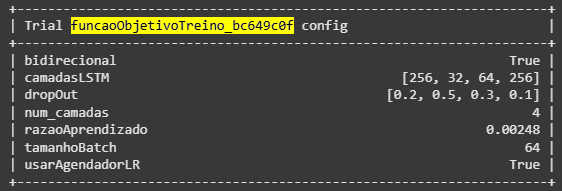

Best model identified in this stage

In [ ]:
carregadorTreino = DataLoader(MeuConjuntoDeDadosECG(xTreino, yTreino),
                              batch_size=64, shuffle=True, num_workers=2)
carregadorValidacao = DataLoader(MeuConjuntoDeDadosECG(xValidacao, yValidacao),
                                 batch_size=64, num_workers=2)

modelo2 = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[256, 32, 64, 256], valoresDeDropout=[0.2,0.5,0.3,0.1],
                  bidirecional=True).to(dispositivo)
print("Arquitetura do Modelo LSTM:")
print(modelo2)

Arquitetura do Modelo LSTM:
RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 256, batch_first=True, bidirectional=True)
    (1): LSTM(512, 32, batch_first=True, bidirectional=True)
    (2): LSTM(64, 64, batch_first=True, bidirectional=True)
    (3): LSTM(128, 256, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): Dropout(p=0.5, inplace=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=512, out_features=5, bias=True)
)


In [ ]:
funcaoPerda = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo2.parameters(), lr=0.00248479)
numEpocas = 40
pacienciaParada = 5
caminhoCheckpoint = '/content/drive/MyDrive/melhor_modelo_lstm2.pth'
historico = treinarModelo(modelo2, carregadorTreino, carregadorValidacao,
                          funcaoPerda, otimizador, numEpocas, dispositivo,
                          pacienciaParada, caminhoCheckpoint, agendarTaxaAprendizado=True, lrInicial=0.00248479)

Época 1: Acc Treino: 0.7314 | Acc Val: 0.8185 | F1 Val: 0.6098
F1 de validação melhorou (0.0000 -> 0.6098).


Época 2: Acc Treino: 0.8889 | Acc Val: 0.8590 | F1 Val: 0.6572
F1 de validação melhorou (0.6098 -> 0.6572).


Época 3: Acc Treino: 0.9337 | Acc Val: 0.9046 | F1 Val: 0.7322
F1 de validação melhorou (0.6572 -> 0.7322).


Época 4: Acc Treino: 0.9562 | Acc Val: 0.9342 | F1 Val: 0.7696
F1 de validação melhorou (0.7322 -> 0.7696).


Época 5: Acc Treino: 0.9705 | Acc Val: 0.9354 | F1 Val: 0.7814
F1 de validação melhorou (0.7696 -> 0.7814).


Época 6: Acc Treino: 0.9797 | Acc Val: 0.9552 | F1 Val: 0.8256
F1 de validação melhorou (0.7814 -> 0.8256).


Época 7: Acc Treino: 0.9824 | Acc Val: 0.9564 | F1 Val: 0.8391
F1 de validação melhorou (0.8256 -> 0.8391).


Época 8: Acc Treino: 0.9838 | Acc Val: 0.9594 | F1 Val: 0.8371


Época 9: Acc Treino: 0.9851 | Acc Val: 0.9563 | F1 Val: 0.8240


Época 10: Acc Treino: 0.9862 | Acc Val: 0.9629 | F1 Val: 0.8479
F1 de validação melhorou (0.8391 -> 0.8479).


Época 11: Acc Treino: 0.9877 | Acc Val: 0.9642 | F1 Val: 0.8517
F1 de validação melhorou (0.8479 -> 0.8517).


Época 12: Acc Treino: 0.9879 | Acc Val: 0.9614 | F1 Val: 0.8479


Época 13: Acc Treino: 0.9890 | Acc Val: 0.9661 | F1 Val: 0.8614
F1 de validação melhorou (0.8517 -> 0.8614).


Época 14: Acc Treino: 0.9898 | Acc Val: 0.9640 | F1 Val: 0.8472


Época 15: Acc Treino: 0.9900 | Acc Val: 0.9659 | F1 Val: 0.8548


Época 16: Acc Treino: 0.9907 | Acc Val: 0.9665 | F1 Val: 0.8594


Época 17: Acc Treino: 0.9904 | Acc Val: 0.9676 | F1 Val: 0.8660
F1 de validação melhorou (0.8614 -> 0.8660).


Época 18: Acc Treino: 0.9914 | Acc Val: 0.9660 | F1 Val: 0.8590


Época 19: Acc Treino: 0.9913 | Acc Val: 0.9677 | F1 Val: 0.8698
F1 de validação melhorou (0.8660 -> 0.8698).


Época 20: Acc Treino: 0.9920 | Acc Val: 0.9667 | F1 Val: 0.8610


Época 21: Acc Treino: 0.9925 | Acc Val: 0.9681 | F1 Val: 0.8648


Época 22: Acc Treino: 0.9923 | Acc Val: 0.9692 | F1 Val: 0.8751
F1 de validação melhorou (0.8698 -> 0.8751).


Época 23: Acc Treino: 0.9927 | Acc Val: 0.9701 | F1 Val: 0.8745


Época 24: Acc Treino: 0.9927 | Acc Val: 0.9692 | F1 Val: 0.8704


Época 25: Acc Treino: 0.9934 | Acc Val: 0.9693 | F1 Val: 0.8730


Época 26: Acc Treino: 0.9929 | Acc Val: 0.9690 | F1 Val: 0.8700


Época 27: Acc Treino: 0.9933 | Acc Val: 0.9692 | F1 Val: 0.8704
Parada antecipada!
Carregando melhor modelo de '/content/drive/MyDrive/melhor_modelo_lstm2.pth'


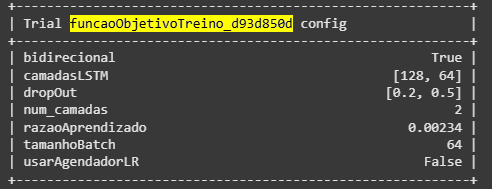

In [ ]:
carregadorTreino = DataLoader(MeuConjuntoDeDadosECG(xTreino, yTreino),
                              batch_size=64, shuffle=True, num_workers=2)
carregadorValidacao = DataLoader(MeuConjuntoDeDadosECG(xValidacao, yValidacao),
                                 batch_size=64, num_workers=2)

modelo3 = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[128, 64], valoresDeDropout=[0.2, 0.5],
                  bidirecional=True).to(dispositivo)
print("Arquitetura do Modelo LSTM:")
print(modelo3)

Arquitetura do Modelo LSTM:
RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 128, batch_first=True, bidirectional=True)
    (1): LSTM(256, 64, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): Dropout(p=0.5, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=128, out_features=5, bias=True)
)


In [ ]:
funcaoPerda = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo3.parameters(), lr=0.00234)
numEpocas = 40
pacienciaParada = 5
caminhoCheckpoint = 'melhor_modelo_lstm3.pth'
historico = treinarModelo(modelo3, carregadorTreino, carregadorValidacao,
                          funcaoPerda, otimizador, numEpocas, dispositivo,
                          pacienciaParada, caminhoCheckpoint, agendarTaxaAprendizado=False, lrInicial=0.00234)

Época 1: Acc Treino: 0.5919 | Acc Val: 0.5826 | F1 Val: 0.4849
F1 de validação melhorou (0.0000 -> 0.4849).


Época 2: Acc Treino: 0.8240 | Acc Val: 0.8108 | F1 Val: 0.6094
F1 de validação melhorou (0.4849 -> 0.6094).


Época 3: Acc Treino: 0.8745 | Acc Val: 0.8281 | F1 Val: 0.6303
F1 de validação melhorou (0.6094 -> 0.6303).


Época 4: Acc Treino: 0.8956 | Acc Val: 0.8755 | F1 Val: 0.6942
F1 de validação melhorou (0.6303 -> 0.6942).


Época 5: Acc Treino: 0.9193 | Acc Val: 0.8993 | F1 Val: 0.7391
F1 de validação melhorou (0.6942 -> 0.7391).


Época 6: Acc Treino: 0.9313 | Acc Val: 0.9043 | F1 Val: 0.7279


Época 7: Acc Treino: 0.9431 | Acc Val: 0.8693 | F1 Val: 0.7018


Época 8: Acc Treino: 0.9486 | Acc Val: 0.9205 | F1 Val: 0.7460
F1 de validação melhorou (0.7391 -> 0.7460).


Época 9: Acc Treino: 0.9559 | Acc Val: 0.8567 | F1 Val: 0.6688


Época 10: Acc Treino: 0.9596 | Acc Val: 0.9312 | F1 Val: 0.7746
F1 de validação melhorou (0.7460 -> 0.7746).


Época 11: Acc Treino: 0.9645 | Acc Val: 0.9432 | F1 Val: 0.7954
F1 de validação melhorou (0.7746 -> 0.7954).


Época 12: Acc Treino: 0.9672 | Acc Val: 0.9473 | F1 Val: 0.8100
F1 de validação melhorou (0.7954 -> 0.8100).


Época 13: Acc Treino: 0.9691 | Acc Val: 0.9412 | F1 Val: 0.8011


Época 14: Acc Treino: 0.9738 | Acc Val: 0.9484 | F1 Val: 0.8028


Época 15: Acc Treino: 0.9753 | Acc Val: 0.9465 | F1 Val: 0.7898


Época 16: Acc Treino: 0.9769 | Acc Val: 0.9439 | F1 Val: 0.7892


Época 17: Acc Treino: 0.9759 | Acc Val: 0.9571 | F1 Val: 0.8364
F1 de validação melhorou (0.8100 -> 0.8364).


Época 18: Acc Treino: 0.9807 | Acc Val: 0.9487 | F1 Val: 0.8161


Época 19: Acc Treino: 0.9812 | Acc Val: 0.9644 | F1 Val: 0.8450
F1 de validação melhorou (0.8364 -> 0.8450).


Época 20: Acc Treino: 0.9803 | Acc Val: 0.9599 | F1 Val: 0.8461
F1 de validação melhorou (0.8450 -> 0.8461).


Época 21: Acc Treino: 0.9836 | Acc Val: 0.9595 | F1 Val: 0.8281


Época 22: Acc Treino: 0.9826 | Acc Val: 0.9531 | F1 Val: 0.8040


Época 23: Acc Treino: 0.9856 | Acc Val: 0.9554 | F1 Val: 0.8295


Época 24: Acc Treino: 0.9846 | Acc Val: 0.9385 | F1 Val: 0.8024


Época 25: Acc Treino: 0.9845 | Acc Val: 0.9461 | F1 Val: 0.8092
Parada antecipada!
Carregando melhor modelo de 'melhor_modelo_lstm3.pth'


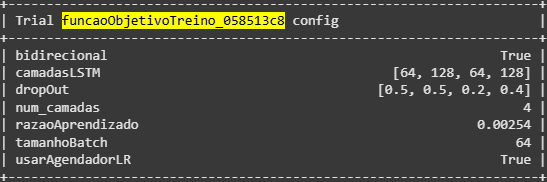

In [ ]:
carregadorTreino = DataLoader(MeuConjuntoDeDadosECG(xTreino, yTreino),
                              batch_size=64, shuffle=True, num_workers=2)
carregadorValidacao = DataLoader(MeuConjuntoDeDadosECG(xValidacao, yValidacao),
                                 batch_size=64, num_workers=2)

modelo4 = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[64,128,64,128], valoresDeDropout=[0.5,0.5,0.2,0.4],
                  bidirecional=True).to(dispositivo)
print("Arquitetura do Modelo LSTM:")
print(modelo4)

Arquitetura do Modelo LSTM:
RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 64, batch_first=True, bidirectional=True)
    (1): LSTM(128, 128, batch_first=True, bidirectional=True)
    (2): LSTM(256, 64, batch_first=True, bidirectional=True)
    (3): LSTM(128, 128, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0-1): 2 x Dropout(p=0.5, inplace=False)
    (2): Dropout(p=0.2, inplace=False)
    (3): Dropout(p=0.4, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=256, out_features=5, bias=True)
)


In [ ]:
funcaoPerda = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo4.parameters(), lr=0.00254)
numEpocas = 40
pacienciaParada = 5
caminhoCheckpoint = '/content/drive/MyDrive/melhor_modelo_lstm4.pth'
historico = treinarModelo(modelo4, carregadorTreino, carregadorValidacao,
                          funcaoPerda, otimizador, numEpocas, dispositivo,
                          pacienciaParada, caminhoCheckpoint, agendarTaxaAprendizado=True, lrInicial=0.00254)

Época 1: Acc Treino: 0.5048 | Acc Val: 0.6187 | F1 Val: 0.4245
F1 de validação melhorou (0.0000 -> 0.4245).


Época 2: Acc Treino: 0.8059 | Acc Val: 0.8397 | F1 Val: 0.6307
F1 de validação melhorou (0.4245 -> 0.6307).


Época 3: Acc Treino: 0.8591 | Acc Val: 0.7942 | F1 Val: 0.5885


Época 4: Acc Treino: 0.8900 | Acc Val: 0.8535 | F1 Val: 0.6535
F1 de validação melhorou (0.6307 -> 0.6535).


Época 5: Acc Treino: 0.9164 | Acc Val: 0.8764 | F1 Val: 0.6760
F1 de validação melhorou (0.6535 -> 0.6760).


Época 6: Acc Treino: 0.9351 | Acc Val: 0.8958 | F1 Val: 0.7004
F1 de validação melhorou (0.6760 -> 0.7004).


Época 7: Acc Treino: 0.9391 | Acc Val: 0.9035 | F1 Val: 0.7112
F1 de validação melhorou (0.7004 -> 0.7112).


Época 8: Acc Treino: 0.9423 | Acc Val: 0.9056 | F1 Val: 0.7142
F1 de validação melhorou (0.7112 -> 0.7142).


Época 9: Acc Treino: 0.9450 | Acc Val: 0.8909 | F1 Val: 0.6962


Época 10: Acc Treino: 0.9478 | Acc Val: 0.9025 | F1 Val: 0.7118


Época 11: Acc Treino: 0.9502 | Acc Val: 0.9078 | F1 Val: 0.7215
F1 de validação melhorou (0.7142 -> 0.7215).


Época 12: Acc Treino: 0.9519 | Acc Val: 0.9093 | F1 Val: 0.7214


Época 13: Acc Treino: 0.9536 | Acc Val: 0.9119 | F1 Val: 0.7285
F1 de validação melhorou (0.7215 -> 0.7285).


Época 14: Acc Treino: 0.9556 | Acc Val: 0.9190 | F1 Val: 0.7380
F1 de validação melhorou (0.7285 -> 0.7380).


Época 15: Acc Treino: 0.9564 | Acc Val: 0.9149 | F1 Val: 0.7320


Época 16: Acc Treino: 0.9584 | Acc Val: 0.9109 | F1 Val: 0.7258


Época 17: Acc Treino: 0.9588 | Acc Val: 0.9142 | F1 Val: 0.7310


Época 18: Acc Treino: 0.9596 | Acc Val: 0.9242 | F1 Val: 0.7505
F1 de validação melhorou (0.7380 -> 0.7505).


Época 19: Acc Treino: 0.9615 | Acc Val: 0.9198 | F1 Val: 0.7413


Época 20: Acc Treino: 0.9620 | Acc Val: 0.9206 | F1 Val: 0.7411


Época 21: Acc Treino: 0.9627 | Acc Val: 0.9204 | F1 Val: 0.7420


Época 22: Acc Treino: 0.9640 | Acc Val: 0.9210 | F1 Val: 0.7453


Época 23: Acc Treino: 0.9626 | Acc Val: 0.9258 | F1 Val: 0.7506
F1 de validação melhorou (0.7505 -> 0.7506).


Época 24: Acc Treino: 0.9643 | Acc Val: 0.9202 | F1 Val: 0.7434


Época 25: Acc Treino: 0.9656 | Acc Val: 0.9256 | F1 Val: 0.7512
F1 de validação melhorou (0.7506 -> 0.7512).


Época 26: Acc Treino: 0.9655 | Acc Val: 0.9234 | F1 Val: 0.7493


Época 27: Acc Treino: 0.9658 | Acc Val: 0.9258 | F1 Val: 0.7528
F1 de validação melhorou (0.7512 -> 0.7528).


Época 28: Acc Treino: 0.9664 | Acc Val: 0.9239 | F1 Val: 0.7466


Época 29: Acc Treino: 0.9675 | Acc Val: 0.9273 | F1 Val: 0.7552
F1 de validação melhorou (0.7528 -> 0.7552).


Época 30: Acc Treino: 0.9676 | Acc Val: 0.9235 | F1 Val: 0.7502


Época 31: Acc Treino: 0.9681 | Acc Val: 0.9263 | F1 Val: 0.7533


Época 32: Acc Treino: 0.9689 | Acc Val: 0.9243 | F1 Val: 0.7493


Época 33: Acc Treino: 0.9680 | Acc Val: 0.9274 | F1 Val: 0.7567
F1 de validação melhorou (0.7552 -> 0.7567).


Época 34: Acc Treino: 0.9683 | Acc Val: 0.9315 | F1 Val: 0.7648
F1 de validação melhorou (0.7567 -> 0.7648).


Época 35: Acc Treino: 0.9695 | Acc Val: 0.9284 | F1 Val: 0.7589


Época 36: Acc Treino: 0.9688 | Acc Val: 0.9316 | F1 Val: 0.7676
F1 de validação melhorou (0.7648 -> 0.7676).


Época 37: Acc Treino: 0.9699 | Acc Val: 0.9311 | F1 Val: 0.7649


Época 38: Acc Treino: 0.9703 | Acc Val: 0.9294 | F1 Val: 0.7602


Época 39: Acc Treino: 0.9704 | Acc Val: 0.9332 | F1 Val: 0.7712
F1 de validação melhorou (0.7676 -> 0.7712).


Época 40: Acc Treino: 0.9706 | Acc Val: 0.9341 | F1 Val: 0.7696
Carregando melhor modelo de '/content/drive/MyDrive/melhor_modelo_lstm4.pth'


Based on our visual analysis, we hypothesize that the features beyond the 140th time step offer little discriminative value. While this is currently an informal observation, it requires formal validation. A direct way to test this is to train a new model using only this truncated feature set. In scenarios where retraining is computationally expensive, alternative methods like feature importance analysis should be considered to validate such heuristics more efficiently

In [ ]:
dadosTreinoBrutoMod = pd.concat([dadosTreinoBruto.iloc[:,:140], dadosTreinoBruto.iloc[:,-1]], axis=1)

In [ ]:
dadosParaTreinoMod, dadosParaValidacaoMod = train_test_split(
    dadosTreinoBrutoMod,
    test_size=0.2,
    random_state=42,
    stratify=dadosTreinoBruto[187]
)

In [ ]:
dadosTreinoBalanceadosMod = balancearDados(dadosParaTreinoMod)
xTreinoMod = dadosTreinoBalanceadosMod.drop(187, axis=1).values
yTreinoMod = dadosTreinoBalanceadosMod[187].values

xValidacaoMod = dadosParaValidacaoMod.drop(187, axis=1).values
yValidacaoMod = dadosParaValidacaoMod[187].values

xTesteMod = dadosTesteBruto.drop(187, axis=1).values
yTesteMod = dadosTesteBruto[187].values

In [ ]:
conjuntoDeTreino = MeuConjuntoDeDadosECG(xTreinoMod, yTreinoMod)
conjuntoDeValidacao = MeuConjuntoDeDadosECG(xValidacaoMod, yValidacaoMod)

In [ ]:
opcoesDeNeuronios = [16, 32, 64, 128, 256]
opcoesDeDropout = [0.1, 0.2, 0.3, 0.4, 0.5]
espacoDeBusca = {
    "tamanhoBatch": tune.choice([64, 128]),
    "razaoAprendizado": tune.loguniform(1e-4, 1e-2),
    "bidirecional": tune.choice([True, False]),
    "num_camadas": tune.randint(1, 5),
    "camadasLSTM": tune.sample_from(lambda spec: [random.choice(opcoesDeNeuronios) for _ in range(spec.config.num_camadas)]),
    "dropOut": tune.sample_from(lambda spec: [random.choice(opcoesDeDropout) for _ in range(spec.config.num_camadas)]),
    "usarAgendadorLR": tune.choice([True, False])
}
algoritmoDeBusca = OptunaSearch(metric="f1_validacao", mode="max")
agendador = ASHAScheduler(metric="f1_validacao", mode="max", max_t=15, grace_period=10, reduction_factor=2)
relator = CLIReporter(metric_columns=["f1_validacao", "acuracia_validacao", "training_iteration"])
if ray.is_initialized(): ray.shutdown()
ray.init(ignore_reinit_error=True)

2025-09-05 16:46:32,679	INFO worker.py:1951 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.12.11', ray_version='2.49.1', ray_commit='c057f1ea836f3e93f110e895029caa32136fc156')

The hyperparameter search was configured to run for a total of 100 trials. However, due to computational and time constraints, the process was stopped early, resulting in a smaller but still insightful number of completed evaluations

In [ ]:
analise = tune.run(
    funcaoObjetivoTreino,
    config=espacoDeBusca,
    num_samples=100,
    search_alg=algoritmoDeBusca,
    scheduler=agendador,
    progress_reporter=relator,
    name="otimizacao_avancada_ecg",
    resources_per_trial={"cpu": 2, "gpu": 1 if torch.cuda.is_available() else 0},
    keep_checkpoints_num=1,
    checkpoint_score_attr="f1_validacao"
)

[I 2025-09-05 16:46:42,042] A new study created in memory with name: optuna
2025-09-05 16:46:42,348	WARNING tune.py:902 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+------------------------------------------------------------+
| Configuration for experiment     otimizacao_avancada_ecg   |
+------------------------------------------------------------+
| Search algorithm                 SearchGenerator           |
| Scheduler                        AsyncHyperBandScheduler   |
| Number of trials                 100                       |
+------------------------------------------------------------+

View detailed results here: /root/ray_results/otimizacao_avancada_ecg
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-09-05_16-46-26_265741_2599/artifacts/2025-09-05_16-46-42/otimizacao_avancada_ecg/driver_artifacts`


2025-09-05 16:46:42,562	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 16:46:42,563	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 1 PENDING
Current time: 2025-09-05 16:46:43. Total running time: 1s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR   |
+-------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_628b45d2   PENDING                64           0.00246323   True                         1   False             |
+-------------------------------------------------------------------------------------------------------------------------------------+
(raylet) Warning: The actor ImplicitFunc is very large (50 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: 

2025-09-05 16:46:51,797	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 16:46:51,800	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 16:47:07,598	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely supp


Trial funcaoObjetivoTreino_628b45d2 finished iteration 1 at 2025-09-05 16:47:07. Total running time: 25s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_628b45d2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        16.01553 |
| time_total_s                                            16.01553 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.63115 |
| f1_validacao                                             0.48799 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_628b45d2 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_628b45d2_1_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dro

(funcaoObjetivoTreino pid=3782) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_628b45d2_1_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizado_2025-09-05_16-46-42/checkpoint_000000)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:47:13. Total running time: 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_628b45d2   RUNNING                64           0.00246323   True                         1   False                    1            16.0155         0.487993               0.631146 |
| funcaoObj

(funcaoObjetivoTreino pid=3782) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_628b45d2_1_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizado_2025-09-05_16-46-42/checkpoint_000001)



Trial funcaoObjetivoTreino_628b45d2 finished iteration 3 at 2025-09-05 16:47:24. Total running time: 42s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_628b45d2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         8.63643 |
| time_total_s                                            32.88838 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.91851 |
| f1_validacao                                             0.72914 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_628b45d2 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_628b45d2_1_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dro

(funcaoObjetivoTreino pid=3782) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_628b45d2_1_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizado_2025-09-05_16-46-42/checkpoint_000002)



Trial funcaoObjetivoTreino_628b45d2 finished iteration 4 at 2025-09-05 16:47:32. Total running time: 50s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_628b45d2 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               8.18588 |
| time_total_s                                   41.0743 |
| training_iteration                                   4 |
| acuracia_validacao                             0.88322 |
| f1_validacao                                   0.70385 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_628b45d2 finished iteration 5 at 2025-09-05 16:47:41. Total running time: 59s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_628b45d2 result                       |
+-----------------------------------------------------------

(funcaoObjetivoTreino pid=3782) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_628b45d2_1_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizado_2025-09-05_16-46-42/checkpoint_000003)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:47:43. Total running time: 1min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_628b45d2   RUNNING                64           0.00246323   True                         1   False                    5            49.8259         0.737381               0.912798 |
| funca

(funcaoObjetivoTreino pid=3782) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_628b45d2_1_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizado_2025-09-05_16-46-42/checkpoint_000004)



Trial funcaoObjetivoTreino_628b45d2 finished iteration 8 at 2025-09-05 16:48:07. Total running time: 1min 25s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_628b45d2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         8.77193 |
| time_total_s                                            75.78455 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.93992 |
| f1_validacao                                             0.78848 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_628b45d2 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_628b45d2_1_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=3782) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_628b45d2_1_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizado_2025-09-05_16-46-42/checkpoint_000005)



Trial status: 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:48:13. Total running time: 1min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status       tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_628b45d2   RUNNING                64           0.00246323   True                         1   False                    8            75.7845         0.788484               0.939923 |
| func

2025-09-05 16:49:20,725	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 16:49:20,726	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_abfb79b7 finished iteration 1 at 2025-09-05 16:49:37. Total running time: 2min 55s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_abfb79b7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        17.22601 |
| time_total_s                                            17.22601 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.16641 |
| f1_validacao                                              0.2403 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_abfb79b7 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=4738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_16-46-52/checkpoint_000000)



Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:49:44. Total running time: 3min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_abfb79b7   RUNNING                 128           0.00515567   False                        4   True                     1             17.226         0.240302          

(funcaoObjetivoTreino pid=4738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_16-46-52/checkpoint_000001)



Trial funcaoObjetivoTreino_abfb79b7 finished iteration 3 at 2025-09-05 16:50:08. Total running time: 3min 26s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_abfb79b7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        15.43752 |
| time_total_s                                            48.02642 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.47307 |
| f1_validacao                                             0.43385 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_abfb79b7 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=4738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_16-46-52/checkpoint_000002)



Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:50:14. Total running time: 3min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_abfb79b7   RUNNING                 128           0.00515567   False                        4   True                     3            48.0264         0.433846         

(funcaoObjetivoTreino pid=4738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_16-46-52/checkpoint_000003)



Trial funcaoObjetivoTreino_abfb79b7 finished iteration 5 at 2025-09-05 16:50:39. Total running time: 3min 57s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_abfb79b7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        15.40996 |
| time_total_s                                            78.93486 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.60413 |
| f1_validacao                                             0.50542 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_abfb79b7 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=4738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_16-46-52/checkpoint_000004)



Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:50:44. Total running time: 4min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_abfb79b7   RUNNING                 128           0.00515567   False                        4   True                     5            78.9349         0.505421          

(funcaoObjetivoTreino pid=4738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_16-46-52/checkpoint_000005)



Trial funcaoObjetivoTreino_abfb79b7 finished iteration 7 at 2025-09-05 16:51:10. Total running time: 4min 27s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_abfb79b7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        15.25958 |
| time_total_s                                           109.60776 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.66604 |
| f1_validacao                                              0.5229 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_abfb79b7 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=4738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_16-46-52/checkpoint_000006)



Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:51:14. Total running time: 4min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_abfb79b7   RUNNING                 128           0.00515567   False                        4   True                     7            109.608         0.522903         

(funcaoObjetivoTreino pid=4738) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_abfb79b7_2_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_16-46-52/checkpoint_000007)



Trial funcaoObjetivoTreino_abfb79b7 finished iteration 9 at 2025-09-05 16:51:40. Total running time: 4min 58s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_abfb79b7 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               15.2678 |
| time_total_s                                   140.119 |
| training_iteration                                   9 |
| acuracia_validacao                             0.65627 |
| f1_validacao                                   0.52076 |
+--------------------------------------------------------+

Trial status: 1 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:51:44. Total running time: 5min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------------------

2025-09-05 16:52:07,584	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 16:52:07,585	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:52:14. Total running time: 5min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_eadfb1bb   RUNNING                 128           0.00527991   False                        3   True                                                                   

2025-09-05 16:52:26,234	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_eadfb1bb finished iteration 1 at 2025-09-05 16:52:26. Total running time: 5min 43s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_eadfb1bb result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         18.8809 |
| time_total_s                                             18.8809 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.02541 |
| f1_validacao                                             0.00991 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_eadfb1bb saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_eadfb1bb_3_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=5677) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_eadfb1bb_3_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_16-49-21/checkpoint_000000)



Trial funcaoObjetivoTreino_eadfb1bb finished iteration 2 at 2025-09-05 16:52:43. Total running time: 6min 1s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_eadfb1bb result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        17.39786 |
| time_total_s                                            36.27876 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.82765 |
| f1_validacao                                             0.18114 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_eadfb1bb saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_eadfb1bb_3_bidirecional=False,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=5677) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_eadfb1bb_3_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_16-49-21/checkpoint_000001)



Trial status: 2 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:52:44. Total running time: 6min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_eadfb1bb   RUNNING                 128           0.00527991   False                        3   True                     2            36.2788         0.18114           

2025-09-05 16:55:10,128	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 16:55:10,131	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:55:14. Total running time: 8min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a7dae904   RUNNING                 128          0.00334784    True                         3   False                                                                  

(funcaoObjetivoTreino pid=6683) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a7dae904_4_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-09-05_16-52-08/checkpoint_000000)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:56:14. Total running time: 9min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a7dae904   RUNNING                 128          0.00334784    True                         3   False                    1            42.8404       0.617933           

(funcaoObjetivoTreino pid=6683) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a7dae904_4_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-09-05_16-52-08/checkpoint_000001)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 16:58:45. Total running time: 12min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a7dae904   RUNNING                 128          0.00334784    True                         3   False                    5            201.582       0.621417           

(funcaoObjetivoTreino pid=6683) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a7dae904_4_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-09-05_16-52-08/checkpoint_000002)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:02:45. Total running time: 16min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a7dae904   RUNNING                 128          0.00334784    True                         3   False                   11            441.578       0.637198           

2025-09-05 17:03:11,830	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a7dae904 finished iteration 12 at 2025-09-05 17:03:11. Total running time: 16min 29s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a7dae904 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        40.29772 |
| time_total_s                                           481.87547 |
| training_iteration                                            12 |
| acuracia_validacao                                        0.8469 |
| f1_validacao                                             0.65312 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a7dae904 saved a checkpoint for iteration 12 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a7dae904_4_bidirecional=True,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=6683) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a7dae904_4_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-09-05_16-52-08/checkpoint_000003)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:03:15. Total running time: 16min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a7dae904   RUNNING                 128          0.00334784    True                         3   False                   12            481.875       0.653121          

2025-09-05 17:03:52,022	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a7dae904 finished iteration 13 at 2025-09-05 17:03:52. Total running time: 17min 9s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a7dae904 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        40.18053 |
| time_total_s                                           522.05601 |
| training_iteration                                            13 |
| acuracia_validacao                                       0.87534 |
| f1_validacao                                             0.68322 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a7dae904 saved a checkpoint for iteration 13 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a7dae904_4_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=6683) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a7dae904_4_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-09-05_16-52-08/checkpoint_000004)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:04:15. Total running time: 17min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a7dae904   RUNNING                 128          0.00334784    True                         3   False                   13            522.056       0.68322           

(funcaoObjetivoTreino pid=6683) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a7dae904_4_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizado_2025-09-05_16-52-08/checkpoint_000005)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:04:45. Total running time: 18min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a7dae904   RUNNING                 128          0.00334784    True                         3   False                   14            562.112       0.725658           

2025-09-05 17:05:22,376	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:05:22,376	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_00d114f2 finished iteration 1 at 2025-09-05 17:05:43. Total running time: 19min 0s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_00d114f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        21.13031 |
| time_total_s                                            21.13031 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.41991 |
| f1_validacao                                             0.28016 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_00d114f2 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000000)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:05:45. Total running time: 19min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_00d114f2   RUNNING                  64          0.000498373   False                        2   False                    1            21.1303       0.280157           

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000001)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:06:15. Total running time: 19min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_00d114f2   RUNNING                  64          0.000498373   False                        2   False                    2            39.8718       0.326719          

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000002)
2025-09-05 17:06:57,065	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_00d114f2 finished iteration 5 at 2025-09-05 17:06:57. Total running time: 20min 14s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_00d114f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        18.14648 |
| time_total_s                                             94.8853 |
| training_iteration                                             5 |
| acuracia_validacao                                        0.6866 |
| f1_validacao                                             0.49155 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_00d114f2 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000003)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:07:15. Total running time: 20min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_00d114f2   RUNNING                  64          0.000498373   False                        2   False                    6            113.463       0.568115          

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000004)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:07:46. Total running time: 21min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_00d114f2   RUNNING                  64          0.000498373   False                        2   False                    7            131.854       0.584566           

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000005)



Trial funcaoObjetivoTreino_00d114f2 finished iteration 9 at 2025-09-05 17:08:10. Total running time: 21min 28s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_00d114f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                         18.5337 |
| time_total_s                                            168.6809 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.83519 |
| f1_validacao                                             0.62046 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_00d114f2 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000006)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:08:16. Total running time: 21min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_00d114f2   RUNNING                  64          0.000498373   False                        2   False                    9            168.681       0.620461          

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000007)



Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:08:46. Total running time: 22min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_00d114f2   RUNNING                  64          0.000498373   False                        2   False                   10            187.022       0.621043           

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000008)



Trial funcaoObjetivoTreino_00d114f2 finished iteration 12 at 2025-09-05 17:09:06. Total running time: 22min 23s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_00d114f2 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               18.4869 |
| time_total_s                                   223.786 |
| training_iteration                                  12 |
| acuracia_validacao                             0.85032 |
| f1_validacao                                   0.65904 |
+--------------------------------------------------------+

Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:09:16. Total running time: 22min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000009)



Trial funcaoObjetivoTreino_00d114f2 finished iteration 14 at 2025-09-05 17:09:42. Total running time: 23min 0s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_00d114f2 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               18.3048 |
| time_total_s                                   260.568 |
| training_iteration                                  14 |
| acuracia_validacao                             0.88527 |
| f1_validacao                                   0.69478 |
+--------------------------------------------------------+

Trial status: 4 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:09:46. Total running time: 23min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=9576) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_00d114f2_5_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_16-55-10/checkpoint_000010)



Trial funcaoObjetivoTreino_3e1e62f2 started with configuration:
+-----------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 config                |
+-----------------------------------------------------------+
| bidirecional                                         True |
| camadasLSTM                                      [64, 64] |
| dropOut                                        [0.1, 0.4] |
| num_camadas                                             2 |
| razaoAprendizado                                  0.00012 |
| tamanhoBatch                                          128 |
| usarAgendadorLR                                     False |
+-----------------------------------------------------------+


2025-09-05 17:10:12,572	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:10:12,573	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:10:16. Total running time: 23min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_3e1e62f2   RUNNING                 128          0.000119378   True                         2   False                                                                 

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000000)



Trial funcaoObjetivoTreino_3e1e62f2 finished iteration 2 at 2025-09-05 17:10:25. Total running time: 23min 43s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         5.33064 |
| time_total_s                                            13.42253 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.62064 |
| f1_validacao                                             0.42732 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_3e1e62f2 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000001)



Trial funcaoObjetivoTreino_3e1e62f2 finished iteration 3 at 2025-09-05 17:10:31. Total running time: 23min 49s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         5.78115 |
| time_total_s                                            19.20369 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.70099 |
| f1_validacao                                             0.49153 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_3e1e62f2 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000002)



Trial funcaoObjetivoTreino_3e1e62f2 finished iteration 4 at 2025-09-05 17:10:37. Total running time: 23min 55s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         5.84821 |
| time_total_s                                             25.0519 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.71572 |
| f1_validacao                                             0.50283 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_3e1e62f2 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000003)



Trial funcaoObjetivoTreino_3e1e62f2 finished iteration 5 at 2025-09-05 17:10:42. Total running time: 24min 0s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         5.49845 |
| time_total_s                                            30.55035 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.71652 |
| f1_validacao                                             0.50326 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_3e1e62f2 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000004)



Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:10:46. Total running time: 24min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_3e1e62f2   RUNNING                 128          0.000119378   True                         2   False                    5            30.5503       0.503262           

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000005)



Trial funcaoObjetivoTreino_3e1e62f2 finished iteration 7 at 2025-09-05 17:10:54. Total running time: 24min 12s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                         5.45557 |
| time_total_s                                            42.08354 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.76723 |
| f1_validacao                                             0.55161 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_3e1e62f2 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000006)



Trial funcaoObjetivoTreino_3e1e62f2 finished iteration 8 at 2025-09-05 17:11:00. Total running time: 24min 17s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         5.88751 |
| time_total_s                                            47.97105 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.79738 |
| f1_validacao                                             0.57628 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_3e1e62f2 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000007)



Trial funcaoObjetivoTreino_3e1e62f2 finished iteration 9 at 2025-09-05 17:11:06. Total running time: 24min 23s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                         5.75703 |
| time_total_s                                            53.72808 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.80863 |
| f1_validacao                                             0.59852 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_3e1e62f2 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000008)



Trial funcaoObjetivoTreino_3e1e62f2 finished iteration 10 at 2025-09-05 17:11:11. Total running time: 24min 29s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000009 |
| time_this_iter_s                                         5.37632 |
| time_total_s                                            59.10441 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.82331 |
| f1_validacao                                             0.60602 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_3e1e62f2 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000009)



Trial status: 5 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:11:16. Total running time: 24min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_3e1e62f2   RUNNING                 128          0.000119378   True                         2   False                   10            59.1044       0.606018          

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000010)



Trial funcaoObjetivoTreino_3e1e62f2 finished iteration 14 at 2025-09-05 17:11:34. Total running time: 24min 51s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               5.75214 |
| time_total_s                                   81.9087 |
| training_iteration                                  14 |
| acuracia_validacao                             0.80201 |
| f1_validacao                                   0.59479 |
+--------------------------------------------------------+


2025-09-05 17:11:39,668	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_3e1e62f2 finished iteration 15 at 2025-09-05 17:11:39. Total running time: 24min 57s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_3e1e62f2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000011 |
| time_this_iter_s                                         5.35083 |
| time_total_s                                            87.25955 |
| training_iteration                                            15 |
| acuracia_validacao                                       0.84376 |
| f1_validacao                                             0.62788 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_3e1e62f2 saved a checkpoint for iteration 15 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=11114) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3e1e62f2_6_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizado_2025-09-05_17-05-22/checkpoint_000011)



Trial status: 6 TERMINATED | 1 PENDING
Current time: 2025-09-05 17:11:46. Total running time: 25min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_628b45d2   TERMINATED               64          0.00246323    True                         1   False                   15           137.161        0.608799               0.806293

2025-09-05 17:11:51,428	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:11:51,434	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:12:16. Total running time: 25min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_3f250175   RUNNING                 128          0.00976336    False                        4   False                                                                 

(funcaoObjetivoTreino pid=11848) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3f250175_7_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-10-13/checkpoint_000000)



Trial funcaoObjetivoTreino_3f250175 finished iteration 2 at 2025-09-05 17:12:41. Total running time: 25min 58s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_3f250175 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               24.3163 |
| time_total_s                                   49.9642 |
| training_iteration                                   2 |
| acuracia_validacao                             0.00731 |
| f1_validacao                                    0.0029 |
+--------------------------------------------------------+

Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:12:46. Total running time: 26min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=11848) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3f250175_7_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-10-13/checkpoint_000001)
2025-09-05 17:13:28,048	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_3f250175 finished iteration 4 at 2025-09-05 17:13:28. Total running time: 26min 45s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_3f250175 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        23.40352 |
| time_total_s                                            96.84825 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.06613 |
| f1_validacao                                             0.02481 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_3f250175 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_3f250175_7_bidirecional=False,camadasLSTM=fn_ph_e6b59

2025-09-05 17:16:01,601	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:16:01,612	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_c81b4f09 finished iteration 1 at 2025-09-05 17:16:08. Total running time: 29min 25s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c81b4f09 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         6.75036 |
| time_total_s                                             6.75036 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.46342 |
| f1_validacao                                             0.29477 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c81b4f09 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-11-51/checkpoint_000000)



Trial funcaoObjetivoTreino_c81b4f09 finished iteration 2 at 2025-09-05 17:16:14. Total running time: 29min 31s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c81b4f09 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         5.87954 |
| time_total_s                                             12.6299 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.54177 |
| f1_validacao                                             0.36976 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c81b4f09 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-11-51/checkpoint_000001)



Trial status: 7 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:16:16. Total running time: 29min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c81b4f09   RUNNING                 128          0.00212102    False                        4   False                    2            12.6299       0.369758          

2025-09-05 17:16:24,256	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c81b4f09 finished iteration 4 at 2025-09-05 17:16:24. Total running time: 29min 41s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c81b4f09 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         5.56936 |
| time_total_s                                            22.85538 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.63948 |
| f1_validacao                                             0.46789 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c81b4f09 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-11-51/checkpoint_000002)



Trial funcaoObjetivoTreino_c81b4f09 finished iteration 5 at 2025-09-05 17:16:29. Total running time: 29min 47s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c81b4f09 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         5.23724 |
| time_total_s                                            28.09263 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.64725 |
| f1_validacao                                             0.47525 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c81b4f09 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-11-51/checkpoint_000003)
2025-09-05 17:16:34,324	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c81b4f09 finished iteration 6 at 2025-09-05 17:16:34. Total running time: 29min 51s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c81b4f09 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         4.82428 |
| time_total_s                                            32.91691 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.73422 |
| f1_validacao                                              0.5375 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c81b4f09 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-11-51/checkpoint_000004)



Trial funcaoObjetivoTreino_c81b4f09 finished iteration 7 at 2025-09-05 17:16:40. Total running time: 29min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c81b4f09 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         6.12251 |
| time_total_s                                            39.03943 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.79116 |
| f1_validacao                                             0.57853 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c81b4f09 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-11-51/checkpoint_000005)
2025-09-05 17:16:45,179	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c81b4f09 finished iteration 8 at 2025-09-05 17:16:45. Total running time: 30min 2s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c81b4f09 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                         4.71842 |
| time_total_s                                            43.75784 |
| training_iteration                                             8 |
| acuracia_validacao                                        0.8457 |
| f1_validacao                                             0.62788 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c81b4f09 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=13128) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c81b4f09_8_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-11-51/checkpoint_000006)



Trial status: 7 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:16:46. Total running time: 30min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c81b4f09   RUNNING                 128          0.00212102    False                        4   False                    8            43.7578       0.627883           

2025-09-05 17:17:31,456	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:17:31,457	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:17:47. Total running time: 31min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ea646f23   RUNNING                  64          0.000584085   False                        3   False                                                                  

2025-09-05 17:17:50,229	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ea646f23 finished iteration 1 at 2025-09-05 17:17:50. Total running time: 31min 7s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ea646f23 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        18.98951 |
| time_total_s                                            18.98951 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.38227 |
| f1_validacao                                             0.26374 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ea646f23 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=13835) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-16-02/checkpoint_000000)



Trial funcaoObjetivoTreino_ea646f23 finished iteration 2 at 2025-09-05 17:18:06. Total running time: 31min 24s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ea646f23 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               16.6422 |
| time_total_s                                   35.6317 |
| training_iteration                                   2 |
| acuracia_validacao                             0.33916 |
| f1_validacao                                   0.24076 |
+--------------------------------------------------------+

Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:18:17. Total running time: 31min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------

2025-09-05 17:18:23,206	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ea646f23 finished iteration 3 at 2025-09-05 17:18:23. Total running time: 31min 40s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ea646f23 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        16.31188 |
| time_total_s                                            51.94364 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.65079 |
| f1_validacao                                             0.48828 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ea646f23 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13835) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-16-02/checkpoint_000001)



Trial funcaoObjetivoTreino_ea646f23 finished iteration 4 at 2025-09-05 17:18:39. Total running time: 31min 56s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ea646f23 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        16.13651 |
| time_total_s                                            68.08015 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.72252 |
| f1_validacao                                             0.52433 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ea646f23 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=13835) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-16-02/checkpoint_000002)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:18:47. Total running time: 32min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ea646f23   RUNNING                  64          0.000584085   False                        3   False                    4            68.0802       0.524327           

(funcaoObjetivoTreino pid=13835) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-16-02/checkpoint_000003)



Trial funcaoObjetivoTreino_ea646f23 finished iteration 6 at 2025-09-05 17:19:11. Total running time: 32min 29s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ea646f23 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               16.1785 |
| time_total_s                                   100.301 |
| training_iteration                                   6 |
| acuracia_validacao                              0.7433 |
| f1_validacao                                   0.55094 |
+--------------------------------------------------------+

Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:19:17. Total running time: 32min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=13835) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-16-02/checkpoint_000004)
2025-09-05 17:20:16,765	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ea646f23 finished iteration 10 at 2025-09-05 17:20:16. Total running time: 33min 34s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ea646f23 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                          16.171 |
| time_total_s                                             165.463 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.74953 |
| f1_validacao                                             0.57136 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ea646f23 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b

(funcaoObjetivoTreino pid=13835) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-16-02/checkpoint_000005)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:20:47. Total running time: 34min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ea646f23   RUNNING                  64          0.000584085   False                        3   False                   11           181.576        0.614931           

(funcaoObjetivoTreino pid=13835) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-16-02/checkpoint_000006)



Trial funcaoObjetivoTreino_ea646f23 finished iteration 13 at 2025-09-05 17:21:05. Total running time: 34min 23s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ea646f23 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         16.4156 |
| time_total_s                                           214.12197 |
| training_iteration                                            13 |
| acuracia_validacao                                       0.84444 |
| f1_validacao                                             0.65821 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ea646f23 saved a checkpoint for iteration 13 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b

(funcaoObjetivoTreino pid=13835) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ea646f23_9_bidirecional=False,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-16-02/checkpoint_000007)



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:21:17. Total running time: 34min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ea646f23   RUNNING                  64          0.000584085   False                        3   False                   13           214.122        0.658211          

2025-09-05 17:21:48,922	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:21:48,923	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:21:58,003	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely supp


Trial funcaoObjetivoTreino_b285bd26 finished iteration 1 at 2025-09-05 17:21:57. Total running time: 35min 15s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b285bd26 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         9.33664 |
| time_total_s                                             9.33664 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.70407 |
| f1_validacao                                             0.50179 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b285bd26 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-17-31/checkpoint_000000)



Trial funcaoObjetivoTreino_b285bd26 finished iteration 2 at 2025-09-05 17:22:06. Total running time: 35min 24s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b285bd26 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         8.71269 |
| time_total_s                                            18.04933 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.79504 |
| f1_validacao                                             0.57224 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b285bd26 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-17-31/checkpoint_000001)



Trial funcaoObjetivoTreino_b285bd26 finished iteration 3 at 2025-09-05 17:22:14. Total running time: 35min 32s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b285bd26 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         7.98219 |
| time_total_s                                            26.03152 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.81098 |
| f1_validacao                                             0.59093 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b285bd26 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-17-31/checkpoint_000002)



Trial status: 9 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:22:17. Total running time: 35min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_b285bd26   RUNNING                  64          0.000386177   True                         2   False                    3            26.0315       0.590928          

(funcaoObjetivoTreino pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-17-31/checkpoint_000003)



Trial funcaoObjetivoTreino_b285bd26 finished iteration 5 at 2025-09-05 17:22:31. Total running time: 35min 49s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b285bd26 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               8.85349 |
| time_total_s                                   43.2148 |
| training_iteration                                   5 |
| acuracia_validacao                             0.83279 |
| f1_validacao                                   0.63244 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_b285bd26 finished iteration 6 at 2025-09-05 17:22:39. Total running time: 35min 57s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b285bd26 result             |
+--------------------------------------------------------+
| checkpo

(funcaoObjetivoTreino pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-17-31/checkpoint_000004)
2025-09-05 17:22:48,179	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b285bd26 finished iteration 7 at 2025-09-05 17:22:48. Total running time: 36min 5s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b285bd26 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         8.72026 |
| time_total_s                                            59.47162 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.88522 |
| f1_validacao                                             0.68416 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b285bd26 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-17-31/checkpoint_000005)



Trial funcaoObjetivoTreino_b285bd26 finished iteration 10 at 2025-09-05 17:23:13. Total running time: 36min 30s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b285bd26 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               8.90766 |
| time_total_s                                   84.4365 |
| training_iteration                                  10 |
| acuracia_validacao                             0.87785 |
| f1_validacao                                   0.68007 |
+--------------------------------------------------------+

Trial status: 9 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:23:17. Total running time: 36min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-17-31/checkpoint_000006)



Trial funcaoObjetivoTreino_b285bd26 finished iteration 12 at 2025-09-05 17:23:29. Total running time: 36min 46s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b285bd26 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                                 8.717 |
| time_total_s                                   100.531 |
| training_iteration                                  12 |
| acuracia_validacao                             0.90326 |
| f1_validacao                                   0.71266 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_b285bd26 finished iteration 13 at 2025-09-05 17:23:36. Total running time: 36min 54s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b285bd26 result             |
+--------------------------------------------------------+
| check

2025-09-05 17:23:45,508	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b285bd26 finished iteration 14 at 2025-09-05 17:23:45. Total running time: 37min 3s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b285bd26 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         8.88544 |
| time_total_s                                           116.76507 |
| training_iteration                                            14 |
| acuracia_validacao                                       0.92879 |
| f1_validacao                                             0.75029 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b285bd26 saved a checkpoint for iteration 14 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=15232) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b285bd26_10_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-17-31/checkpoint_000007)



Trial status: 9 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:23:47. Total running time: 37min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_b285bd26   RUNNING                  64          0.000386177   True                         2   False                   14           116.765        0.750286           

2025-09-05 17:24:03,734	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:24:03,745	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:24:17. Total running time: 37min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                                                                 

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000000)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:25:17. Total running time: 38min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                     1            48.3258       0.484859         

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000001)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:25:47. Total running time: 39min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                     2            93.6377       0.636309          

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000002)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:26:48. Total running time: 40min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                     3           139.183        0.686186          

2025-09-05 17:27:53,753	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_97f61470 finished iteration 5 at 2025-09-05 17:27:53. Total running time: 41min 11s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_97f61470 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        45.58332 |
| time_total_s                                           230.21043 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.89801 |
| f1_validacao                                             0.71349 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_97f61470 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000003)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:28:18. Total running time: 41min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                     5           230.21         0.71349          

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000004)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:28:48. Total running time: 42min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                     6           275.731        0.731347          

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000005)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:29:48. Total running time: 43min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                     7           321.24         0.739292          

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000006)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:30:18. Total running time: 43min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                     8           366.833        0.741162         

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000007)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:31:18. Total running time: 44min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                     9           412.469        0.746433         

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000008)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:31:48. Total running time: 45min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                    10           457.964        0.752006          

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000009)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:32:48. Total running time: 46min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                    11           503.546        0.759326          

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000010)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:33:18. Total running time: 46min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                    12           549.117        0.767751         

(funcaoObjetivoTreino pid=16123) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_97f61470_11_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-21-49/checkpoint_000011)



Trial status: 10 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:34:18. Total running time: 47min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_97f61470   RUNNING                 128          0.000269587   True                         4   True                    13           594.598        0.774356         

2025-09-05 17:35:38,595	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:35:38,597	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_74d72986 finished iteration 1 at 2025-09-05 17:35:47. Total running time: 49min 4s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_74d72986 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         8.81495 |
| time_total_s                                             8.81495 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.27211 |
| f1_validacao                                             0.22518 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_74d72986 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=19361) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-24-04/checkpoint_000000)



Trial status: 11 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:35:48. Total running time: 49min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_74d72986   RUNNING                  64          0.000161422   True                         1   True                     1            8.81495       0.225176          

(funcaoObjetivoTreino pid=19361) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-24-04/checkpoint_000001)
2025-09-05 17:35:59,848	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_74d72986 finished iteration 3 at 2025-09-05 17:35:59. Total running time: 49min 17s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_74d72986 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         6.92401 |
| time_total_s                                             21.4956 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.25133 |
| f1_validacao                                             0.22533 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_74d72986 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=19361) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-24-04/checkpoint_000002)



Trial funcaoObjetivoTreino_74d72986 finished iteration 5 at 2025-09-05 17:36:12. Total running time: 49min 30s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_74d72986 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               7.03728 |
| time_total_s                                   34.2474 |
| training_iteration                                   5 |
| acuracia_validacao                             0.31397 |
| f1_validacao                                   0.25236 |
+--------------------------------------------------------+


2025-09-05 17:36:18,421	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_74d72986 finished iteration 6 at 2025-09-05 17:36:18. Total running time: 49min 36s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_74d72986 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         5.80051 |
| time_total_s                                            40.04788 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.35515 |
| f1_validacao                                             0.27268 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_74d72986 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=19361) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-24-04/checkpoint_000003)



Trial status: 11 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:36:18. Total running time: 49min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_74d72986   RUNNING                  64          0.000161422   True                         1   True                     6            40.0479       0.272675         

2025-09-05 17:36:31,307	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_74d72986 finished iteration 8 at 2025-09-05 17:36:31. Total running time: 49min 48s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_74d72986 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         5.97004 |
| time_total_s                                            52.92339 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.38056 |
| f1_validacao                                             0.28208 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_74d72986 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=19361) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-24-04/checkpoint_000004)



Trial funcaoObjetivoTreino_74d72986 finished iteration 9 at 2025-09-05 17:36:37. Total running time: 49min 55s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_74d72986 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         6.30663 |
| time_total_s                                            59.23002 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.38993 |
| f1_validacao                                             0.28628 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_74d72986 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=19361) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_74d72986_12_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-24-04/checkpoint_000005)



Trial funcaoObjetivoTreino_74d72986 finished iteration 10 at 2025-09-05 17:36:44. Total running time: 50min 1s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_74d72986 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               6.44721 |
| time_total_s                                   65.6772 |
| training_iteration                                  10 |
| acuracia_validacao                             0.37645 |
| f1_validacao                                   0.28422 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_74d72986 completed after 10 iterations at 2025-09-05 17:36:44. Total running time: 50min 1s

Trial status: 12 TERMINATED | 1 PENDING
Current time: 2025-09-05 17:36:48. Total running time: 50min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:

2025-09-05 17:36:54,911	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:36:54,912	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
(funcaoObjetivoTreino pid=19913) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-35-39/checkpoint_000000)
2025-09-05 17:37:02,211	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to 


Trial funcaoObjetivoTreino_10310a47 finished iteration 1 at 2025-09-05 17:37:02. Total running time: 50min 19s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10310a47 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         7.53104 |
| time_total_s                                             7.53104 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.30838 |
| f1_validacao                                              0.2692 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10310a47 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=19913) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-35-39/checkpoint_000001)



Trial funcaoObjetivoTreino_10310a47 finished iteration 3 at 2025-09-05 17:37:14. Total running time: 50min 32s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10310a47 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         5.71053 |
| time_total_s                                            20.23124 |
| training_iteration                                             3 |
| acuracia_validacao                                        0.4612 |
| f1_validacao                                             0.36095 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10310a47 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=19913) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-35-39/checkpoint_000002)



Trial status: 12 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:37:18. Total running time: 50min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_10310a47   RUNNING                  64          0.000193082   True                         1   True                     3            20.2312       0.360954         

(funcaoObjetivoTreino pid=19913) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-35-39/checkpoint_000003)



Trial funcaoObjetivoTreino_10310a47 finished iteration 5 at 2025-09-05 17:37:27. Total running time: 50min 45s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10310a47 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         5.77345 |
| time_total_s                                            32.97625 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.50294 |
| f1_validacao                                             0.38668 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10310a47 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=19913) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-35-39/checkpoint_000004)



Trial funcaoObjetivoTreino_10310a47 finished iteration 6 at 2025-09-05 17:37:33. Total running time: 50min 51s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10310a47 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         6.23763 |
| time_total_s                                            39.21387 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.50888 |
| f1_validacao                                             0.38931 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10310a47 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=19913) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-35-39/checkpoint_000005)



Trial funcaoObjetivoTreino_10310a47 finished iteration 7 at 2025-09-05 17:37:40. Total running time: 50min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10310a47 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                         6.46883 |
| time_total_s                                            45.68271 |
| training_iteration                                             7 |
| acuracia_validacao                                        0.5376 |
| f1_validacao                                             0.40311 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10310a47 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=19913) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-35-39/checkpoint_000006)



Trial funcaoObjetivoTreino_10310a47 finished iteration 8 at 2025-09-05 17:37:46. Total running time: 51min 3s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_10310a47 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               5.72941 |
| time_total_s                                   51.4121 |
| training_iteration                                   8 |
| acuracia_validacao                             0.52761 |
| f1_validacao                                   0.40249 |
+--------------------------------------------------------+

Trial status: 12 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:37:49. Total running time: 51min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------

2025-09-05 17:37:53,238	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_10310a47 finished iteration 9 at 2025-09-05 17:37:53. Total running time: 51min 10s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10310a47 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         7.08324 |
| time_total_s                                            58.49536 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.54457 |
| f1_validacao                                             0.40948 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10310a47 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=19913) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-35-39/checkpoint_000007)



Trial funcaoObjetivoTreino_10310a47 finished iteration 10 at 2025-09-05 17:37:58. Total running time: 51min 16s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_10310a47 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                         5.73697 |
| time_total_s                                            64.23233 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.54674 |
| f1_validacao                                              0.4124 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_10310a47 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b

(funcaoObjetivoTreino pid=19913) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_10310a47_13_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=1,razaoAprendizad_2025-09-05_17-35-39/checkpoint_000008)



Trial funcaoObjetivoTreino_ffc2146c started with configuration:
+-----------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c config                |
+-----------------------------------------------------------+
| bidirecional                                         True |
| camadasLSTM                                      [64, 32] |
| dropOut                                        [0.4, 0.4] |
| num_camadas                                             2 |
| razaoAprendizado                                  0.00029 |
| tamanhoBatch                                           64 |
| usarAgendadorLR                                      True |
+-----------------------------------------------------------+


2025-09-05 17:38:10,332	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:38:10,333	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:38:19. Total running time: 51min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffc2146c   RUNNING                  64          0.000294374   True                         2   True                                                                 

2025-09-05 17:38:20,690	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ffc2146c finished iteration 1 at 2025-09-05 17:38:20. Total running time: 51min 38s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        10.60088 |
| time_total_s                                            10.60088 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.45948 |
| f1_validacao                                             0.35612 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffc2146c saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=20475) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-36-55/checkpoint_000000)



Trial funcaoObjetivoTreino_ffc2146c finished iteration 2 at 2025-09-05 17:38:28. Total running time: 51min 45s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         7.51911 |
| time_total_s                                            18.11998 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.62721 |
| f1_validacao                                             0.45294 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffc2146c saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=20475) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-36-55/checkpoint_000001)



Trial funcaoObjetivoTreino_ffc2146c finished iteration 3 at 2025-09-05 17:38:36. Total running time: 51min 54s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         8.66895 |
| time_total_s                                            26.78894 |
| training_iteration                                             3 |
| acuracia_validacao                                        0.6581 |
| f1_validacao                                             0.47524 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffc2146c saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=20475) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-36-55/checkpoint_000002)



Trial funcaoObjetivoTreino_ffc2146c finished iteration 4 at 2025-09-05 17:38:45. Total running time: 52min 2s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         8.29339 |
| time_total_s                                            35.08233 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.72355 |
| f1_validacao                                             0.52301 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffc2146c saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=20475) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-36-55/checkpoint_000003)



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:38:49. Total running time: 52min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffc2146c   RUNNING                  64          0.000294374   True                         2   True                     4            35.0823       0.523009          

(funcaoObjetivoTreino pid=20475) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-36-55/checkpoint_000004)



Trial funcaoObjetivoTreino_ffc2146c finished iteration 6 at 2025-09-05 17:39:01. Total running time: 52min 19s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         8.65744 |
| time_total_s                                            51.57508 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.77945 |
| f1_validacao                                             0.57297 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffc2146c saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=20475) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-36-55/checkpoint_000005)



Trial funcaoObjetivoTreino_ffc2146c finished iteration 7 at 2025-09-05 17:39:09. Total running time: 52min 26s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                         7.35251 |
| time_total_s                                            58.92759 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.78996 |
| f1_validacao                                             0.57978 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffc2146c saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=20475) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-36-55/checkpoint_000006)



Trial funcaoObjetivoTreino_ffc2146c finished iteration 8 at 2025-09-05 17:39:17. Total running time: 52min 35s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         8.67711 |
| time_total_s                                            67.60471 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.80846 |
| f1_validacao                                             0.59988 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffc2146c saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=20475) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-36-55/checkpoint_000007)



Trial status: 13 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:39:19. Total running time: 52min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ffc2146c   RUNNING                  64          0.000294374   True                         2   True                     8            67.6047       0.599877         

2025-09-05 17:39:49,969	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ffc2146c finished iteration 12 at 2025-09-05 17:39:49. Total running time: 53min 7s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                         7.35786 |
| time_total_s                                            99.80791 |
| training_iteration                                            12 |
| acuracia_validacao                                       0.81846 |
| f1_validacao                                             0.60453 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ffc2146c saved a checkpoint for iteration 12 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b5

(funcaoObjetivoTreino pid=20475) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-36-55/checkpoint_000008)



Trial funcaoObjetivoTreino_ffc2146c finished iteration 13 at 2025-09-05 17:39:58. Total running time: 53min 16s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               8.78134 |
| time_total_s                                   108.589 |
| training_iteration                                  13 |
| acuracia_validacao                             0.80007 |
| f1_validacao                                    0.5906 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_ffc2146c finished iteration 14 at 2025-09-05 17:40:06. Total running time: 53min 23s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result                       |
+---------------------------------------------

(funcaoObjetivoTreino pid=20475) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ffc2146c_14_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-36-55/checkpoint_000009)



Trial funcaoObjetivoTreino_ffc2146c finished iteration 15 at 2025-09-05 17:40:14. Total running time: 53min 32s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ffc2146c result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               8.66312 |
| time_total_s                                   124.604 |
| training_iteration                                  15 |
| acuracia_validacao                             0.81629 |
| f1_validacao                                   0.60565 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_ffc2146c completed after 15 iterations at 2025-09-05 17:40:14. Total running time: 53min 32s

Trial status: 14 TERMINATED | 1 PENDING
Current time: 2025-09-05 17:40:19. Total running time: 53min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_ty

2025-09-05 17:40:24,990	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:40:24,991	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_41c4f886 finished iteration 1 at 2025-09-05 17:40:33. Total running time: 53min 51s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_41c4f886 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                          9.2305 |
| time_total_s                                              9.2305 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.55611 |
| f1_validacao                                             0.41065 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_41c4f886 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=21364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-38-10/checkpoint_000000)



Trial funcaoObjetivoTreino_41c4f886 finished iteration 2 at 2025-09-05 17:40:42. Total running time: 54min 0s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_41c4f886 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         8.63486 |
| time_total_s                                            17.86536 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.66787 |
| f1_validacao                                             0.48866 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_41c4f886 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=21364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-38-10/checkpoint_000001)



Trial status: 14 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:40:49. Total running time: 54min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_41c4f886   RUNNING                  64          0.000319994   True                         2   True                     2            17.8654       0.488658          

(funcaoObjetivoTreino pid=21364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-38-10/checkpoint_000002)



Trial funcaoObjetivoTreino_41c4f886 finished iteration 5 at 2025-09-05 17:41:07. Total running time: 54min 24s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_41c4f886 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         8.71355 |
| time_total_s                                             42.5571 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.76957 |
| f1_validacao                                             0.56207 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_41c4f886 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=21364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-38-10/checkpoint_000003)



Trial funcaoObjetivoTreino_41c4f886 finished iteration 6 at 2025-09-05 17:41:14. Total running time: 54min 32s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_41c4f886 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               7.35749 |
| time_total_s                                   49.9146 |
| training_iteration                                   6 |
| acuracia_validacao                             0.75964 |
| f1_validacao                                   0.55421 |
+--------------------------------------------------------+

Trial status: 14 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:41:19. Total running time: 54min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=21364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-38-10/checkpoint_000004)



Trial funcaoObjetivoTreino_41c4f886 finished iteration 8 at 2025-09-05 17:41:30. Total running time: 54min 48s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_41c4f886 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         7.45908 |
| time_total_s                                            66.05238 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.78665 |
| f1_validacao                                             0.56899 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_41c4f886 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=21364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-38-10/checkpoint_000005)



Trial funcaoObjetivoTreino_41c4f886 finished iteration 9 at 2025-09-05 17:41:39. Total running time: 54min 57s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_41c4f886 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                         8.61309 |
| time_total_s                                            74.66547 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.78573 |
| f1_validacao                                             0.57433 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_41c4f886 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=21364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-38-10/checkpoint_000006)



Trial funcaoObjetivoTreino_41c4f886 finished iteration 10 at 2025-09-05 17:41:47. Total running time: 55min 5s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_41c4f886 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               8.26044 |
| time_total_s                                   82.9259 |
| training_iteration                                  10 |
| acuracia_validacao                             0.78511 |
| f1_validacao                                   0.57294 |
+--------------------------------------------------------+

Trial status: 14 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:41:49. Total running time: 55min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------

2025-09-05 17:42:11,338	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_41c4f886 finished iteration 13 at 2025-09-05 17:42:11. Total running time: 55min 28s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_41c4f886 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         7.28249 |
| time_total_s                                           106.56791 |
| training_iteration                                            13 |
| acuracia_validacao                                       0.78374 |
| f1_validacao                                             0.57594 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_41c4f886 saved a checkpoint for iteration 13 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b

(funcaoObjetivoTreino pid=21364) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_41c4f886_15_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=2,razaoAprendizad_2025-09-05_17-38-10/checkpoint_000007)



Trial status: 14 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:42:19. Total running time: 55min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_41c4f886   RUNNING                  64          0.000319994   True                         2   True                    13           106.568        0.575941         

2025-09-05 17:42:37,740	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:42:37,740	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:42:49. Total running time: 56min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4cf2b1c7   RUNNING                 128          0.000928448   True                         3   True                                                                  

(funcaoObjetivoTreino pid=22243) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-40-25/checkpoint_000000)



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:43:19. Total running time: 56min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4cf2b1c7   RUNNING                 128          0.000928448   True                         3   True                     1            22.8943       0.53241          

2025-09-05 17:43:20,995	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4cf2b1c7 finished iteration 2 at 2025-09-05 17:43:20. Total running time: 56min 38s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4cf2b1c7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        20.60363 |
| time_total_s                                            43.49796 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.79139 |
| f1_validacao                                             0.59786 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4cf2b1c7 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=22243) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-40-25/checkpoint_000001)
2025-09-05 17:43:41,262	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4cf2b1c7 finished iteration 3 at 2025-09-05 17:43:41. Total running time: 56min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4cf2b1c7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        20.26271 |
| time_total_s                                            63.76067 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.86785 |
| f1_validacao                                             0.66457 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4cf2b1c7 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=22243) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-40-25/checkpoint_000002)



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:43:49. Total running time: 57min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4cf2b1c7   RUNNING                 128          0.000928448   True                         3   True                     3            63.7607       0.66457           

2025-09-05 17:44:01,373	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4cf2b1c7 finished iteration 4 at 2025-09-05 17:44:01. Total running time: 57min 19s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4cf2b1c7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        20.09582 |
| time_total_s                                            83.85649 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.87305 |
| f1_validacao                                             0.67942 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4cf2b1c7 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=22243) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-40-25/checkpoint_000003)



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:44:19. Total running time: 57min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4cf2b1c7   RUNNING                 128          0.000928448   True                         3   True                     4            83.8565       0.679415         

2025-09-05 17:44:21,858	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4cf2b1c7 finished iteration 5 at 2025-09-05 17:44:21. Total running time: 57min 39s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4cf2b1c7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         20.4807 |
| time_total_s                                           104.33719 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.90138 |
| f1_validacao                                             0.70956 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4cf2b1c7 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=22243) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-40-25/checkpoint_000004)



Trial funcaoObjetivoTreino_4cf2b1c7 finished iteration 6 at 2025-09-05 17:44:42. Total running time: 57min 59s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_4cf2b1c7 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               20.4671 |
| time_total_s                                   124.804 |
| training_iteration                                   6 |
| acuracia_validacao                             0.88493 |
| f1_validacao                                   0.69582 |
+--------------------------------------------------------+

Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:44:49. Total running time: 58min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------

2025-09-05 17:45:02,787	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4cf2b1c7 finished iteration 7 at 2025-09-05 17:45:02. Total running time: 58min 20s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4cf2b1c7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        20.44135 |
| time_total_s                                           145.24562 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.90109 |
| f1_validacao                                             0.71494 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4cf2b1c7 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59

(funcaoObjetivoTreino pid=22243) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-40-25/checkpoint_000005)



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:45:20. Total running time: 58min 37s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4cf2b1c7   RUNNING                 128          0.000928448   True                         3   True                     7           145.246        0.714937         

2025-09-05 17:45:43,451	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4cf2b1c7 finished iteration 9 at 2025-09-05 17:45:43. Total running time: 59min 1s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4cf2b1c7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        20.35729 |
| time_total_s                                           185.88297 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.90589 |
| f1_validacao                                             0.73081 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4cf2b1c7 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c

(funcaoObjetivoTreino pid=22243) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-40-25/checkpoint_000006)



Trial status: 15 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:45:50. Total running time: 59min 7s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4cf2b1c7   RUNNING                 128          0.000928448   True                         3   True                     9           185.883        0.730807          

2025-09-05 17:47:45,552	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4cf2b1c7 finished iteration 15 at 2025-09-05 17:47:45. Total running time: 1hr 1min 3s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4cf2b1c7 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        20.29254 |
| time_total_s                                           307.94964 |
| training_iteration                                            15 |
| acuracia_validacao                                       0.90909 |
| f1_validacao                                             0.73167 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4cf2b1c7 saved a checkpoint for iteration 15 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=22243) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4cf2b1c7_16_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-40-25/checkpoint_000007)



Trial status: 16 TERMINATED | 1 PENDING
Current time: 2025-09-05 17:47:50. Total running time: 1hr 1min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_628b45d2   TERMINATED               64          0.00246323    True                         1   False                   15           137.161        0.608799               0.80

2025-09-05 17:47:56,920	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 17:47:56,921	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:48:20. Total running time: 1hr 1min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                                                              

2025-09-05 17:49:27,901	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_a6b5e864 finished iteration 1 at 2025-09-05 17:49:27. Total running time: 1hr 2min 45s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a6b5e864 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        91.22236 |
| time_total_s                                            91.22236 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.81012 |
| f1_validacao                                             0.60477 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a6b5e864 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000000)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:49:50. Total running time: 1hr 3min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                     1            91.2224       0.604768       

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000001)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:51:20. Total running time: 1hr 4min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                     2           180.618        0.65655       

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000002)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:52:50. Total running time: 1hr 6min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                     3           269.903        0.66167        

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000003)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:54:21. Total running time: 1hr 7min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                     4           359.291        0.76463       

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000004)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:55:51. Total running time: 1hr 9min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                     5           448.364        0.810373       

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000005)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:57:21. Total running time: 1hr 10min 38s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                     6           537.394        0.840005     

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000006)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 17:58:51. Total running time: 1hr 12min 8s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                     7           626.383        0.844394      

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000007)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:01:21. Total running time: 1hr 14min 39s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                     9           804.481        0.849797     

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000008)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:04:21. Total running time: 1hr 17min 39s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                    11           983.47         0.857092     

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000009)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:05:51. Total running time: 1hr 19min 9s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                    12          1072.62         0.85745       

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000010)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:07:22. Total running time: 1hr 20min 39s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                    13          1161.82         0.858494     

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000011)



Trial status: 16 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:08:52. Total running time: 1hr 22min 9s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a6b5e864   RUNNING                 128          0.00111625    True                         3   True                    14          1250.98         0.866146      

(funcaoObjetivoTreino pid=23902) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a6b5e864_17_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_17-42-38/checkpoint_000012)



Trial status: 17 TERMINATED | 1 PENDING
Current time: 2025-09-05 18:10:22. Total running time: 1hr 23min 39s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_628b45d2   TERMINATED               64          0.00246323    True                         1   False                   15           137.161        0.608799               0.

2025-09-05 18:10:27,375	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 18:10:27,393	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 17 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:10:52. Total running time: 1hr 24min 9s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_e1279c13   RUNNING                 128          0.00100066    True                         4   True                                                              

(funcaoObjetivoTreino pid=29876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-47-57/checkpoint_000000)
2025-09-05 18:11:16,700	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_e1279c13 finished iteration 2 at 2025-09-05 18:11:16. Total running time: 1hr 24min 34s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_e1279c13 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        24.04041 |
| time_total_s                                             49.5633 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.89281 |
| f1_validacao                                             0.68229 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_e1279c13 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=29876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-47-57/checkpoint_000001)



Trial status: 17 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:11:22. Total running time: 1hr 24min 39s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_e1279c13   RUNNING                 128          0.00100066    True                         4   True                     2            49.5633       0.682289     

(funcaoObjetivoTreino pid=29876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-47-57/checkpoint_000002)



Trial status: 17 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:12:22. Total running time: 1hr 25min 40s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_e1279c13   RUNNING                 128          0.00100066    True                         4   True                     4            96.7145       0.704358     

2025-09-05 18:12:27,545	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_e1279c13 finished iteration 5 at 2025-09-05 18:12:27. Total running time: 1hr 25min 45s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_e1279c13 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        23.67677 |
| time_total_s                                           120.39124 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.91423 |
| f1_validacao                                             0.73287 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_e1279c13 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=29876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-47-57/checkpoint_000003)
2025-09-05 18:12:51,396	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_e1279c13 finished iteration 6 at 2025-09-05 18:12:51. Total running time: 1hr 26min 9s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_e1279c13 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        23.84168 |
| time_total_s                                           144.23292 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.93718 |
| f1_validacao                                             0.77291 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_e1279c13 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=29876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-47-57/checkpoint_000004)



Trial status: 17 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:12:52. Total running time: 1hr 26min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_e1279c13   RUNNING                 128          0.00100066    True                         4   True                     6           144.233        0.772911     

(funcaoObjetivoTreino pid=29876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-47-57/checkpoint_000005)
2025-09-05 18:13:15,004	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_e1279c13 finished iteration 7 at 2025-09-05 18:13:14. Total running time: 1hr 26min 32s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_e1279c13 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        23.58635 |
| time_total_s                                           167.81927 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.94226 |
| f1_validacao                                             0.78978 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_e1279c13 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e

2025-09-05 18:13:38,575	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_e1279c13 finished iteration 8 at 2025-09-05 18:13:38. Total running time: 1hr 26min 56s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_e1279c13 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        23.55848 |
| time_total_s                                           191.37774 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.94546 |
| f1_validacao                                             0.80046 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_e1279c13 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=29876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-47-57/checkpoint_000006)



Trial status: 17 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:13:52. Total running time: 1hr 27min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_e1279c13   RUNNING                 128          0.00100066    True                         4   True                     8           191.378        0.800456     

(funcaoObjetivoTreino pid=29876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-47-57/checkpoint_000007)



Trial funcaoObjetivoTreino_e1279c13 finished iteration 11 at 2025-09-05 18:14:49. Total running time: 1hr 28min 7s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_e1279c13 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               23.5585 |
| time_total_s                                   262.205 |
| training_iteration                                  11 |
| acuracia_validacao                             0.94746 |
| f1_validacao                                   0.80279 |
+--------------------------------------------------------+

Trial status: 17 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:14:52. Total running time: 1hr 28min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=29876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_e1279c13_18_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_17-47-57/checkpoint_000008)



Trial status: 17 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:15:22. Total running time: 1hr 28min 40s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_e1279c13   RUNNING                 128          0.00100066    True                         4   True                    12           285.856        0.811038     

2025-09-05 18:16:33,378	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 18:16:33,382	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:16:53. Total running time: 1hr 30min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                                                             

(funcaoObjetivoTreino pid=31727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6529fc45_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-10-27/checkpoint_000000)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:17:23. Total running time: 1hr 30min 40s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                     1            41.3051       0.618204     

(funcaoObjetivoTreino pid=31727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6529fc45_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-10-27/checkpoint_000001)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:17:53. Total running time: 1hr 31min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                     2            79.825        0.715996     

(funcaoObjetivoTreino pid=31727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6529fc45_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-10-27/checkpoint_000002)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:18:53. Total running time: 1hr 32min 10s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                     3           118.374        0.72777      

(funcaoObjetivoTreino pid=31727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6529fc45_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-10-27/checkpoint_000003)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:19:23. Total running time: 1hr 32min 41s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                     4           157.198        0.777333     

(funcaoObjetivoTreino pid=31727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6529fc45_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-10-27/checkpoint_000004)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:19:53. Total running time: 1hr 33min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                     5           195.814        0.810626     

(funcaoObjetivoTreino pid=31727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6529fc45_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-10-27/checkpoint_000005)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:20:53. Total running time: 1hr 34min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                     6           234.587        0.814101     

(funcaoObjetivoTreino pid=31727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6529fc45_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-10-27/checkpoint_000006)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:21:23. Total running time: 1hr 34min 41s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                     7           273.285        0.826818     

(funcaoObjetivoTreino pid=31727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6529fc45_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-10-27/checkpoint_000007)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:22:53. Total running time: 1hr 36min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                     9           350.855        0.833409     

(funcaoObjetivoTreino pid=31727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6529fc45_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-10-27/checkpoint_000008)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:23:23. Total running time: 1hr 36min 41s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                    10           389.6          0.841863     

(funcaoObjetivoTreino pid=31727) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6529fc45_19_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-10-27/checkpoint_000009)



Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:23:53. Total running time: 1hr 37min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6529fc45   RUNNING                 128          0.00159237    True                         4   True                    11           428.235        0.85217      

2025-09-05 18:26:27,168	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 18:26:27,169	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_0e6af845 started with configuration:
+---------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_0e6af845 config                          |
+---------------------------------------------------------------------+
| bidirecional                                                   True |
| camadasLSTM                                        [16, 16, 64, 32] |
| dropOut                                        [0.2, 0.3, 0.4, 0.5] |
| num_camadas                                                       4 |
| razaoAprendizado                                            0.00115 |
| tamanhoBatch                                                    128 |
| usarAgendadorLR                                                True |
+---------------------------------------------------------------------+


(funcaoObjetivoTreino pid=34526) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-16-33/checkpoint_000000)
2025-09-05 18:26:36,249	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_0e6af845 finished iteration 1 at 2025-09-05 18:26:36. Total running time: 1hr 39min 53s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_0e6af845 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         9.23759 |
| time_total_s                                             9.23759 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.72029 |
| f1_validacao                                             0.52007 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_0e6af845 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=34526) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-16-33/checkpoint_000001)



Trial funcaoObjetivoTreino_0e6af845 finished iteration 3 at 2025-09-05 18:26:48. Total running time: 1hr 40min 6s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_0e6af845 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         6.90342 |
| time_total_s                                            21.96853 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.80041 |
| f1_validacao                                             0.59929 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_0e6af845 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=34526) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-16-33/checkpoint_000002)



Trial status: 19 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:26:54. Total running time: 1hr 40min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_0e6af845   RUNNING                 128          0.00115323    True                         4   True                     3            21.9685       0.599286     

(funcaoObjetivoTreino pid=34526) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-16-33/checkpoint_000003)



Trial funcaoObjetivoTreino_0e6af845 finished iteration 5 at 2025-09-05 18:27:01. Total running time: 1hr 40min 19s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_0e6af845 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         6.33526 |
| time_total_s                                            34.44134 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.88367 |
| f1_validacao                                             0.68552 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_0e6af845 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=34526) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-16-33/checkpoint_000004)



Trial funcaoObjetivoTreino_0e6af845 finished iteration 6 at 2025-09-05 18:27:08. Total running time: 1hr 40min 25s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_0e6af845 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         6.82395 |
| time_total_s                                            41.26529 |
| training_iteration                                             6 |
| acuracia_validacao                                        0.8923 |
| f1_validacao                                             0.69698 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_0e6af845 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=34526) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-16-33/checkpoint_000005)



Trial funcaoObjetivoTreino_0e6af845 finished iteration 7 at 2025-09-05 18:27:14. Total running time: 1hr 40min 31s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_0e6af845 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                         5.81134 |
| time_total_s                                            47.07663 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.89487 |
| f1_validacao                                              0.7012 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_0e6af845 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=34526) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_0e6af845_20_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-16-33/checkpoint_000006)



Trial funcaoObjetivoTreino_0e6af845 finished iteration 8 at 2025-09-05 18:27:21. Total running time: 1hr 40min 39s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_0e6af845 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               7.25104 |
| time_total_s                                   54.3277 |
| training_iteration                                   8 |
| acuracia_validacao                              0.8927 |
| f1_validacao                                   0.69907 |
+--------------------------------------------------------+

Trial status: 19 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:27:24. Total running time: 1hr 40min 41s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------

2025-09-05 18:28:17,557	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 18:28:17,558	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_7044adde started with configuration:
+----------------------------------------------------------------+
| Trial funcaoObjetivoTreino_7044adde config                     |
+----------------------------------------------------------------+
| bidirecional                                              True |
| camadasLSTM                                       [64, 16, 16] |
| dropOut                                        [0.2, 0.5, 0.2] |
| num_camadas                                                  3 |
| razaoAprendizado                                       0.00128 |
| tamanhoBatch                                               128 |
| usarAgendadorLR                                           True |
+----------------------------------------------------------------+

Trial funcaoObjetivoTreino_7044adde finished iteration 1 at 2025-09-05 18:28:24. Total running time: 1hr 41min 41s
+------------------------------------------------------------------+
| Trial funca

(funcaoObjetivoTreino pid=35309) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_7044adde_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-26-27/checkpoint_000000)



Trial funcaoObjetivoTreino_7044adde finished iteration 2 at 2025-09-05 18:28:30. Total running time: 1hr 41min 48s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_7044adde result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         6.39026 |
| time_total_s                                             13.1777 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.59477 |
| f1_validacao                                               0.482 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_7044adde saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_7044adde_21_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=35309) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_7044adde_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-26-27/checkpoint_000001)
2025-09-05 18:28:35,569	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_7044adde finished iteration 3 at 2025-09-05 18:28:35. Total running time: 1hr 41min 53s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_7044adde result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                          4.9826 |
| time_total_s                                            18.16031 |
| training_iteration                                             3 |
| acuracia_validacao                                        0.6079 |
| f1_validacao                                             0.51361 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_7044adde saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_7044adde_21_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=35309) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_7044adde_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-26-27/checkpoint_000002)



Trial funcaoObjetivoTreino_7044adde finished iteration 4 at 2025-09-05 18:28:41. Total running time: 1hr 41min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_7044adde result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         5.72535 |
| time_total_s                                            23.88566 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.71155 |
| f1_validacao                                             0.54125 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_7044adde saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_7044adde_21_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=35309) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_7044adde_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-26-27/checkpoint_000003)



Trial funcaoObjetivoTreino_7044adde finished iteration 5 at 2025-09-05 18:28:46. Total running time: 1hr 42min 4s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_7044adde result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         5.57234 |
| time_total_s                                              29.458 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.76843 |
| f1_validacao                                             0.57468 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_7044adde saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_7044adde_21_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=35309) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_7044adde_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-26-27/checkpoint_000004)



Trial funcaoObjetivoTreino_7044adde finished iteration 6 at 2025-09-05 18:28:51. Total running time: 1hr 42min 9s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_7044adde result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               4.92318 |
| time_total_s                                   34.3812 |
| training_iteration                                   6 |
| acuracia_validacao                             0.75421 |
| f1_validacao                                    0.5657 |
+--------------------------------------------------------+

Trial status: 20 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:28:54. Total running time: 1hr 42min 11s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------

(funcaoObjetivoTreino pid=35309) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_7044adde_21_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-26-27/checkpoint_000005)



Trial status: 21 TERMINATED | 1 PENDING
Current time: 2025-09-05 18:29:24. Total running time: 1hr 42min 42s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_628b45d2   TERMINATED               64          0.00246323    True                         1   False                   15            137.161       0.608799               0.

2025-09-05 18:29:25,520	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 18:29:25,529	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_4e9c19f8 finished iteration 1 at 2025-09-05 18:29:33. Total running time: 1hr 42min 51s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4e9c19f8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         8.34883 |
| time_total_s                                             8.34883 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.67786 |
| f1_validacao                                             0.52996 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4e9c19f8 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=35832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-28-18/checkpoint_000000)



Trial funcaoObjetivoTreino_4e9c19f8 finished iteration 2 at 2025-09-05 18:29:40. Total running time: 1hr 42min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4e9c19f8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                          7.0676 |
| time_total_s                                            15.41643 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.78379 |
| f1_validacao                                             0.56539 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4e9c19f8 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=35832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-28-18/checkpoint_000001)



Trial funcaoObjetivoTreino_4e9c19f8 finished iteration 3 at 2025-09-05 18:29:47. Total running time: 1hr 43min 4s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4e9c19f8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         6.33137 |
| time_total_s                                             21.7478 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.83171 |
| f1_validacao                                             0.63419 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4e9c19f8 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=35832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-28-18/checkpoint_000002)



Trial funcaoObjetivoTreino_4e9c19f8 finished iteration 4 at 2025-09-05 18:29:54. Total running time: 1hr 43min 11s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4e9c19f8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         7.12715 |
| time_total_s                                            28.87495 |
| training_iteration                                             4 |
| acuracia_validacao                                        0.8602 |
| f1_validacao                                             0.65444 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4e9c19f8 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=35832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-28-18/checkpoint_000003)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:29:54. Total running time: 1hr 43min 12s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4e9c19f8   RUNNING                 128          0.00160263    True                         3   True                     4             28.875       0.654443     

(funcaoObjetivoTreino pid=35832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-28-18/checkpoint_000004)



Trial funcaoObjetivoTreino_4e9c19f8 finished iteration 6 at 2025-09-05 18:30:07. Total running time: 1hr 43min 25s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4e9c19f8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         7.26994 |
| time_total_s                                            42.60123 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.90395 |
| f1_validacao                                             0.71508 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4e9c19f8 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=35832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-28-18/checkpoint_000005)



Trial funcaoObjetivoTreino_4e9c19f8 finished iteration 7 at 2025-09-05 18:30:14. Total running time: 1hr 43min 32s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4e9c19f8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                         6.43071 |
| time_total_s                                            49.03194 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.90012 |
| f1_validacao                                             0.71698 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4e9c19f8 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=35832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-28-18/checkpoint_000006)



Trial funcaoObjetivoTreino_4e9c19f8 finished iteration 8 at 2025-09-05 18:30:21. Total running time: 1hr 43min 39s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4e9c19f8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         7.14388 |
| time_total_s                                            56.17582 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.90623 |
| f1_validacao                                             0.72654 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4e9c19f8 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=35832) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4e9c19f8_22_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-28-18/checkpoint_000007)



Trial status: 21 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:30:24. Total running time: 1hr 43min 42s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4e9c19f8   RUNNING                 128          0.00160263    True                         3   True                     8            56.1758       0.72654      

2025-09-05 18:31:19,820	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 18:31:19,823	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_fc19cd82 started with configuration:
+---------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_fc19cd82 config                          |
+---------------------------------------------------------------------+
| bidirecional                                                   True |
| camadasLSTM                                      [256, 32, 256, 16] |
| dropOut                                        [0.5, 0.3, 0.2, 0.4] |
| num_camadas                                                       4 |
| razaoAprendizado                                            0.00078 |
| tamanhoBatch                                                    128 |
| usarAgendadorLR                                                True |
+---------------------------------------------------------------------+

Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:31:24. Total running time: 1hr 44min 42s
Logical resource usag

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000000)
2025-09-05 18:32:06,760	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_fc19cd82 finished iteration 1 at 2025-09-05 18:32:06. Total running time: 1hr 45min 24s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_fc19cd82 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        47.09311 |
| time_total_s                                            47.09311 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.47079 |
| f1_validacao                                             0.37475 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_fc19cd82 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e

2025-09-05 18:32:51,292	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_fc19cd82 finished iteration 2 at 2025-09-05 18:32:51. Total running time: 1hr 46min 8s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_fc19cd82 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        44.52737 |
| time_total_s                                            91.62048 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.77711 |
| f1_validacao                                             0.57809 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_fc19cd82 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000001)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:32:54. Total running time: 1hr 46min 12s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_fc19cd82   RUNNING                 128          0.00078202    True                         4   True                     2            91.6205       0.578092     

2025-09-05 18:33:36,159	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_fc19cd82 finished iteration 3 at 2025-09-05 18:33:36. Total running time: 1hr 46min 53s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_fc19cd82 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        44.85815 |
| time_total_s                                           136.47863 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.83039 |
| f1_validacao                                             0.62731 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_fc19cd82 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000002)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:33:54. Total running time: 1hr 47min 12s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_fc19cd82   RUNNING                 128          0.00078202    True                         4   True                     3            136.479       0.62731      

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000003)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:35:25. Total running time: 1hr 48min 42s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_fc19cd82   RUNNING                 128          0.00078202    True                         4   True                     5            225.966       0.64755      

2025-09-05 18:35:50,365	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_fc19cd82 finished iteration 6 at 2025-09-05 18:35:50. Total running time: 1hr 49min 8s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_fc19cd82 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        44.68765 |
| time_total_s                                           270.65376 |
| training_iteration                                             6 |
| acuracia_validacao                                        0.8702 |
| f1_validacao                                             0.67539 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_fc19cd82 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000004)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:35:55. Total running time: 1hr 49min 12s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_fc19cd82   RUNNING                 128          0.00078202    True                         4   True                     6            270.654       0.675392     

2025-09-05 18:36:35,079	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_fc19cd82 finished iteration 7 at 2025-09-05 18:36:35. Total running time: 1hr 49min 52s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_fc19cd82 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        44.70817 |
| time_total_s                                           315.36192 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.87745 |
| f1_validacao                                             0.68149 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_fc19cd82 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000005)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:36:55. Total running time: 1hr 50min 12s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_fc19cd82   RUNNING                 128          0.00078202    True                         4   True                     7            315.362       0.681487     

2025-09-05 18:37:19,896	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_fc19cd82 finished iteration 8 at 2025-09-05 18:37:19. Total running time: 1hr 50min 37s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_fc19cd82 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        44.80581 |
| time_total_s                                           360.16773 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.87905 |
| f1_validacao                                             0.69791 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_fc19cd82 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000006)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:37:25. Total running time: 1hr 50min 42s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_fc19cd82   RUNNING                 128          0.00078202    True                         4   True                     8            360.168       0.697907     

2025-09-05 18:38:04,751	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_fc19cd82 finished iteration 9 at 2025-09-05 18:38:04. Total running time: 1hr 51min 22s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_fc19cd82 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         44.8428 |
| time_total_s                                           405.01054 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.89144 |
| f1_validacao                                             0.71021 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_fc19cd82 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000007)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:38:25. Total running time: 1hr 51min 43s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_fc19cd82   RUNNING                 128          0.00078202    True                         4   True                     9            405.011       0.710208     

2025-09-05 18:38:49,495	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_fc19cd82 finished iteration 10 at 2025-09-05 18:38:49. Total running time: 1hr 52min 7s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_fc19cd82 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                        44.73559 |
| time_total_s                                           449.74613 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.89332 |
| f1_validacao                                             0.71315 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_fc19cd82 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000008)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:38:55. Total running time: 1hr 52min 13s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_fc19cd82   RUNNING                 128          0.00078202    True                         4   True                    10            449.746       0.713153     

2025-09-05 18:39:34,228	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_fc19cd82 finished iteration 11 at 2025-09-05 18:39:34. Total running time: 1hr 52min 51s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_fc19cd82 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000009 |
| time_this_iter_s                                        44.72646 |
| time_total_s                                            494.4726 |
| training_iteration                                            11 |
| acuracia_validacao                                       0.89692 |
| f1_validacao                                              0.7207 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_fc19cd82 saved a checkpoint for iteration 11 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000009)



Trial status: 22 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:39:55. Total running time: 1hr 53min 13s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_fc19cd82   RUNNING                 128          0.00078202    True                         4   True                    11            494.473       0.720695     

(funcaoObjetivoTreino pid=36647) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_fc19cd82_23_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-29-25/checkpoint_000010)
2025-09-05 18:42:44,339	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 18:42:44,349	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_6b81e335 started with configuration:
+---------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 config                          |
+---------------------------------------------------------------------+
| bidirecional                                                   True |
| camadasLSTM                                      [32, 64, 256, 128] |
| dropOut                                        [0.3, 0.1, 0.1, 0.2] |
| num_camadas                                                       4 |
| razaoAprendizado                                            0.00069 |
| tamanhoBatch                                                    128 |
| usarAgendadorLR                                                True |
+---------------------------------------------------------------------+

Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:42:55. Total running time: 1hr 56min 13s
Logical resource usag

2025-09-05 18:43:28,111	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6b81e335 finished iteration 1 at 2025-09-05 18:43:28. Total running time: 1hr 56min 45s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        43.93902 |
| time_total_s                                            43.93902 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.75792 |
| f1_validacao                                             0.56892 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6b81e335 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=39947) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-31-20/checkpoint_000000)



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:43:55. Total running time: 1hr 57min 13s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6b81e335   RUNNING                 128          0.000691142   True                         4   True                     1             43.939       0.568919     

2025-09-05 18:44:09,553	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6b81e335 finished iteration 2 at 2025-09-05 18:44:09. Total running time: 1hr 57min 27s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         41.4364 |
| time_total_s                                            85.37542 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.84935 |
| f1_validacao                                             0.64312 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6b81e335 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=39947) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-31-20/checkpoint_000001)



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:44:25. Total running time: 1hr 57min 43s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6b81e335   RUNNING                 128          0.000691142   True                         4   True                     2            85.3754       0.64312      

(funcaoObjetivoTreino pid=39947) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-31-20/checkpoint_000002)
2025-09-05 18:44:51,117	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6b81e335 finished iteration 3 at 2025-09-05 18:44:51. Total running time: 1hr 58min 8s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        41.54531 |
| time_total_s                                           126.92072 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.90309 |
| f1_validacao                                             0.70689 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6b81e335 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6

2025-09-05 18:46:14,307	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6b81e335 finished iteration 5 at 2025-09-05 18:46:14. Total running time: 1hr 59min 31s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        41.54019 |
| time_total_s                                           210.10143 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.91514 |
| f1_validacao                                             0.73292 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6b81e335 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=39947) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-31-20/checkpoint_000003)



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:46:26. Total running time: 1hr 59min 43s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6b81e335   RUNNING                 128          0.000691142   True                         4   True                     5            210.101       0.732918     

(funcaoObjetivoTreino pid=39947) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-31-20/checkpoint_000004)
2025-09-05 18:47:37,483	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6b81e335 finished iteration 7 at 2025-09-05 18:47:37. Total running time: 2hr 0min 55s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        41.57628 |
| time_total_s                                           293.26114 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.92799 |
| f1_validacao                                             0.76048 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6b81e335 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6

2025-09-05 18:49:00,746	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6b81e335 finished iteration 9 at 2025-09-05 18:49:00. Total running time: 2hr 2min 18s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        41.62218 |
| time_total_s                                           376.51439 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.92844 |
| f1_validacao                                             0.76365 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6b81e335 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=39947) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-31-20/checkpoint_000005)



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:49:26. Total running time: 2hr 2min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6b81e335   RUNNING                 128          0.000691142   True                         4   True                     9            376.514       0.76365       

2025-09-05 18:49:42,571	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6b81e335 finished iteration 10 at 2025-09-05 18:49:42. Total running time: 2hr 3min 0s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        41.80347 |
| time_total_s                                           418.31786 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.93044 |
| f1_validacao                                             0.76885 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6b81e335 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=39947) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-31-20/checkpoint_000006)



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:49:56. Total running time: 2hr 3min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6b81e335   RUNNING                 128          0.000691142   True                         4   True                    10            418.318       0.768853      

2025-09-05 18:50:24,287	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6b81e335 finished iteration 11 at 2025-09-05 18:50:24. Total running time: 2hr 3min 41s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        41.71145 |
| time_total_s                                           460.02931 |
| training_iteration                                            11 |
| acuracia_validacao                                       0.93473 |
| f1_validacao                                             0.77462 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6b81e335 saved a checkpoint for iteration 11 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_

(funcaoObjetivoTreino pid=39947) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-31-20/checkpoint_000007)



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:50:26. Total running time: 2hr 3min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6b81e335   RUNNING                 128          0.000691142   True                         4   True                    11            460.029       0.774624      

2025-09-05 18:51:06,021	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6b81e335 finished iteration 12 at 2025-09-05 18:51:06. Total running time: 2hr 4min 23s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                        41.72305 |
| time_total_s                                           501.75235 |
| training_iteration                                            12 |
| acuracia_validacao                                       0.93593 |
| f1_validacao                                             0.77638 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6b81e335 saved a checkpoint for iteration 12 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_

(funcaoObjetivoTreino pid=39947) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-31-20/checkpoint_000008)



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:51:26. Total running time: 2hr 4min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6b81e335   RUNNING                 128          0.000691142   True                         4   True                    12            501.752       0.776382      

2025-09-05 18:51:47,768	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_6b81e335 finished iteration 13 at 2025-09-05 18:51:47. Total running time: 2hr 5min 5s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_6b81e335 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000009 |
| time_this_iter_s                                        41.73458 |
| time_total_s                                           543.48694 |
| training_iteration                                            13 |
| acuracia_validacao                                       0.93855 |
| f1_validacao                                              0.7869 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_6b81e335 saved a checkpoint for iteration 13 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=39947) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_6b81e335_24_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-31-20/checkpoint_000009)



Trial status: 23 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:51:56. Total running time: 2hr 5min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_6b81e335   RUNNING                 128          0.000691142   True                         4   True                    13            543.487       0.786898      

2025-09-05 18:53:21,478	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 18:53:21,479	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_b845bbd2 started with configuration:
+---------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 config                          |
+---------------------------------------------------------------------+
| bidirecional                                                   True |
| camadasLSTM                                       [64, 128, 64, 32] |
| dropOut                                        [0.4, 0.3, 0.4, 0.1] |
| num_camadas                                                       4 |
| razaoAprendizado                                            0.00079 |
| tamanhoBatch                                                    128 |
| usarAgendadorLR                                                True |
+---------------------------------------------------------------------+

Trial status: 24 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:53:26. Total running time: 2hr 6min 44s
Logical resource usage

2025-09-05 18:53:40,849	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 1 at 2025-09-05 18:53:40. Total running time: 2hr 6min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        19.54909 |
| time_total_s                                            19.54909 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.39187 |
| f1_validacao                                             0.25824 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b845bbd2 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=43053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-42-44/checkpoint_000000)



Trial status: 24 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:53:56. Total running time: 2hr 7min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_b845bbd2   RUNNING                 128          0.000788714   True                         4   True                     1            19.5491       0.258239      

(funcaoObjetivoTreino pid=43053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-42-44/checkpoint_000001)



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 3 at 2025-09-05 18:54:15. Total running time: 2hr 7min 33s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        17.36188 |
| time_total_s                                            54.42128 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.71618 |
| f1_validacao                                             0.51776 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b845bbd2 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=43053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-42-44/checkpoint_000002)



Trial status: 24 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:54:26. Total running time: 2hr 7min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_b845bbd2   RUNNING                 128          0.000788714   True                         4   True                     3            54.4213       0.517764      

(funcaoObjetivoTreino pid=43053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-42-44/checkpoint_000003)



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 5 at 2025-09-05 18:54:50. Total running time: 2hr 8min 7s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               17.2194 |
| time_total_s                                   88.8813 |
| training_iteration                                   5 |
| acuracia_validacao                             0.78796 |
| f1_validacao                                   0.59089 |
+--------------------------------------------------------+

Trial status: 24 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:54:56. Total running time: 2hr 8min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------

2025-09-05 18:55:07,408	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 6 at 2025-09-05 18:55:07. Total running time: 2hr 8min 25s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        17.18981 |
| time_total_s                                            106.0711 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.81412 |
| f1_validacao                                             0.62559 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b845bbd2 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=43053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-42-44/checkpoint_000004)



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 7 at 2025-09-05 18:55:24. Total running time: 2hr 8min 42s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               17.2832 |
| time_total_s                                   123.354 |
| training_iteration                                   7 |
| acuracia_validacao                             0.81589 |
| f1_validacao                                   0.61932 |
+--------------------------------------------------------+

Trial status: 24 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:55:27. Total running time: 2hr 8min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------------------

2025-09-05 18:55:41,953	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 8 at 2025-09-05 18:55:41. Total running time: 2hr 8min 59s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        17.25215 |
| time_total_s                                           140.60647 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.81971 |
| f1_validacao                                              0.6275 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b845bbd2 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=43053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-42-44/checkpoint_000005)



Trial status: 24 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:55:57. Total running time: 2hr 9min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_b845bbd2   RUNNING                 128          0.000788714   True                         4   True                     8            140.606       0.627496      

(funcaoObjetivoTreino pid=43053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-42-44/checkpoint_000006)



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 10 at 2025-09-05 18:56:16. Total running time: 2hr 9min 34s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               17.3727 |
| time_total_s                                   175.376 |
| training_iteration                                  10 |
| acuracia_validacao                             0.84256 |
| f1_validacao                                   0.63732 |
+--------------------------------------------------------+

Trial status: 24 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:56:27. Total running time: 2hr 9min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------

2025-09-05 18:56:33,908	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 11 at 2025-09-05 18:56:33. Total running time: 2hr 9min 51s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        17.15944 |
| time_total_s                                             192.535 |
| training_iteration                                            11 |
| acuracia_validacao                                       0.84433 |
| f1_validacao                                             0.64931 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b845bbd2 saved a checkpoint for iteration 11 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_

(funcaoObjetivoTreino pid=43053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-42-44/checkpoint_000007)



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 12 at 2025-09-05 18:56:51. Total running time: 2hr 10min 8s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               17.1626 |
| time_total_s                                   209.698 |
| training_iteration                                  12 |
| acuracia_validacao                             0.83622 |
| f1_validacao                                    0.6478 |
+--------------------------------------------------------+

Trial status: 24 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:56:57. Total running time: 2hr 10min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------

2025-09-05 18:57:08,260	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 13 at 2025-09-05 18:57:08. Total running time: 2hr 10min 25s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                        17.17552 |
| time_total_s                                           226.87316 |
| training_iteration                                            13 |
| acuracia_validacao                                       0.84341 |
| f1_validacao                                             0.65242 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b845bbd2 saved a checkpoint for iteration 13 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=43053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-42-44/checkpoint_000008)



Trial funcaoObjetivoTreino_b845bbd2 finished iteration 14 at 2025-09-05 18:57:25. Total running time: 2hr 10min 43s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b845bbd2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000009 |
| time_this_iter_s                                        17.38386 |
| time_total_s                                           244.25701 |
| training_iteration                                            14 |
| acuracia_validacao                                       0.85232 |
| f1_validacao                                               0.661 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b845bbd2 saved a checkpoint for iteration 14 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=43053) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b845bbd2_25_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-42-44/checkpoint_000009)



Trial status: 24 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:57:27. Total running time: 2hr 10min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_b845bbd2   RUNNING                 128          0.000788714   True                         4   True                    14            244.257       0.660997     

2025-09-05 18:57:53,472	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 18:57:53,473	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 25 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:57:57. Total running time: 2hr 11min 14s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a03528c2   RUNNING                 128          0.00175377    True                         4   True                                                             

(funcaoObjetivoTreino pid=44564) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a03528c2_26_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-53-21/checkpoint_000000)



Trial funcaoObjetivoTreino_a03528c2 finished iteration 2 at 2025-09-05 18:58:13. Total running time: 2hr 11min 31s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a03528c2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         9.20031 |
| time_total_s                                            20.62073 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.80138 |
| f1_validacao                                             0.59538 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a03528c2 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a03528c2_26_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=44564) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a03528c2_26_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-53-21/checkpoint_000001)



Trial funcaoObjetivoTreino_a03528c2 finished iteration 3 at 2025-09-05 18:58:23. Total running time: 2hr 11min 40s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a03528c2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                          9.4473 |
| time_total_s                                            30.06802 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.87459 |
| f1_validacao                                             0.67124 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a03528c2 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a03528c2_26_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=44564) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a03528c2_26_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-53-21/checkpoint_000002)



Trial status: 25 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:58:27. Total running time: 2hr 11min 44s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a03528c2   RUNNING                 128          0.00175377    True                         4   True                     3             30.068       0.671244     

(funcaoObjetivoTreino pid=44564) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a03528c2_26_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-53-21/checkpoint_000003)



Trial funcaoObjetivoTreino_a03528c2 finished iteration 6 at 2025-09-05 18:58:51. Total running time: 2hr 12min 9s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_a03528c2 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         9.47044 |
| time_total_s                                            58.11857 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.90178 |
| f1_validacao                                             0.71797 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_a03528c2 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a03528c2_26_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=44564) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a03528c2_26_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-53-21/checkpoint_000004)



Trial status: 25 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:58:57. Total running time: 2hr 12min 15s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a03528c2   RUNNING                 128          0.00175377    True                         4   True                     6            58.1186       0.717969     

(funcaoObjetivoTreino pid=44564) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_a03528c2_26_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_18-53-21/checkpoint_000005)



Trial status: 25 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 18:59:27. Total running time: 2hr 12min 45s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_a03528c2   RUNNING                 128          0.00175377    True                         4   True                     9            85.5164       0.730235     

2025-09-05 19:00:23,846	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 19:00:23,857	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_80e72e66 started with configuration:
+----------------------------------------------------------------+
| Trial funcaoObjetivoTreino_80e72e66 config                     |
+----------------------------------------------------------------+
| bidirecional                                              True |
| camadasLSTM                                      [16, 256, 32] |
| dropOut                                        [0.3, 0.3, 0.2] |
| num_camadas                                                  3 |
| razaoAprendizado                                       0.00177 |
| tamanhoBatch                                               128 |
| usarAgendadorLR                                           True |
+----------------------------------------------------------------+

Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:00:27. Total running time: 2hr 13min 45s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000000)



Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:00:57. Total running time: 2hr 14min 15s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_80e72e66   RUNNING                 128          0.0017729     True                         3   True                     1            25.6556       0.599736     

2025-09-05 19:01:13,400	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_80e72e66 finished iteration 2 at 2025-09-05 19:01:13. Total running time: 2hr 14min 31s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_80e72e66 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        24.05134 |
| time_total_s                                            49.70692 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.86289 |
| f1_validacao                                             0.65592 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_80e72e66 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000001)



Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:01:27. Total running time: 2hr 14min 45s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_80e72e66   RUNNING                 128          0.0017729     True                         3   True                     2            49.7069       0.655919     

2025-09-05 19:01:37,163	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_80e72e66 finished iteration 3 at 2025-09-05 19:01:37. Total running time: 2hr 14min 54s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_80e72e66 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        23.74509 |
| time_total_s                                            73.45201 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.91148 |
| f1_validacao                                             0.73736 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_80e72e66 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000002)



Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:01:57. Total running time: 2hr 15min 15s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_80e72e66   RUNNING                 128          0.0017729     True                         3   True                     3             73.452       0.73736      

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000003)



Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:02:27. Total running time: 2hr 15min 45s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_80e72e66   RUNNING                 128          0.0017729     True                         3   True                     5            120.985       0.754804     

2025-09-05 19:02:48,724	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_80e72e66 finished iteration 6 at 2025-09-05 19:02:48. Total running time: 2hr 16min 6s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_80e72e66 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        24.01128 |
| time_total_s                                           144.99603 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.92559 |
| f1_validacao                                             0.76002 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_80e72e66 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000004)



Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:02:57. Total running time: 2hr 16min 15s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_80e72e66   RUNNING                 128          0.0017729     True                         3   True                     6            144.996       0.76002      

2025-09-05 19:03:12,570	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_80e72e66 finished iteration 7 at 2025-09-05 19:03:12. Total running time: 2hr 16min 30s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_80e72e66 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        23.83373 |
| time_total_s                                           168.82976 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.92707 |
| f1_validacao                                             0.76447 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_80e72e66 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000005)



Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:03:27. Total running time: 2hr 16min 45s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_80e72e66   RUNNING                 128          0.0017729     True                         3   True                     7            168.83        0.764467     

2025-09-05 19:03:36,397	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_80e72e66 finished iteration 8 at 2025-09-05 19:03:36. Total running time: 2hr 16min 54s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_80e72e66 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        23.82033 |
| time_total_s                                           192.65009 |
| training_iteration                                             8 |
| acuracia_validacao                                       0.92902 |
| f1_validacao                                               0.766 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_80e72e66 saved a checkpoint for iteration 8 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000006)



Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:03:57. Total running time: 2hr 17min 15s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_80e72e66   RUNNING                 128          0.0017729     True                         3   True                     8            192.65        0.766002     

2025-09-05 19:04:00,548	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_80e72e66 finished iteration 9 at 2025-09-05 19:04:00. Total running time: 2hr 17min 18s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_80e72e66 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        24.13998 |
| time_total_s                                           216.79007 |
| training_iteration                                             9 |
| acuracia_validacao                                        0.9281 |
| f1_validacao                                             0.76611 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_80e72e66 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000007)
2025-09-05 19:04:24,349	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_80e72e66 finished iteration 10 at 2025-09-05 19:04:24. Total running time: 2hr 17min 41s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_80e72e66 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                        23.79542 |
| time_total_s                                           240.58548 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.93153 |
| f1_validacao                                               0.771 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_80e72e66 saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000008)



Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:04:27. Total running time: 2hr 17min 45s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_80e72e66   RUNNING                 128          0.0017729     True                         3   True                    10            240.585       0.771001     

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000009)



Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:05:28. Total running time: 2hr 18min 45s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_80e72e66   RUNNING                 128          0.0017729     True                         3   True                    12            288.304       0.773835     

2025-09-05 19:05:35,925	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_80e72e66 finished iteration 13 at 2025-09-05 19:05:35. Total running time: 2hr 18min 53s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_80e72e66 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000010 |
| time_this_iter_s                                        23.83456 |
| time_total_s                                           312.13863 |
| training_iteration                                            13 |
| acuracia_validacao                                        0.9345 |
| f1_validacao                                             0.78107 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_80e72e66 saved a checkpoint for iteration 13 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000010)



Trial status: 26 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:05:58. Total running time: 2hr 19min 15s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_80e72e66   RUNNING                 128          0.0017729     True                         3   True                    13            312.139       0.781074     

(funcaoObjetivoTreino pid=45539) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_80e72e66_27_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_18-57-53/checkpoint_000011)



Trial status: 27 TERMINATED | 1 PENDING
Current time: 2025-09-05 19:06:28. Total running time: 2hr 19min 45s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_628b45d2   TERMINATED               64          0.00246323    True                         1   False                   15            137.161       0.608799               0.

2025-09-05 19:06:34,136	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 19:06:34,137	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 19:06:47,904	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely supp


Trial funcaoObjetivoTreino_b549c9ba finished iteration 1 at 2025-09-05 19:06:47. Total running time: 2hr 20min 5s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        14.02474 |
| time_total_s                                            14.02474 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.80646 |
| f1_validacao                                             0.59021 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b549c9ba saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=47478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-00-24/checkpoint_000000)



Trial status: 27 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:06:58. Total running time: 2hr 20min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_b549c9ba   RUNNING                 128          0.00287823    True                         3   True                     1            14.0247       0.590214     

2025-09-05 19:06:59,267	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b549c9ba finished iteration 2 at 2025-09-05 19:06:59. Total running time: 2hr 20min 16s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        11.35019 |
| time_total_s                                            25.37493 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.83056 |
| f1_validacao                                             0.62617 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b549c9ba saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=47478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-00-24/checkpoint_000001)
2025-09-05 19:07:10,776	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b549c9ba finished iteration 3 at 2025-09-05 19:07:10. Total running time: 2hr 20min 28s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        11.50294 |
| time_total_s                                            36.87787 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.90566 |
| f1_validacao                                             0.72369 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b549c9ba saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=47478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-00-24/checkpoint_000002)
(funcaoObjetivoTreino pid=47478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-00-24/checkpoint_000003)
2025-09-05 19:07:22,217	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointCo


Trial funcaoObjetivoTreino_b549c9ba finished iteration 4 at 2025-09-05 19:07:22. Total running time: 2hr 20min 39s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                        11.42951 |
| time_total_s                                            48.30738 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.91365 |
| f1_validacao                                             0.73718 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b549c9ba saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e

2025-09-05 19:07:33,514	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b549c9ba finished iteration 5 at 2025-09-05 19:07:33. Total running time: 2hr 20min 51s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        11.29258 |
| time_total_s                                            59.59996 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.91445 |
| f1_validacao                                             0.74034 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b549c9ba saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=47478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-00-24/checkpoint_000004)
2025-09-05 19:07:44,811	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b549c9ba finished iteration 6 at 2025-09-05 19:07:44. Total running time: 2hr 21min 2s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                        11.28893 |
| time_total_s                                            70.88889 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.92673 |
| f1_validacao                                             0.76472 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b549c9ba saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=47478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-00-24/checkpoint_000005)



Trial funcaoObjetivoTreino_b549c9ba finished iteration 7 at 2025-09-05 19:07:55. Total running time: 2hr 21min 13s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               11.1812 |
| time_total_s                                     82.07 |
| training_iteration                                   7 |
| acuracia_validacao                             0.92502 |
| f1_validacao                                   0.76031 |
+--------------------------------------------------------+

Trial status: 27 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:07:58. Total running time: 2hr 21min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------

2025-09-05 19:08:18,304	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b549c9ba finished iteration 9 at 2025-09-05 19:08:18. Total running time: 2hr 21min 35s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        11.18279 |
| time_total_s                                           104.37005 |
| training_iteration                                             9 |
| acuracia_validacao                                        0.9281 |
| f1_validacao                                             0.76553 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b549c9ba saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=47478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-00-24/checkpoint_000006)



Trial status: 27 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:08:28. Total running time: 2hr 21min 46s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_b549c9ba   RUNNING                 128          0.00287823    True                         3   True                     9            104.37        0.765526     

2025-09-05 19:08:29,619	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b549c9ba finished iteration 10 at 2025-09-05 19:08:29. Total running time: 2hr 21min 47s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                        11.30625 |
| time_total_s                                            115.6763 |
| training_iteration                                            10 |
| acuracia_validacao                                       0.93004 |
| f1_validacao                                             0.76963 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b549c9ba saved a checkpoint for iteration 10 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=47478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-00-24/checkpoint_000007)
(funcaoObjetivoTreino pid=47478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-00-24/checkpoint_000008)
2025-09-05 19:08:41,017	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointCo


Trial funcaoObjetivoTreino_b549c9ba finished iteration 11 at 2025-09-05 19:08:40. Total running time: 2hr 21min 58s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                        11.38242 |
| time_total_s                                           127.05872 |
| training_iteration                                            11 |
| acuracia_validacao                                       0.92896 |
| f1_validacao                                             0.77148 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b549c9ba saved a checkpoint for iteration 11 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph

2025-09-05 19:09:03,485	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_b549c9ba finished iteration 13 at 2025-09-05 19:09:03. Total running time: 2hr 22min 21s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000009 |
| time_this_iter_s                                        11.17332 |
| time_total_s                                           149.51673 |
| training_iteration                                            13 |
| acuracia_validacao                                       0.92924 |
| f1_validacao                                             0.77321 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_b549c9ba saved a checkpoint for iteration 13 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=47478) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_b549c9ba_28_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-00-24/checkpoint_000009)



Trial funcaoObjetivoTreino_b549c9ba finished iteration 14 at 2025-09-05 19:09:14. Total running time: 2hr 22min 32s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               11.2269 |
| time_total_s                                   160.744 |
| training_iteration                                  14 |
| acuracia_validacao                             0.92582 |
| f1_validacao                                   0.75984 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_b549c9ba finished iteration 15 at 2025-09-05 19:09:25. Total running time: 2hr 22min 43s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_b549c9ba result             |
+--------------------------------------------------------+

2025-09-05 19:09:36,682	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_ebfe5377 started with configuration:
+----------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 config                     |
+----------------------------------------------------------------+
| bidirecional                                              True |
| camadasLSTM                                       [32, 64, 64] |
| dropOut                                        [0.2, 0.5, 0.2] |
| num_camadas                                                  3 |
| razaoAprendizado                                       0.00345 |
| tamanhoBatch                                               128 |
| usarAgendadorLR                                           True |
+----------------------------------------------------------------+


2025-09-05 19:09:36,684	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 19:09:46,067	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 1 at 2025-09-05 19:09:46. Total running time: 2hr 23min 3s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         9.54957 |
| time_total_s                                             9.54957 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.75907 |
| f1_validacao                                             0.55813 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ebfe5377 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=48600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-06-34/checkpoint_000000)



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 2 at 2025-09-05 19:09:53. Total running time: 2hr 23min 10s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         7.27758 |
| time_total_s                                            16.82715 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.84981 |
| f1_validacao                                             0.65255 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ebfe5377 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=48600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-06-34/checkpoint_000001)



Trial status: 28 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:09:58. Total running time: 2hr 23min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_ebfe5377   RUNNING                 128          0.00345246    True                         3   True                     2            16.8271       0.65255      

(funcaoObjetivoTreino pid=48600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-06-34/checkpoint_000002)



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 4 at 2025-09-05 19:10:07. Total running time: 2hr 23min 25s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000003 |
| time_this_iter_s                                         7.38272 |
| time_total_s                                            30.98053 |
| training_iteration                                             4 |
| acuracia_validacao                                       0.90252 |
| f1_validacao                                             0.72659 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ebfe5377 saved a checkpoint for iteration 4 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=48600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-06-34/checkpoint_000003)



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 5 at 2025-09-05 19:10:14. Total running time: 2hr 23min 32s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         6.90334 |
| time_total_s                                            37.88387 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.90537 |
| f1_validacao                                             0.73945 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ebfe5377 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=48600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-06-34/checkpoint_000004)



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 6 at 2025-09-05 19:10:21. Total running time: 2hr 23min 39s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         7.31271 |
| time_total_s                                            45.19658 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.92165 |
| f1_validacao                                             0.75209 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ebfe5377 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=48600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-06-34/checkpoint_000005)



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 7 at 2025-09-05 19:10:28. Total running time: 2hr 23min 46s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                          6.8716 |
| time_total_s                                            52.06818 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.92462 |
| f1_validacao                                             0.75991 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ebfe5377 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=48600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-06-34/checkpoint_000006)



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 8 at 2025-09-05 19:10:35. Total running time: 2hr 23min 53s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               7.27664 |
| time_total_s                                   59.3448 |
| training_iteration                                   8 |
| acuracia_validacao                             0.92593 |
| f1_validacao                                   0.75972 |
+--------------------------------------------------------+


2025-09-05 19:10:42,718	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 9 at 2025-09-05 19:10:42. Total running time: 2hr 24min 0s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                          6.7943 |
| time_total_s                                            66.13912 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.92713 |
| f1_validacao                                             0.76444 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ebfe5377 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=48600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-06-34/checkpoint_000007)



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 10 at 2025-09-05 19:10:49. Total running time: 2hr 24min 7s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               7.25906 |
| time_total_s                                   73.3982 |
| training_iteration                                  10 |
| acuracia_validacao                             0.92759 |
| f1_validacao                                   0.76266 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_ebfe5377 finished iteration 11 at 2025-09-05 19:10:56. Total running time: 2hr 24min 14s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result             |
+--------------------------------------------------------+


2025-09-05 19:11:17,672	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 14 at 2025-09-05 19:11:17. Total running time: 2hr 24min 35s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                         7.11748 |
| time_total_s                                           101.05059 |
| training_iteration                                            14 |
| acuracia_validacao                                       0.93067 |
| f1_validacao                                             0.76929 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_ebfe5377 saved a checkpoint for iteration 14 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=48600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_ebfe5377_29_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=3,razaoAprendizad_2025-09-05_19-06-34/checkpoint_000008)



Trial funcaoObjetivoTreino_ebfe5377 finished iteration 15 at 2025-09-05 19:11:24. Total running time: 2hr 24min 42s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_ebfe5377 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               6.84381 |
| time_total_s                                   107.894 |
| training_iteration                                  15 |
| acuracia_validacao                             0.92879 |
| f1_validacao                                   0.76565 |
+--------------------------------------------------------+

Trial funcaoObjetivoTreino_ebfe5377 completed after 15 iterations at 2025-09-05 19:11:24. Total running time: 2hr 24min 42s

Trial status: 29 TERMINATED | 1 PENDING
Current time: 2025-09-05 19:11:28. Total running time: 2hr 24min 46s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 ac

2025-09-05 19:11:35,744	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 19:11:35,745	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_8f67c9c8 started with configuration:
+---------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_8f67c9c8 config                          |
+---------------------------------------------------------------------+
| bidirecional                                                   True |
| camadasLSTM                                        [32, 32, 32, 32] |
| dropOut                                        [0.1, 0.3, 0.3, 0.5] |
| num_camadas                                                       4 |
| razaoAprendizado                                            0.00122 |
| tamanhoBatch                                                    128 |
| usarAgendadorLR                                                True |
+---------------------------------------------------------------------+

Trial funcaoObjetivoTreino_8f67c9c8 finished iteration 1 at 2025-09-05 19:11:43. Total running time: 2hr 25min 0s
+---------------------------

(funcaoObjetivoTreino pid=49440) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-09-37/checkpoint_000000)



Trial funcaoObjetivoTreino_8f67c9c8 finished iteration 2 at 2025-09-05 19:11:50. Total running time: 2hr 25min 8s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_8f67c9c8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         7.29293 |
| time_total_s                                            15.03247 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.75792 |
| f1_validacao                                             0.56544 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_8f67c9c8 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=49440) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-09-37/checkpoint_000001)



Trial funcaoObjetivoTreino_8f67c9c8 finished iteration 3 at 2025-09-05 19:11:56. Total running time: 2hr 25min 14s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_8f67c9c8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                         5.84227 |
| time_total_s                                            20.87474 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.80275 |
| f1_validacao                                              0.6013 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_8f67c9c8 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=49440) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-09-37/checkpoint_000002)



Trial status: 29 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:11:58. Total running time: 2hr 25min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_8f67c9c8   RUNNING                 128          0.00122346    True                         4   True                     3            20.8747       0.601304     

(funcaoObjetivoTreino pid=49440) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-09-37/checkpoint_000003)



Trial funcaoObjetivoTreino_8f67c9c8 finished iteration 5 at 2025-09-05 19:12:09. Total running time: 2hr 25min 27s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_8f67c9c8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         5.87332 |
| time_total_s                                            34.09549 |
| training_iteration                                             5 |
| acuracia_validacao                                       0.86443 |
| f1_validacao                                             0.66667 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_8f67c9c8 saved a checkpoint for iteration 5 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=49440) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-09-37/checkpoint_000004)



Trial funcaoObjetivoTreino_8f67c9c8 finished iteration 6 at 2025-09-05 19:12:16. Total running time: 2hr 25min 34s
+--------------------------------------------------------+
| Trial funcaoObjetivoTreino_8f67c9c8 result             |
+--------------------------------------------------------+
| checkpoint_dir_name                                    |
| time_this_iter_s                               7.30788 |
| time_total_s                                   41.4034 |
| training_iteration                                   6 |
| acuracia_validacao                             0.85518 |
| f1_validacao                                    0.6579 |
+--------------------------------------------------------+


2025-09-05 19:12:22,829	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_8f67c9c8 finished iteration 7 at 2025-09-05 19:12:22. Total running time: 2hr 25min 40s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_8f67c9c8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000005 |
| time_this_iter_s                                         5.82417 |
| time_total_s                                            47.22753 |
| training_iteration                                             7 |
| acuracia_validacao                                       0.87225 |
| f1_validacao                                             0.67419 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_8f67c9c8 saved a checkpoint for iteration 7 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=49440) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-09-37/checkpoint_000005)



Trial status: 29 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:12:28. Total running time: 2hr 25min 46s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_8f67c9c8   RUNNING                 128          0.00122346    True                         4   True                     7            47.2275       0.674193     

(funcaoObjetivoTreino pid=49440) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-09-37/checkpoint_000006)



Trial funcaoObjetivoTreino_8f67c9c8 finished iteration 15 at 2025-09-05 19:13:15. Total running time: 2hr 26min 33s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_8f67c9c8 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000007 |
| time_this_iter_s                                         7.27221 |
| time_total_s                                            99.85802 |
| training_iteration                                            15 |
| acuracia_validacao                                       0.87408 |
| f1_validacao                                             0.67832 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_8f67c9c8 saved a checkpoint for iteration 15 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=49440) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_8f67c9c8_30_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-09-37/checkpoint_000007)
2025-09-05 19:13:26,613	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 19:13:26,613	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_496906a4 started with configuration:
+---------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_496906a4 config                          |
+---------------------------------------------------------------------+
| bidirecional                                                   True |
| camadasLSTM                                      [64, 128, 128, 64] |
| dropOut                                        [0.5, 0.2, 0.1, 0.4] |
| num_camadas                                                       4 |
| razaoAprendizado                                            0.00134 |
| tamanhoBatch                                                    128 |
| usarAgendadorLR                                                True |
+---------------------------------------------------------------------+

Trial status: 30 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:13:29. Total running time: 2hr 26min 46s
Logical resource usag

2025-09-05 19:13:55,930	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_496906a4 finished iteration 1 at 2025-09-05 19:13:55. Total running time: 2hr 27min 13s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_496906a4 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        29.49264 |
| time_total_s                                            29.49264 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.78956 |
| f1_validacao                                             0.59568 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_496906a4 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=50247) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-11-36/checkpoint_000000)



Trial status: 30 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:13:59. Total running time: 2hr 27min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_496906a4   RUNNING                 128          0.00133618    True                         4   True                     1            29.4926       0.595678     

(funcaoObjetivoTreino pid=50247) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-11-36/checkpoint_000001)



Trial status: 30 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:14:29. Total running time: 2hr 27min 46s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_496906a4   RUNNING                 128          0.00133618    True                         4   True                     2            57.0933       0.664411     

(funcaoObjetivoTreino pid=50247) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-11-36/checkpoint_000002)



Trial status: 30 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:14:59. Total running time: 2hr 28min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_496906a4   RUNNING                 128          0.00133618    True                         4   True                     3            84.1886       0.725331     

(funcaoObjetivoTreino pid=50247) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-11-36/checkpoint_000003)



Trial status: 30 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:15:29. Total running time: 2hr 28min 46s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_496906a4   RUNNING                 128          0.00133618    True                         4   True                     4            111.474       0.786342     

2025-09-05 19:16:12,862	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_496906a4 finished iteration 6 at 2025-09-05 19:16:12. Total running time: 2hr 29min 30s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_496906a4 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                         27.3736 |
| time_total_s                                           166.38492 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.94061 |
| f1_validacao                                             0.78983 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_496906a4 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=50247) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-11-36/checkpoint_000004)



Trial status: 30 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:16:29. Total running time: 2hr 29min 46s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_496906a4   RUNNING                 128          0.00133618    True                         4   True                     6            166.385       0.789832     

(funcaoObjetivoTreino pid=50247) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-11-36/checkpoint_000005)



Trial status: 30 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:16:59. Total running time: 2hr 30min 16s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_496906a4   RUNNING                 128          0.00133618    True                         4   True                     7            193.679       0.790788     

2025-09-05 19:17:34,815	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_496906a4 finished iteration 9 at 2025-09-05 19:17:34. Total running time: 2hr 30min 52s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_496906a4 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        27.30571 |
| time_total_s                                           248.29059 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.94358 |
| f1_validacao                                             0.79889 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_496906a4 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=50247) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-11-36/checkpoint_000006)



Trial status: 30 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:17:59. Total running time: 2hr 31min 17s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_496906a4   RUNNING                 128          0.00133618    True                         4   True                     9            248.291       0.798886     

(funcaoObjetivoTreino pid=50247) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-11-36/checkpoint_000007)



Trial status: 30 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:19:29. Total running time: 2hr 32min 47s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_496906a4   RUNNING                 128          0.00133618    True                         4   True                    13            357.428       0.806034     

2025-09-05 19:20:18,434	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_496906a4 finished iteration 15 at 2025-09-05 19:20:18. Total running time: 2hr 33min 36s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_496906a4 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000008 |
| time_this_iter_s                                        27.21166 |
| time_total_s                                           411.88423 |
| training_iteration                                            15 |
| acuracia_validacao                                       0.94946 |
| f1_validacao                                             0.80699 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_496906a4 saved a checkpoint for iteration 15 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph

(funcaoObjetivoTreino pid=50247) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_496906a4_31_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-11-36/checkpoint_000008)



Trial status: 31 TERMINATED | 1 PENDING
Current time: 2025-09-05 19:20:29. Total running time: 2hr 33min 47s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_628b45d2   TERMINATED               64          0.00246323    True                         1   False                   15            137.161       0.608799               0.

2025-09-05 19:20:30,020	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 19:20:30,023	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_93f19d19 finished iteration 1 at 2025-09-05 19:20:54. Total running time: 2hr 34min 12s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_93f19d19 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                        24.87706 |
| time_total_s                                            24.87706 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.59762 |
| f1_validacao                                             0.42186 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_93f19d19 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_93f19d19_32_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=52419) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_93f19d19_32_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-13-27/checkpoint_000000)



Trial status: 31 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:20:59. Total running time: 2hr 34min 17s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_93f19d19   RUNNING                 128          0.000487699   True                         4   True                     1            24.8771       0.421861     

2025-09-05 19:21:18,052	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_93f19d19 finished iteration 2 at 2025-09-05 19:21:18. Total running time: 2hr 34min 35s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_93f19d19 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                         23.3384 |
| time_total_s                                            48.21546 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.65051 |
| f1_validacao                                             0.47095 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_93f19d19 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_93f19d19_32_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=52419) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_93f19d19_32_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-13-27/checkpoint_000001)



Trial status: 31 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:21:29. Total running time: 2hr 34min 47s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_93f19d19   RUNNING                 128          0.000487699   True                         4   True                     2            48.2155       0.470951     

2025-09-05 19:24:31,695	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 19:24:31,696	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial funcaoObjetivoTreino_4115ac67 started with configuration:
+---------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4115ac67 config                          |
+---------------------------------------------------------------------+
| bidirecional                                                   True |
| camadasLSTM                                     [128, 256, 16, 128] |
| dropOut                                        [0.1, 0.1, 0.1, 0.4] |
| num_camadas                                                       4 |
| razaoAprendizado                                            0.00227 |
| tamanhoBatch                                                    128 |
| usarAgendadorLR                                                True |
+---------------------------------------------------------------------+

Trial status: 32 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:25:00. Total running time: 2hr 38min 17s
Logical resource usag

(funcaoObjetivoTreino pid=53713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-20-30/checkpoint_000000)



Trial status: 32 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:25:30. Total running time: 2hr 38min 47s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4115ac67   RUNNING                 128          0.00227057    True                         4   True                     1            46.2333       0.181147     

2025-09-05 19:26:01,648	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4115ac67 finished iteration 2 at 2025-09-05 19:26:01. Total running time: 2hr 39min 19s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4115ac67 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000001 |
| time_this_iter_s                                        43.87902 |
| time_total_s                                            90.11232 |
| training_iteration                                             2 |
| acuracia_validacao                                       0.10239 |
| f1_validacao                                             0.19757 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4115ac67 saved a checkpoint for iteration 2 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=53713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-20-30/checkpoint_000001)



Trial status: 32 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:26:30. Total running time: 2hr 39min 48s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4115ac67   RUNNING                 128          0.00227057    True                         4   True                     2            90.1123       0.197569     

2025-09-05 19:26:45,893	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4115ac67 finished iteration 3 at 2025-09-05 19:26:45. Total running time: 2hr 40min 3s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4115ac67 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000002 |
| time_this_iter_s                                        44.21759 |
| time_total_s                                           134.32991 |
| training_iteration                                             3 |
| acuracia_validacao                                       0.67146 |
| f1_validacao                                             0.51696 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4115ac67 saved a checkpoint for iteration 3 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e6

(funcaoObjetivoTreino pid=53713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-20-30/checkpoint_000002)



Trial status: 32 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:27:00. Total running time: 2hr 40min 18s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4115ac67   RUNNING                 128          0.00227057    True                         4   True                     3            134.33        0.516964     

(funcaoObjetivoTreino pid=53713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-20-30/checkpoint_000003)



Trial status: 32 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:28:30. Total running time: 2hr 41min 48s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4115ac67   RUNNING                 128          0.00227057    True                         4   True                     5            222.621       0.582256     

2025-09-05 19:28:58,392	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4115ac67 finished iteration 6 at 2025-09-05 19:28:58. Total running time: 2hr 42min 16s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4115ac67 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000004 |
| time_this_iter_s                                        44.20078 |
| time_total_s                                           266.82153 |
| training_iteration                                             6 |
| acuracia_validacao                                       0.82577 |
| f1_validacao                                             0.62386 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4115ac67 saved a checkpoint for iteration 6 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=53713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-20-30/checkpoint_000004)



Trial status: 32 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:29:00. Total running time: 2hr 42min 18s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4115ac67   RUNNING                 128          0.00227057    True                         4   True                     6            266.822       0.623861     

(funcaoObjetivoTreino pid=53713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-20-30/checkpoint_000005)



Trial status: 32 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:30:30. Total running time: 2hr 43min 48s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4115ac67   RUNNING                 128          0.00227057    True                         4   True                     8            355.289       0.62697      

2025-09-05 19:31:11,099	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_4115ac67 finished iteration 9 at 2025-09-05 19:31:11. Total running time: 2hr 44min 28s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_4115ac67 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000006 |
| time_this_iter_s                                        44.20898 |
| time_total_s                                           399.49818 |
| training_iteration                                             9 |
| acuracia_validacao                                       0.84199 |
| f1_validacao                                              0.6372 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_4115ac67 saved a checkpoint for iteration 9 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=53713) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_4115ac67_33_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-20-30/checkpoint_000006)



Trial status: 32 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:31:30. Total running time: 2hr 44min 48s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_4115ac67   RUNNING                 128          0.00227057    True                         4   True                     9            399.498       0.637202     

2025-09-05 19:32:05,604	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.
2025-09-05 19:32:05,605	WARNING sample.py:488 -- sample_from functions that take a spec dict are deprecated. Please update your function to work with the config dict directly.



Trial status: 33 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:32:31. Total running time: 2hr 45min 48s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c4d912e6   RUNNING                 128          0.00102692    True                         4   True                                                             

2025-09-05 19:32:54,693	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.



Trial funcaoObjetivoTreino_c4d912e6 finished iteration 1 at 2025-09-05 19:32:54. Total running time: 2hr 46min 12s
+------------------------------------------------------------------+
| Trial funcaoObjetivoTreino_c4d912e6 result                       |
+------------------------------------------------------------------+
| checkpoint_dir_name                            checkpoint_000000 |
| time_this_iter_s                                         49.3478 |
| time_total_s                                             49.3478 |
| training_iteration                                             1 |
| acuracia_validacao                                       0.71378 |
| f1_validacao                                             0.50183 |
+------------------------------------------------------------------+
Trial funcaoObjetivoTreino_c4d912e6 saved a checkpoint for iteration 1 at: (local)/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c4d912e6_34_bidirecional=True,camadasLSTM=fn_ph_e

(funcaoObjetivoTreino pid=55942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_c4d912e6_34_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-24-32/checkpoint_000000)



Trial status: 33 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:33:01. Total running time: 2hr 46min 18s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c4d912e6   RUNNING                 128          0.00102692    True                         4   True                     1            49.3478       0.501826     

2025-09-05 19:33:22,829	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-09-05 19:33:22,868	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/otimizacao_avancada_ecg' in 0.0332s.


Trial status: 33 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-09-05 19:33:22. Total running time: 2hr 46min 40s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                      status         tamanhoBatch     razaoAprendizado   bidirecional       num_camadas   usarAgendadorLR       iter     total time (s)     f1_validacao     acuracia_validacao |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| funcaoObjetivoTreino_c4d912e6   RUNNING                 128          0.00102692    True                         4   True                     1            49.3478       0.501826      

2025-09-05 19:33:32,899	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2025-09-05 19:33:32,999	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- funcaoObjetivoTreino_1fcca8b5: FileNotFoundError('Could not fetch metrics for funcaoObjetivoTreino_1fcca8b5: both result.json and progress.csv were not found at /root/ray_results/otimizacao_avancada_ecg/funcaoObjetivoTreino_1fcca8b5_35_bidirecional=True,camadasLSTM=fn_ph_e6b59c1d,dropOut=fn_ph_4cabeeda,num_camadas=4,razaoAprendizad_2025-09-05_19-32-06')


In [ ]:
melhorTentativa = analise.get_best_trial("f1_validacao", "max", "last")
melhorConfiguracao = melhorTentativa.config
melhorResultado = melhorTentativa.last_result

print("Melhores hiperparâmetros encontrados:")
print(f"F1-Score de Validação (última época da melhor tentativa): {melhorResultado['f1_validacao']:.4f}")
print(f"Acurácia correspondente: {melhorResultado['acuracia_validacao']:.4f}")
print("Configuração:")
for chave, valor in melhorConfiguracao.items():
    print(f"{chave}: {valor}")

Melhores hiperparâmetros encontrados:
F1-Score de Validação (última época da melhor tentativa): 0.8683
Acurácia correspondente: 0.9694
Configuração:
tamanhoBatch: 128
razaoAprendizado: 0.0011162460999600942
bidirecional: True
num_camadas: 3
camadasLSTM: [256, 256, 256]
dropOut: [0.3, 0.1, 0.5]
usarAgendadorLR: True


In [ ]:
carregadorTreino = DataLoader(MeuConjuntoDeDadosECG(xTreino, yTreino),
                              batch_size=128, shuffle=True, num_workers=2)
carregadorValidacao = DataLoader(MeuConjuntoDeDadosECG(xValidacao, yValidacao),
                                 batch_size=128, num_workers=2)

modelo = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[256, 256, 256],
                          valoresDeDropout=[0.3, 0.1, 0.5],
                  bidirecional=True).to(dispositivo)
print("Arquitetura do Modelo LSTM:")
print(modelo)

Arquitetura do Modelo LSTM:
RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 256, batch_first=True, bidirectional=True)
    (1-2): 2 x LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): Dropout(p=0.5, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=512, out_features=5, bias=True)
)


In [ ]:
print(carregadorTreino.dataset.amostras.shape)

torch.Size([75000, 140, 1])


We repeated the entire hyperparameter tuning process using the truncated dataset of 140 features. A significant advantage of this approach was the increased computational efficiency, which allowed for a more exhaustive Bayesian search (i.e., more trials). Following the search, we independently re-trained the top-performing candidates. The model presented here is the final champion from this second round of experiments, selected for achieving the highest score on the validation set

In [ ]:
funcaoPerda = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo.parameters(), lr=0.0011162460999600942)
numEpocas = 40
pacienciaParada = 5
caminhoCheckpoint = 'melhor_modelo_lstmB.pth'
historico = treinarModelo(modelo, carregadorTreino, carregadorValidacao,
                          funcaoPerda, otimizador, numEpocas, dispositivo,
                          pacienciaParada, caminhoCheckpoint, agendarTaxaAprendizado=True, lrInicial=0.0011162460999600942)

Época 1: Acc Treino: 0.9028 | Acc Val: 0.8975 | F1 Val: 0.7046
F1 de validação melhorou (0.0000 -> 0.7046).


Época 2: Acc Treino: 0.9472 | Acc Val: 0.9175 | F1 Val: 0.7522
F1 de validação melhorou (0.7046 -> 0.7522).


Época 3: Acc Treino: 0.9670 | Acc Val: 0.9368 | F1 Val: 0.7701
F1 de validação melhorou (0.7522 -> 0.7701).


Época 4: Acc Treino: 0.9784 | Acc Val: 0.9509 | F1 Val: 0.8301
F1 de validação melhorou (0.7701 -> 0.8301).


Época 5: Acc Treino: 0.9872 | Acc Val: 0.9642 | F1 Val: 0.8512
F1 de validação melhorou (0.8301 -> 0.8512).


Época 6: Acc Treino: 0.9928 | Acc Val: 0.9708 | F1 Val: 0.8635
F1 de validação melhorou (0.8512 -> 0.8635).


Época 7: Acc Treino: 0.9936 | Acc Val: 0.9733 | F1 Val: 0.8805
F1 de validação melhorou (0.8635 -> 0.8805).


Época 8: Acc Treino: 0.9949 | Acc Val: 0.9712 | F1 Val: 0.8694


Época 9: Acc Treino: 0.9953 | Acc Val: 0.9725 | F1 Val: 0.8718


Época 10: Acc Treino: 0.9959 | Acc Val: 0.9738 | F1 Val: 0.8739


Época 11: Acc Treino: 0.9961 | Acc Val: 0.9737 | F1 Val: 0.8781


Época 12: Acc Treino: 0.9964 | Acc Val: 0.9740 | F1 Val: 0.8787
Parada antecipada!
Carregando melhor modelo de 'melhor_modelo_lstmB.pth'


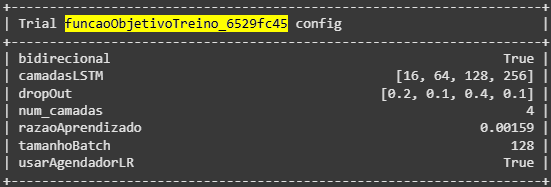

In [ ]:
carregadorTreino = DataLoader(MeuConjuntoDeDadosECG(xTreino, yTreino),
                              batch_size=128, shuffle=True, num_workers=2)
carregadorValidacao = DataLoader(MeuConjuntoDeDadosECG(xValidacao, yValidacao),
                                 batch_size=128, num_workers=2)

modelo2 = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[16,64,128,256],
                          valoresDeDropout=[0.2,0.1,0.4,0.1],
                  bidirecional=True).to(dispositivo)
print("Arquitetura do Modelo LSTM:")
print(modelo2)

Arquitetura do Modelo LSTM:
RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 16, batch_first=True, bidirectional=True)
    (1): LSTM(32, 64, batch_first=True, bidirectional=True)
    (2): LSTM(128, 128, batch_first=True, bidirectional=True)
    (3): LSTM(256, 256, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): Dropout(p=0.4, inplace=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=512, out_features=5, bias=True)
)


In [ ]:
funcaoPerda = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo2.parameters(), lr=0.00159)
numEpocas = 40
pacienciaParada = 5
caminhoCheckpoint = 'melhor_modelo_lstmB2.pth'
historico = treinarModelo(modelo2, carregadorTreino, carregadorValidacao,
                          funcaoPerda, otimizador, numEpocas, dispositivo,
                          pacienciaParada, caminhoCheckpoint, agendarTaxaAprendizado=True, lrInicial=0.00159)

Época 1: Acc Treino: 0.7002 | Acc Val: 0.7981 | F1 Val: 0.5812
F1 de validação melhorou (0.0000 -> 0.5812).


Época 2: Acc Treino: 0.8630 | Acc Val: 0.8674 | F1 Val: 0.6580
F1 de validação melhorou (0.5812 -> 0.6580).


Época 3: Acc Treino: 0.9127 | Acc Val: 0.9077 | F1 Val: 0.7279
F1 de validação melhorou (0.6580 -> 0.7279).


Época 4: Acc Treino: 0.9423 | Acc Val: 0.9055 | F1 Val: 0.7360
F1 de validação melhorou (0.7279 -> 0.7360).


Época 5: Acc Treino: 0.9593 | Acc Val: 0.9324 | F1 Val: 0.7862
F1 de validação melhorou (0.7360 -> 0.7862).


Época 6: Acc Treino: 0.9698 | Acc Val: 0.9441 | F1 Val: 0.7930
F1 de validação melhorou (0.7862 -> 0.7930).


Época 7: Acc Treino: 0.9721 | Acc Val: 0.9437 | F1 Val: 0.7980
F1 de validação melhorou (0.7930 -> 0.7980).


Época 8: Acc Treino: 0.9741 | Acc Val: 0.9436 | F1 Val: 0.7899


Época 9: Acc Treino: 0.9743 | Acc Val: 0.9456 | F1 Val: 0.8013
F1 de validação melhorou (0.7980 -> 0.8013).


Época 10: Acc Treino: 0.9768 | Acc Val: 0.9489 | F1 Val: 0.8064
F1 de validação melhorou (0.8013 -> 0.8064).


Época 11: Acc Treino: 0.9778 | Acc Val: 0.9435 | F1 Val: 0.7985


Época 12: Acc Treino: 0.9791 | Acc Val: 0.9496 | F1 Val: 0.8088
F1 de validação melhorou (0.8064 -> 0.8088).


Época 13: Acc Treino: 0.9802 | Acc Val: 0.9501 | F1 Val: 0.8134
F1 de validação melhorou (0.8088 -> 0.8134).


Época 14: Acc Treino: 0.9805 | Acc Val: 0.9487 | F1 Val: 0.8114


Época 15: Acc Treino: 0.9813 | Acc Val: 0.9522 | F1 Val: 0.8152
F1 de validação melhorou (0.8134 -> 0.8152).


Época 16: Acc Treino: 0.9823 | Acc Val: 0.9509 | F1 Val: 0.8118


Época 17: Acc Treino: 0.9830 | Acc Val: 0.9540 | F1 Val: 0.8236
F1 de validação melhorou (0.8152 -> 0.8236).


Época 18: Acc Treino: 0.9831 | Acc Val: 0.9534 | F1 Val: 0.8175


Época 19: Acc Treino: 0.9839 | Acc Val: 0.9538 | F1 Val: 0.8203


Época 20: Acc Treino: 0.9835 | Acc Val: 0.9569 | F1 Val: 0.8300
F1 de validação melhorou (0.8236 -> 0.8300).


Época 21: Acc Treino: 0.9852 | Acc Val: 0.9553 | F1 Val: 0.8258


Época 22: Acc Treino: 0.9847 | Acc Val: 0.9548 | F1 Val: 0.8245


Época 23: Acc Treino: 0.9855 | Acc Val: 0.9566 | F1 Val: 0.8282


Época 24: Acc Treino: 0.9857 | Acc Val: 0.9546 | F1 Val: 0.8222


Época 25: Acc Treino: 0.9863 | Acc Val: 0.9560 | F1 Val: 0.8252
Parada antecipada!
Carregando melhor modelo de 'melhor_modelo_lstm2.pth'


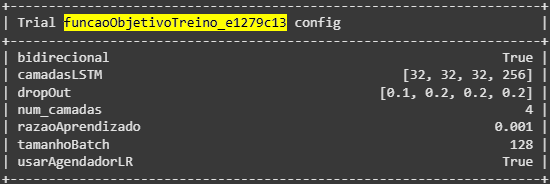

In [ ]:
carregadorTreino = DataLoader(MeuConjuntoDeDadosECG(xTreino, yTreino),
                              batch_size=128, shuffle=True, num_workers=2)
carregadorValidacao = DataLoader(MeuConjuntoDeDadosECG(xValidacao, yValidacao),
                                 batch_size=128, num_workers=2)

modelo3 = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[32,32,32,256],
                          valoresDeDropout=[0.1,0.2,0.2,0.2],
                  bidirecional=True).to(dispositivo)
print("Arquitetura do Modelo LSTM:")
print(modelo3)

Arquitetura do Modelo LSTM:
RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 32, batch_first=True, bidirectional=True)
    (1-2): 2 x LSTM(64, 32, batch_first=True, bidirectional=True)
    (3): LSTM(64, 256, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1-3): 3 x Dropout(p=0.2, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=512, out_features=5, bias=True)
)


In [ ]:
funcaoPerda = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo3.parameters(), lr=0.001)
numEpocas = 40
pacienciaParada = 5
caminhoCheckpoint = 'melhor_modelo_lstmB3.pth'
historico = treinarModelo(modelo3, carregadorTreino, carregadorValidacao,
                          funcaoPerda, otimizador, numEpocas, dispositivo,
                          pacienciaParada, caminhoCheckpoint, agendarTaxaAprendizado=True, lrInicial=0.001)

Época 1: Acc Treino: 0.6967 | Acc Val: 0.7677 | F1 Val: 0.5517
F1 de validação melhorou (0.0000 -> 0.5517).


Época 2: Acc Treino: 0.8089 | Acc Val: 0.8273 | F1 Val: 0.6242
F1 de validação melhorou (0.5517 -> 0.6242).


Época 3: Acc Treino: 0.8858 | Acc Val: 0.8430 | F1 Val: 0.6434
F1 de validação melhorou (0.6242 -> 0.6434).


Época 4: Acc Treino: 0.9220 | Acc Val: 0.9071 | F1 Val: 0.7160
F1 de validação melhorou (0.6434 -> 0.7160).


Época 5: Acc Treino: 0.9449 | Acc Val: 0.9240 | F1 Val: 0.7448
F1 de validação melhorou (0.7160 -> 0.7448).


Época 6: Acc Treino: 0.9606 | Acc Val: 0.9334 | F1 Val: 0.7656
F1 de validação melhorou (0.7448 -> 0.7656).


Época 7: Acc Treino: 0.9639 | Acc Val: 0.9310 | F1 Val: 0.7660
F1 de validação melhorou (0.7656 -> 0.7660).


Época 8: Acc Treino: 0.9660 | Acc Val: 0.9371 | F1 Val: 0.7771
F1 de validação melhorou (0.7660 -> 0.7771).


Época 9: Acc Treino: 0.9680 | Acc Val: 0.9380 | F1 Val: 0.7844
F1 de validação melhorou (0.7771 -> 0.7844).


Época 10: Acc Treino: 0.9698 | Acc Val: 0.9395 | F1 Val: 0.7827


Época 11: Acc Treino: 0.9700 | Acc Val: 0.9412 | F1 Val: 0.7869
F1 de validação melhorou (0.7844 -> 0.7869).


Época 12: Acc Treino: 0.9724 | Acc Val: 0.9412 | F1 Val: 0.7860


Época 13: Acc Treino: 0.9736 | Acc Val: 0.9432 | F1 Val: 0.7909
F1 de validação melhorou (0.7869 -> 0.7909).


Época 14: Acc Treino: 0.9742 | Acc Val: 0.9410 | F1 Val: 0.7852


Época 15: Acc Treino: 0.9751 | Acc Val: 0.9457 | F1 Val: 0.7980
F1 de validação melhorou (0.7909 -> 0.7980).


Época 16: Acc Treino: 0.9760 | Acc Val: 0.9464 | F1 Val: 0.7994
F1 de validação melhorou (0.7980 -> 0.7994).


Época 17: Acc Treino: 0.9760 | Acc Val: 0.9463 | F1 Val: 0.7998
F1 de validação melhorou (0.7994 -> 0.7998).


Época 18: Acc Treino: 0.9774 | Acc Val: 0.9467 | F1 Val: 0.7999
F1 de validação melhorou (0.7998 -> 0.7999).


Época 19: Acc Treino: 0.9779 | Acc Val: 0.9443 | F1 Val: 0.7944


Época 20: Acc Treino: 0.9784 | Acc Val: 0.9454 | F1 Val: 0.7974


Época 21: Acc Treino: 0.9789 | Acc Val: 0.9511 | F1 Val: 0.8104
F1 de validação melhorou (0.7999 -> 0.8104).


Época 22: Acc Treino: 0.9795 | Acc Val: 0.9441 | F1 Val: 0.7932


Época 23: Acc Treino: 0.9801 | Acc Val: 0.9481 | F1 Val: 0.8053


Época 24: Acc Treino: 0.9798 | Acc Val: 0.9506 | F1 Val: 0.8094


Época 25: Acc Treino: 0.9806 | Acc Val: 0.9507 | F1 Val: 0.8096


Época 26: Acc Treino: 0.9806 | Acc Val: 0.9497 | F1 Val: 0.8088
Parada antecipada!
Carregando melhor modelo de 'melhor_modelo_lstm3.pth'


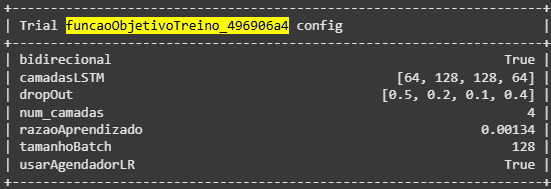

In [ ]:
carregadorTreino = DataLoader(MeuConjuntoDeDadosECG(xTreino, yTreino),
                              batch_size=128, shuffle=True, num_workers=2)
carregadorValidacao = DataLoader(MeuConjuntoDeDadosECG(xValidacao, yValidacao),
                                 batch_size=128, num_workers=2)

modelo4 = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[64,128,128,64],
                          valoresDeDropout=[0.5,0.2,0.1,0.4],
                  bidirecional=True).to(dispositivo)
print("Arquitetura do Modelo LSTM:")
print(modelo4)

Arquitetura do Modelo LSTM:
RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 64, batch_first=True, bidirectional=True)
    (1): LSTM(128, 128, batch_first=True, bidirectional=True)
    (2): LSTM(256, 128, batch_first=True, bidirectional=True)
    (3): LSTM(256, 64, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Dropout(p=0.2, inplace=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): Dropout(p=0.4, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=128, out_features=5, bias=True)
)


In [ ]:
funcaoPerda = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo4.parameters(), lr=0.00134)
numEpocas = 40
pacienciaParada = 5
caminhoCheckpoint = 'melhor_modelo_lstm4.pth'
historico = treinarModelo(modelo4, carregadorTreino, carregadorValidacao,
                          funcaoPerda, otimizador, numEpocas, dispositivo,
                          pacienciaParada, caminhoCheckpoint, agendarTaxaAprendizado=True, lrInicial=0.00134)

Época 1: Acc Treino: 0.7268 | Acc Val: 0.8281 | F1 Val: 0.6179
F1 de validação melhorou (0.0000 -> 0.6179).


Época 2: Acc Treino: 0.8679 | Acc Val: 0.8740 | F1 Val: 0.6862
F1 de validação melhorou (0.6179 -> 0.6862).


Época 3: Acc Treino: 0.9105 | Acc Val: 0.8878 | F1 Val: 0.6981
F1 de validação melhorou (0.6862 -> 0.6981).


Época 4: Acc Treino: 0.9357 | Acc Val: 0.9150 | F1 Val: 0.7409
F1 de validação melhorou (0.6981 -> 0.7409).


Época 5: Acc Treino: 0.9520 | Acc Val: 0.9285 | F1 Val: 0.7577
F1 de validação melhorou (0.7409 -> 0.7577).


Época 6: Acc Treino: 0.9646 | Acc Val: 0.9347 | F1 Val: 0.7782
F1 de validação melhorou (0.7577 -> 0.7782).


Época 7: Acc Treino: 0.9671 | Acc Val: 0.9343 | F1 Val: 0.7823
F1 de validação melhorou (0.7782 -> 0.7823).


Época 8: Acc Treino: 0.9699 | Acc Val: 0.9459 | F1 Val: 0.7997
F1 de validação melhorou (0.7823 -> 0.7997).


Época 9: Acc Treino: 0.9719 | Acc Val: 0.9406 | F1 Val: 0.7904


Época 10: Acc Treino: 0.9726 | Acc Val: 0.9368 | F1 Val: 0.7855


Época 11: Acc Treino: 0.9741 | Acc Val: 0.9451 | F1 Val: 0.8105
F1 de validação melhorou (0.7997 -> 0.8105).


Época 12: Acc Treino: 0.9758 | Acc Val: 0.9449 | F1 Val: 0.8025


Época 13: Acc Treino: 0.9761 | Acc Val: 0.9464 | F1 Val: 0.8043


Época 14: Acc Treino: 0.9772 | Acc Val: 0.9468 | F1 Val: 0.8051


Época 15: Acc Treino: 0.9781 | Acc Val: 0.9449 | F1 Val: 0.8011


Época 16: Acc Treino: 0.9784 | Acc Val: 0.9452 | F1 Val: 0.8032
Parada antecipada!
Carregando melhor modelo de 'melhor_modelo_lstm4.pth'


# Final Model Evaluation on the Test Set

In [ ]:
def avaliarModeloNoConjuntoDeTeste(modelo, dispositivo):
    modelo.eval()
    listaCompletaDeRotulos = []
    listaCompletaDePredicoes = []

    with torch.no_grad():
        for entradas, rotulos in tqdm(carregadorTeste, desc="Avaliando no Conjunto de Teste"):
            entradas = entradas.to(dispositivo)
            saidas = modelo(entradas)
            _, previstos = torch.max(saidas.data, 1)
            listaCompletaDeRotulos.extend(rotulos.numpy())
            listaCompletaDePredicoes.extend(previstos.cpu().numpy())

    acuracia = accuracy_score(listaCompletaDeRotulos, listaCompletaDePredicoes)
    f1 = f1_score(listaCompletaDeRotulos, listaCompletaDePredicoes, average='macro')

    return acuracia, f1

Loading the Best Full-Feature Model

In [ ]:
carregadorTreino = DataLoader(MeuConjuntoDeDadosECG(xTreino, yTreino),
                              batch_size=64, shuffle=True, num_workers=2)
carregadorValidacao = DataLoader(MeuConjuntoDeDadosECG(xValidacao, yValidacao),
                                 batch_size=64, num_workers=2)

modelo2 = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[256, 32, 64, 256], valoresDeDropout=[0.2,0.5,0.3,0.1],
                  bidirecional=True).to(dispositivo)
print("Arquitetura do Modelo LSTM:")
print(modelo2)

In [ ]:
modelo = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[256, 32, 64, 256],
                          valoresDeDropout=[0.2,0.5,0.3,0.1],
                  bidirecional=True).to(dispositivo)

estado_do_modelo = torch.load('/content/drive/MyDrive/colab/melhor_modelo_lstm2.pth', map_location=dispositivo)
modelo.load_state_dict(estado_do_modelo)

modelo.to(dispositivo)

RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 256, batch_first=True, bidirectional=True)
    (1): LSTM(512, 32, batch_first=True, bidirectional=True)
    (2): LSTM(64, 64, batch_first=True, bidirectional=True)
    (3): LSTM(128, 256, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): Dropout(p=0.5, inplace=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=512, out_features=5, bias=True)
)

In [ ]:
accModelo, f1Modelo = avaliarModeloNoConjuntoDeTeste(modelo, dispositivo)

Avaliando no Conjunto de Teste: 100%|██████████| 172/172 [00:06<00:00, 27.94it/s]


A final F1-score of 0.8614210266271229 is a strong result. This metric is crucial as it demonstrates that the model achieved a healthy balance between precision and recall across all classes

In [ ]:
print('F1 do modelo com todas as colunas: ', f1Modelo)
print('Accuracia do modelo com todas as colunas: ', accModelo)

F1 do modelo com todas as colunas:  0.8614210266271229
Accuracia do modelo com todas as colunas:  0.9668372008039466


Let's now prepare the test evaluation for the model trained exclusively on the first 140 features

In [ ]:
xTeste.shape

(21892, 187)

In [ ]:
xTeste[:, :140].shape

(21892, 140)

In [ ]:
xTeste = xTeste[:, :140]

In [ ]:
carregadorTeste = DataLoader(MeuConjuntoDeDadosECG(xTeste, yTeste),
                             batch_size=128, num_workers=2)

Loading the Best Selected-Feature Model

In [ ]:
modeloB = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[256, 256, 256],
                          valoresDeDropout=[0.3, 0.1, 0.5],
                  bidirecional=True).to(dispositivo)

estadoModeloB = torch.load('/content/drive/MyDrive/colab/melhor_modelo_lstmB.pth', map_location=dispositivo)
modeloB.load_state_dict(estadoModeloB)

modeloB.to(dispositivo)

RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 256, batch_first=True, bidirectional=True)
    (1-2): 2 x LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): Dropout(p=0.5, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=512, out_features=5, bias=True)
)

In [ ]:
accModeloB, f1ModeloB = avaliarModeloNoConjuntoDeTeste(modeloB, dispositivo)

Avaliando no Conjunto de Teste: 100%|██████████| 172/172 [00:09<00:00, 18.32it/s]


The model trained on the truncated feature set achieved an F1-score of 0.876, a marginal improvement over the full-feature model. While statistical tests would be required to confirm if this difference is significant, the principle of Occam's Razor dictates our choice. Given two models with comparable performance, the simpler one is superior. Therefore, the 140-column model is our final choice due to its reduced complexity and greater efficiency

In [ ]:
print('F1 do modelo com poda nas colunas: ', f1ModeloB)
print('Accuracia do modelo com poda nas colunas: ', accModeloB)

F1 do modelo com poda nas colunas:  0.8764350294699594
Accuracia do modelo com poda nas colunas:  0.9727754430842317


 # Extra: Validating the Over-Sampling Balancing Strategy
 To resolve any lingering questions about our chosen balancing method, we conducted a final experiment. We tested the ideal over-sampling strategy (retaining all majority class data and over-sampling only the minority classes) using the best hyperparameter configuration from our 140-column model. Previously, this approach was deemed computationally infeasible for the full hyperparameter tuning phase. However, training a single model instance with this configuration is perfectly feasible and allows us to isolate the impact of the balancing strategy on the final performance

In [ ]:
dadosTreinoBalanceadosMod2 = balancearDados(dadosParaTreinoMod, len(dadosParaTreinoMod[dadosParaTreinoMod[187] == 0]))
xTreinoMod2 = dadosTreinoBalanceadosMod2.drop(187, axis=1).values
yTreinoMod2 = dadosTreinoBalanceadosMod2[187].values

In [ ]:
print(f"Conjunto de treino criado com {len(xTreinoMod2)} amostras (balanceado).")
print("Distribuição de classes no treino balanceado:")
print(pd.Series(yTreinoMod2).value_counts().sort_index())

Conjunto de treino criado com 289885 amostras (balanceado).
Distribuição de classes no treino balanceado:
0.0    57977
1.0    57977
2.0    57977
3.0    57977
4.0    57977
Name: count, dtype: int64


In [ ]:
carregadorTreino = DataLoader(MeuConjuntoDeDadosECG(xTreinoMod2, yTreinoMod2),
                              batch_size=128, shuffle=True, num_workers=2)
carregadorValidacao = DataLoader(MeuConjuntoDeDadosECG(xValidacaoMod, yValidacaoMod),
                                 batch_size=128, num_workers=2)

modelo = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[256, 256, 256],
                          valoresDeDropout=[0.3, 0.1, 0.5],
                  bidirecional=True).to(dispositivo)

In [ ]:
funcaoPerda = nn.CrossEntropyLoss()
otimizador = optim.Adam(modelo.parameters(), lr=0.0011162460999600942)
numEpocas = 40
pacienciaParada = 5
caminhoCheckpoint = '/content/drive/MyDrive/ModeloECG/melhor_modelo_lstmC.pth'
historico = treinarModelo(modelo, carregadorTreino, carregadorValidacao,
                          funcaoPerda, otimizador, numEpocas, dispositivo,
                          pacienciaParada, caminhoCheckpoint, agendarTaxaAprendizado=True, lrInicial=0.0011162460999600942)

Época 1: Acc Treino: 0.9676 | Acc Val: 0.9430 | F1 Val: 0.8023
F1 de validação melhorou (0.0000 -> 0.8023).


Época 2: Acc Treino: 0.9851 | Acc Val: 0.9657 | F1 Val: 0.8378
F1 de validação melhorou (0.8023 -> 0.8378).


Época 3: Acc Treino: 0.9911 | Acc Val: 0.9718 | F1 Val: 0.8629
F1 de validação melhorou (0.8378 -> 0.8629).


Época 4: Acc Treino: 0.9948 | Acc Val: 0.9821 | F1 Val: 0.9096
F1 de validação melhorou (0.8629 -> 0.9096).


Época 5: Acc Treino: 0.9973 | Acc Val: 0.9854 | F1 Val: 0.9177
F1 de validação melhorou (0.9096 -> 0.9177).


Época 6: Acc Treino: 0.9988 | Acc Val: 0.9886 | F1 Val: 0.9325
F1 de validação melhorou (0.9177 -> 0.9325).


Época 7: Acc Treino: 0.9993 | Acc Val: 0.9884 | F1 Val: 0.9334
F1 de validação melhorou (0.9325 -> 0.9334).


Época 8: Acc Treino: 0.9994 | Acc Val: 0.9884 | F1 Val: 0.9328


Época 9: Acc Treino: 0.9996 | Acc Val: 0.9884 | F1 Val: 0.9319


Época 10: Acc Treino: 0.9997 | Acc Val: 0.9888 | F1 Val: 0.9352
F1 de validação melhorou (0.9334 -> 0.9352).


Época 11: Acc Treino: 0.9997 | Acc Val: 0.9887 | F1 Val: 0.9355
F1 de validação melhorou (0.9352 -> 0.9355).


Época 12: Acc Treino: 0.9998 | Acc Val: 0.9887 | F1 Val: 0.9341


Época 13: Acc Treino: 0.9999 | Acc Val: 0.9887 | F1 Val: 0.9359
F1 de validação melhorou (0.9355 -> 0.9359).


Época 14: Acc Treino: 0.9999 | Acc Val: 0.9884 | F1 Val: 0.9335


Época 15: Acc Treino: 0.9999 | Acc Val: 0.9893 | F1 Val: 0.9389
F1 de validação melhorou (0.9359 -> 0.9389).


Época 16: Acc Treino: 0.9999 | Acc Val: 0.9887 | F1 Val: 0.9353


Época 17: Acc Treino: 0.9999 | Acc Val: 0.9890 | F1 Val: 0.9379


Época 18: Acc Treino: 0.9999 | Acc Val: 0.9889 | F1 Val: 0.9376


Época 19: Acc Treino: 1.0000 | Acc Val: 0.9890 | F1 Val: 0.9367


Época 20: Acc Treino: 1.0000 | Acc Val: 0.9890 | F1 Val: 0.9386
Parada antecipada!
Carregando melhor modelo de '/content/drive/MyDrive/ModeloECG/melhor_modelo_lstmC.pth'


In [ ]:
modeloC = RedeLSTMFlexivel(tamanhoDaEntrada=1, numeroDeClasses=5,
                  tamanhosDasCamadasOcultas=[256, 256, 256],
                          valoresDeDropout=[0.3, 0.1, 0.5],
                  bidirecional=True).to(dispositivo)

estado_do_modelo = torch.load('/content/drive/MyDrive/ModeloECG/melhor_modelo_lstmC.pth', map_location=dispositivo)
modeloC.load_state_dict(estado_do_modelo)

modeloC.to(dispositivo)

RedeLSTMFlexivel(
  (camadasLstm): ModuleList(
    (0): LSTM(1, 256, batch_first=True, bidirectional=True)
    (1-2): 2 x LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (camadasDeDropout): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Dropout(p=0.1, inplace=False)
    (2): Dropout(p=0.5, inplace=False)
  )
  (camadaDeClassificacao): Linear(in_features=512, out_features=5, bias=True)
)

In [ ]:
accModeloC, f1ModeloC = avaliarModeloNoConjuntoDeTeste(modeloC, dispositivo)

Avaliando no Conjunto de Teste: 100%|██████████| 172/172 [00:08<00:00, 19.84it/s]


The oversampling strategy proved to be the most effective, delivering a peak F1-score of 0.9250138 on the test set. This performance, however, came at a significant computational cost. The final model training required nearly two hours to complete. Furthermore, the Bayesian optimization routine, constrained to the first 140 features, took approximately three hours to run 33 trials.

In [ ]:
print('F1 do modelo com poda nas colunas e over sampling: ', f1ModeloC)
print('Accuracia do modelo com poda nas colunas e over sampling: ', accModeloC)

F1 do modelo com poda nas colunas e over sampling:  0.9250138001807828
Accuracia do modelo com poda nas colunas e over sampling:  0.9873469760643158
